In [237]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import metrics

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from lineage import get_lineage_coll, get_lineage_snp
from resistance import get_resistance_snp
from coinfection_functions import import_VCF42_to_pandas, filter_repeats, add_snp_distance, scatter_vcf_pos, distplot_sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
sample_list = []
vcf_files = []
directory = "in_silico"

for file in os.listdir(directory):
    if file.endswith(".snp.hf.pass.vcf"):
        name = file.split(".")[0]
        sample_list.append(name)
        file_path = os.path.join(directory, file)
        vcf_files.append(file_path)
        
sample_list.sort()
vcf_files.sort()

print(sample_list)
print(vcf_files)

['16250874FFD', '56850173', 'AL-75607', 'AL14621', 'BURGOS89109', 'P1_50', 'P1_80', 'P1_90', 'P1_95', 'P2_50', 'P2_80', 'P2_90', 'P2_95', 'P3_50', 'P3_80', 'P3_90', 'P3_95', 'SOMOZACOL2']
['in_silico/16250874FFD.snp.hf.pass.vcf', 'in_silico/56850173.snp.hf.pass.vcf', 'in_silico/AL-75607.snp.hf.pass.vcf', 'in_silico/AL14621.snp.hf.pass.vcf', 'in_silico/BURGOS89109.snp.hf.pass.vcf', 'in_silico/P1_50.snp.hf.pass.vcf', 'in_silico/P1_80.snp.hf.pass.vcf', 'in_silico/P1_90.snp.hf.pass.vcf', 'in_silico/P1_95.snp.hf.pass.vcf', 'in_silico/P2_50.snp.hf.pass.vcf', 'in_silico/P2_80.snp.hf.pass.vcf', 'in_silico/P2_90.snp.hf.pass.vcf', 'in_silico/P2_95.snp.hf.pass.vcf', 'in_silico/P3_50.snp.hf.pass.vcf', 'in_silico/P3_80.snp.hf.pass.vcf', 'in_silico/P3_90.snp.hf.pass.vcf', 'in_silico/P3_95.snp.hf.pass.vcf', 'in_silico/SOMOZACOL2.snp.hf.pass.vcf']


# Import vcf as dataframe

In [4]:
x = datetime.datetime.now()
print(x)
dict_vcf = {}
for vcf, df_name in zip(vcf_files, sample_list):
    dict_vcf[df_name] = import_VCF42_to_pandas(vcf)
y = datetime.datetime.now()
print(y)
print("Done with import in: %s" % (y - x))

2019-05-27 11:22:46.565547
2019-05-27 11:25:09.581123
Done with import in: 0:02:23.015576


In [5]:
dict_vcf['P1_80'].head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD    dp  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0  42.0   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0  13.0   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0  52.0   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0  72.0   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0  73.0   

         aF        AF  
0  0.238095  0.761905  
1  0.000000  1.000000  
2  0.826923  0.173077  
3  0.305556  0.694444  
4  0.000000  1.000000

In [6]:
dict_vcf['P1_80'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'dp', 'aF', 'AF'],
      dtype='object')

# Add repeat and snp distance info

In [7]:
#dict_vcf = {}

for name, vcf_df in dict_vcf.items():
    #Add repeat info (Phage, Transposon or PE/PPE regions)
    vcf_df['Is_repeat'] = vcf_df.apply(filter_repeats, axis=1)

    #Add info of nearby positions
    add_snp_distance(vcf_df)

In [8]:
dict_vcf['P1_80'].columns

Index(['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT',
       'sample', 'AC', 'af', 'AN', 'BaseQRankSum', 'DP', 'ExcessHet', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'GT', 'AD', 'GQ', 'PL', 'PGT', 'PID', 'PS', 'len_AD', 'REF_AD',
       'ALT_AD', 'dp', 'aF', 'AF', 'Is_repeat', 'snp_left_distance',
       'snp_right_distance'],
      dtype='object')

# Create a set of filtered df in different dictionary

In [9]:
dict_dff = {}
distance = 15
QD = 15
for name, df_vcf in dict_vcf.items():
    list_positions_to_filter = df_vcf['POS'][((df_vcf.snp_left_distance <= distance)|
                                (df_vcf.snp_right_distance <= distance)|
                                (df_vcf.Is_repeat == True) |
                                (df_vcf.AF <= 0.0) |
                                (df_vcf.QD <= QD))].tolist()
    dict_dff[name] = df_vcf[~df_vcf.POS.isin(list_positions_to_filter)]

In [10]:
dict_dff['P1_80'][dict_dff['P1_80'].Is_repeat == True].head()

Empty DataFrame
Columns: [#CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT, sample, AC, af, AN, BaseQRankSum, DP, ExcessHet, FS, InbreedingCoeff, MQ, MQRankSum, QD, ReadPosRankSum, SOR, GT, AD, GQ, PL, PGT, PID, PS, len_AD, REF_AD, ALT_AD, dp, aF, AF, Is_repeat, snp_left_distance, snp_right_distance]
Index: []

In [11]:
dict_dff['P1_80'][dict_dff['P1_80'].snp_left_distance <= 30].head()

#CHROM      POS ID REF ALT      QUAL FILTER  \
229  MTB_anc   498557  .   A   C  25753.24   PASS   
293  MTB_anc   709226  .   G   A  17662.60   PASS   
324  MTB_anc   815851  .   G   A  39915.27   PASS   
422  MTB_anc  1107940  .   C   A  48351.27   PASS   
473  MTB_anc  1250357  .   G   T  46137.27   PASS   

                                                  INFO  \
229  AC=1;AF=0.500;AN=2;BaseQRankSum=1.60;DP=62;Exc...   
293  AC=1;AF=0.500;AN=2;BaseQRankSum=3.07;DP=53;Exc...   
324  AC=2;AF=1.00;AN=2;DP=81;ExcessHet=3.0103;FS=0....   
422  AC=2;AF=1.00;AN=2;BaseQRankSum=1.56;DP=70;Exce...   
473  AC=2;AF=1.00;AN=2;BaseQRankSum=1.79;DP=83;Exce...   

                        FORMAT  \
229             GT:AD:DP:GQ:PL   
293  GT:AD:DP:GQ:PGT:PID:PL:PS   
324             GT:AD:DP:GQ:PL   
422             GT:AD:DP:GQ:PL   
473             GT:AD:DP:GQ:PL   

                                               sample   AC   af   AN  \
229                        0/1:10,52:62:99:1763,0,157  1.0  0.5  2.0   
293  0|1:41,12:53:99:0|1:709206_C_T:381,0,2439:709206  1.0  0.5  2.0   
324                         1/1:0,81:81:99:2410,240,0  2.0  1.0  2.0   
422                         1/1:0,70:70:99:2220,209,0  2.0  1.0  2.0   
473                         1/1:0,83:83:99:2844,249,0  2.0  1.0  2.0   

     BaseQRankSum    DP  ExcessHet     FS InbreedingCoeff    MQ  MQRankSum  \
229          1.60  62.0     0.0021  2.536          0.7750  60.0        0.0   
293          3.07  53.0     0.0111  2.159          0.6656  60.0        0.0   
324           NaN  81.0     3.0103  0.000         -0.0000  60.0        NaN   
422          1.56  70.0     3.0103  0.000         -0.0000  60.0        0.0   
473          1.79  83.0     3.0103  0.000         -0.0000  60.0        0.0   

        QD  ReadPosRankSum    SOR   GT     AD    GQ          PL  PGT  \
229  33.84          -1.763  0.373  0/1  10,52  99.0  1763,0,157  NaN   
293  33.26           2.220  0.740  0|1  41,12  99.0  381,0,2439  0|1   
324  30.99             NaN  1.046  1/1   0,81  99.0  2410,240,0  NaN   
422  32.28           1.400  0.124  1/1   0,70  99.0  2220,209,0  NaN   
473  34.10           1.640  0.469  1/1   0,83  99.0  2844,249,0  NaN   

            PID      PS  len_AD  REF_AD  ALT_AD    dp        aF        AF  \
229         NaN     NaN       2    10.0    52.0  62.0  0.161290  0.838710   
293  709206_C_T  709206       2    41.0    12.0  53.0  0.773585  0.226415   
324         NaN     NaN       2     0.0    81.0  81.0  0.000000  1.000000   
422         NaN     NaN       2     0.0    70.0  70.0  0.000000  1.000000   
473         NaN     NaN       2     0.0    83.0  83.0  0.000000  1.000000   

     Is_repeat  snp_left_distance  snp_right_distance  
229      False               26.0               396.0  
293      False               19.0              3467.0  
324      False               16.0              1779.0  
422      False               23.0              1223.0  
473      False               17.0               754.0

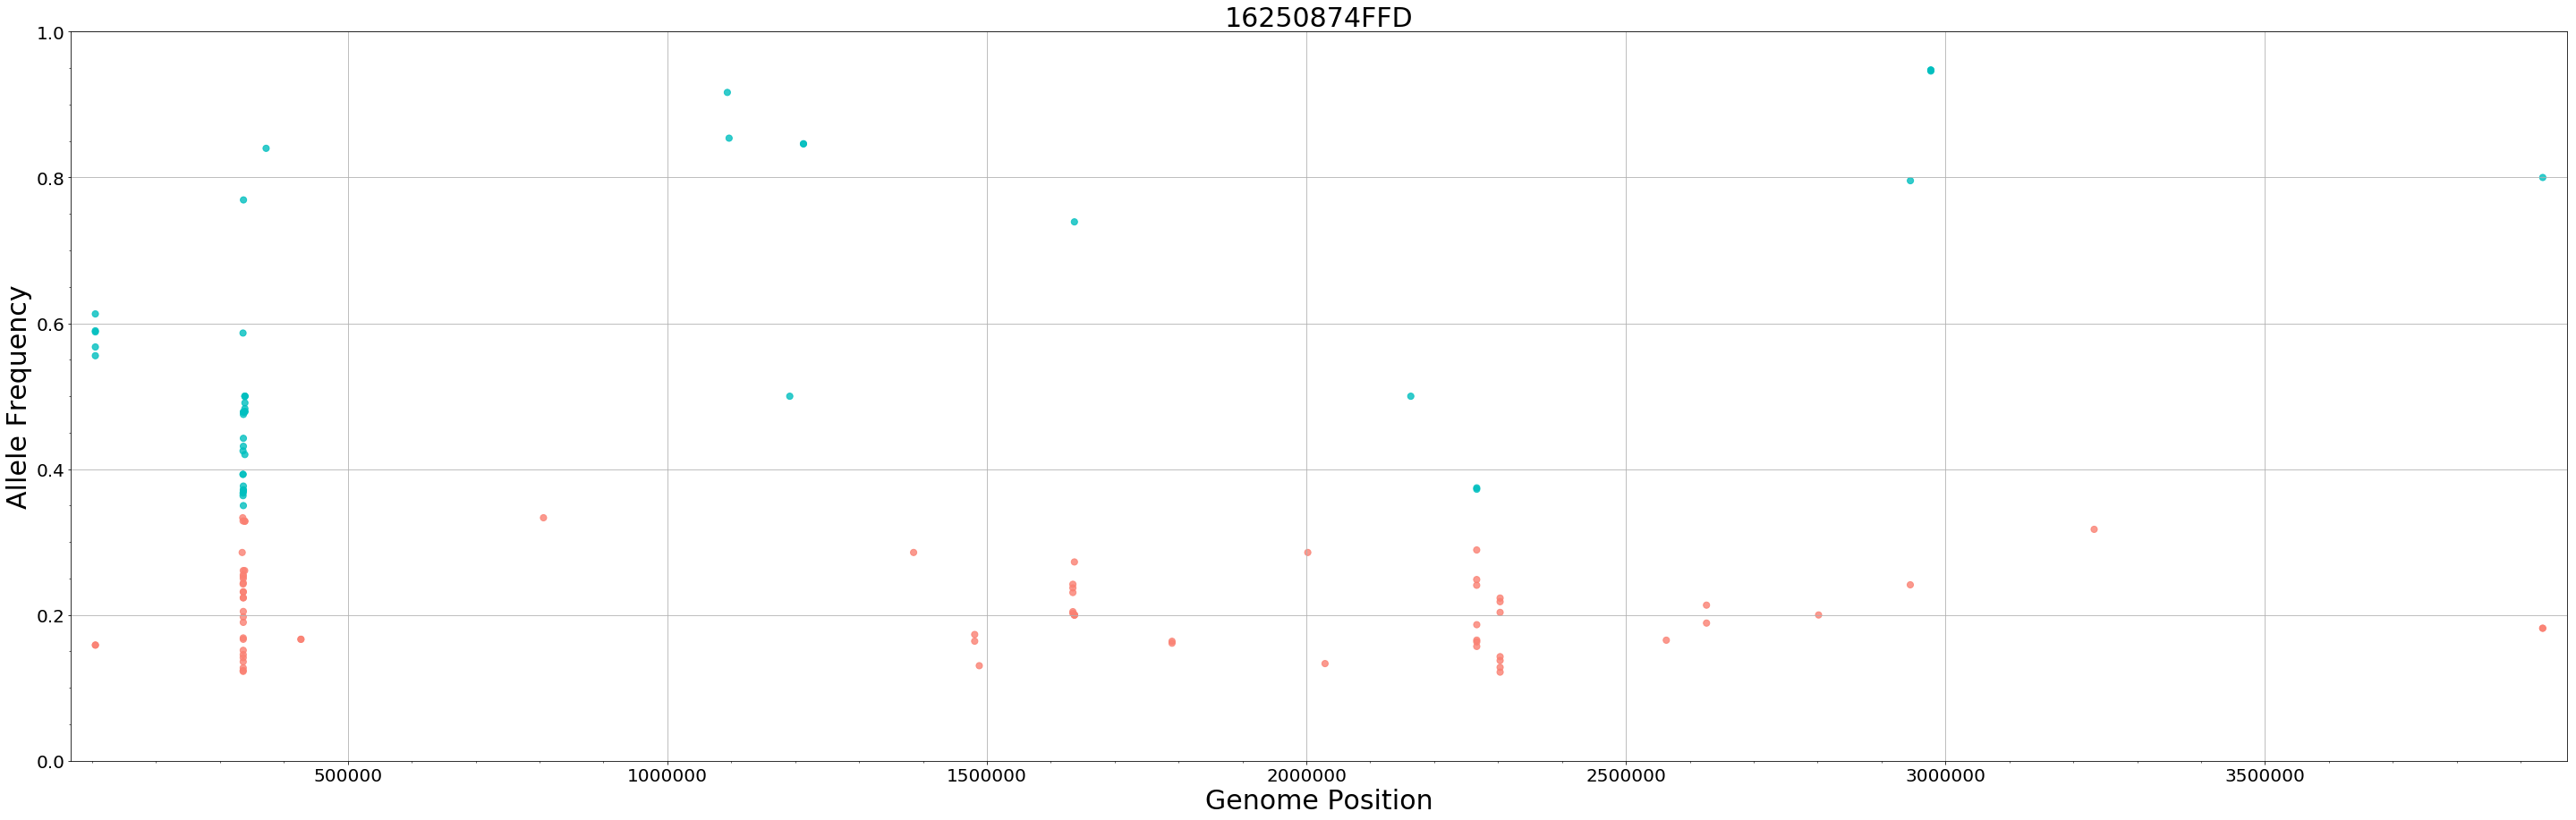

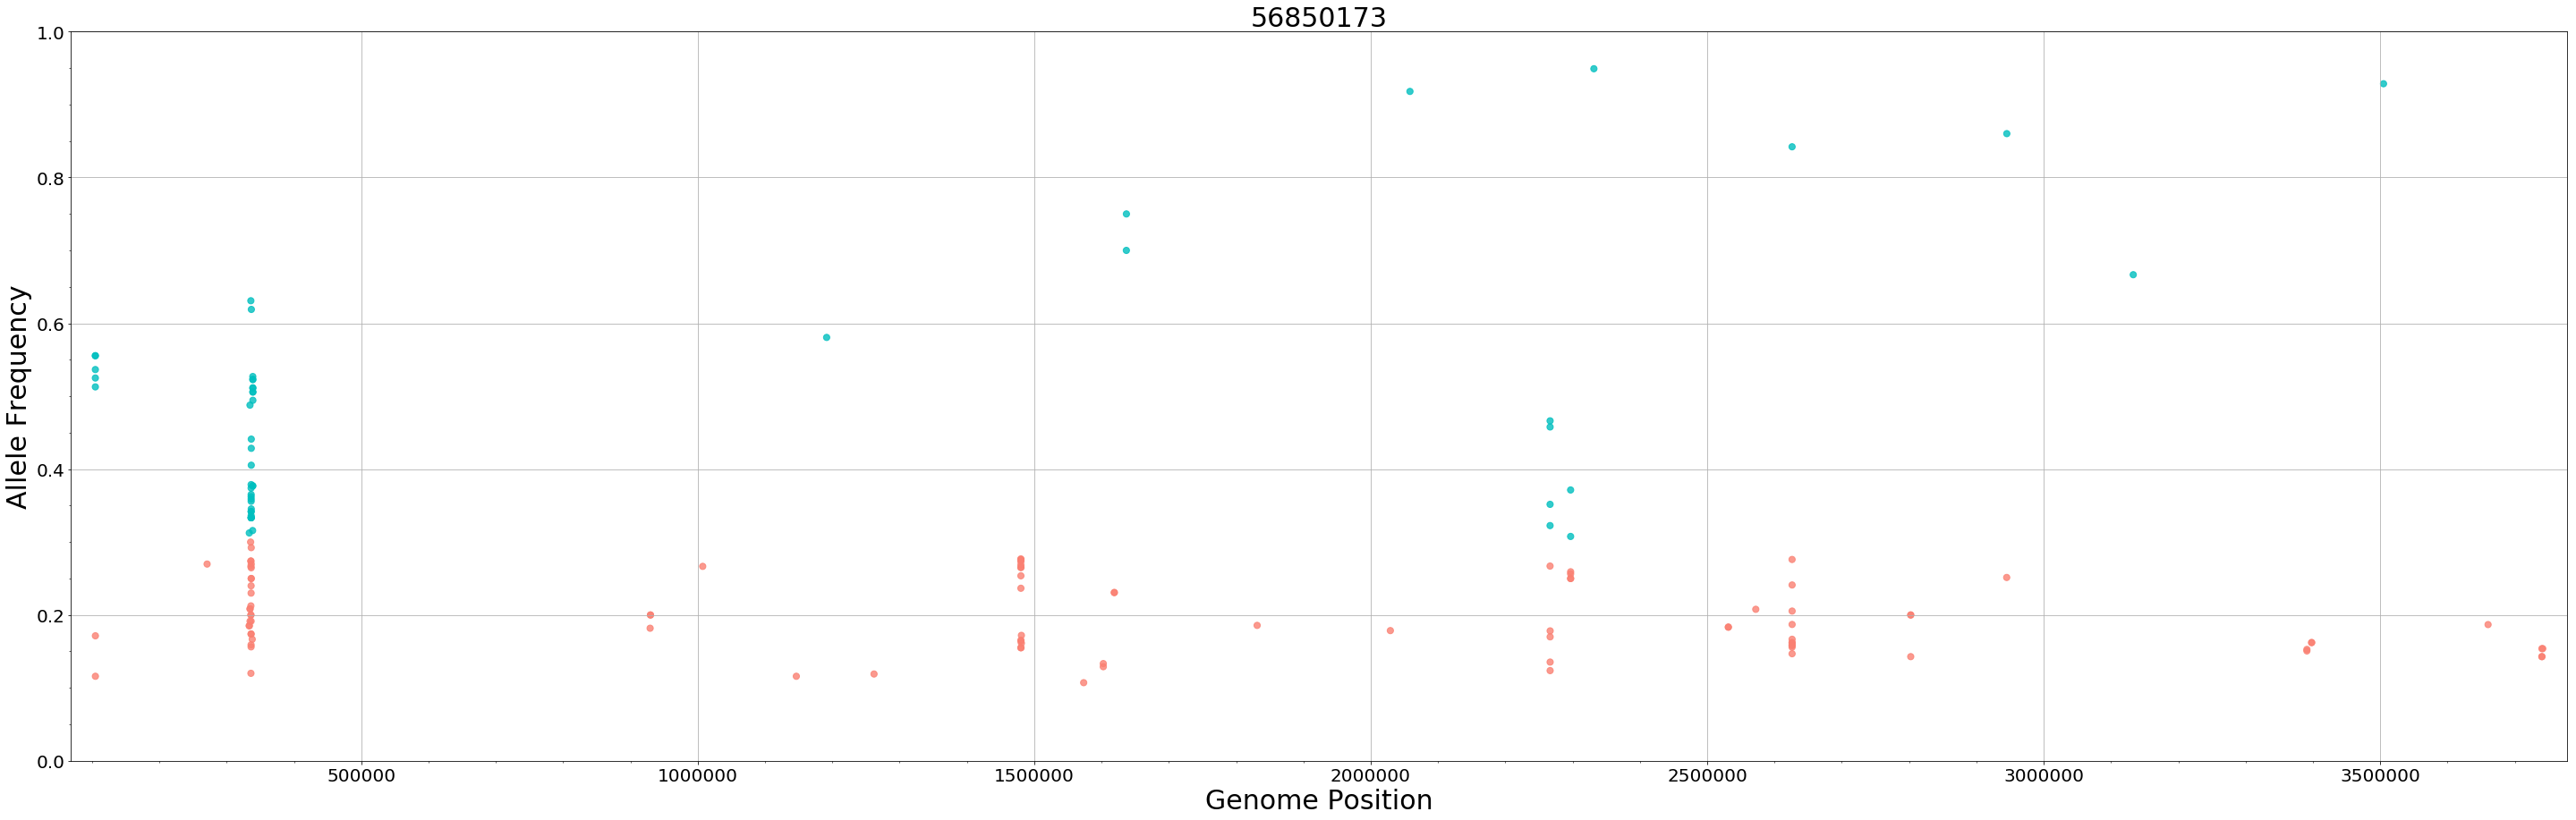

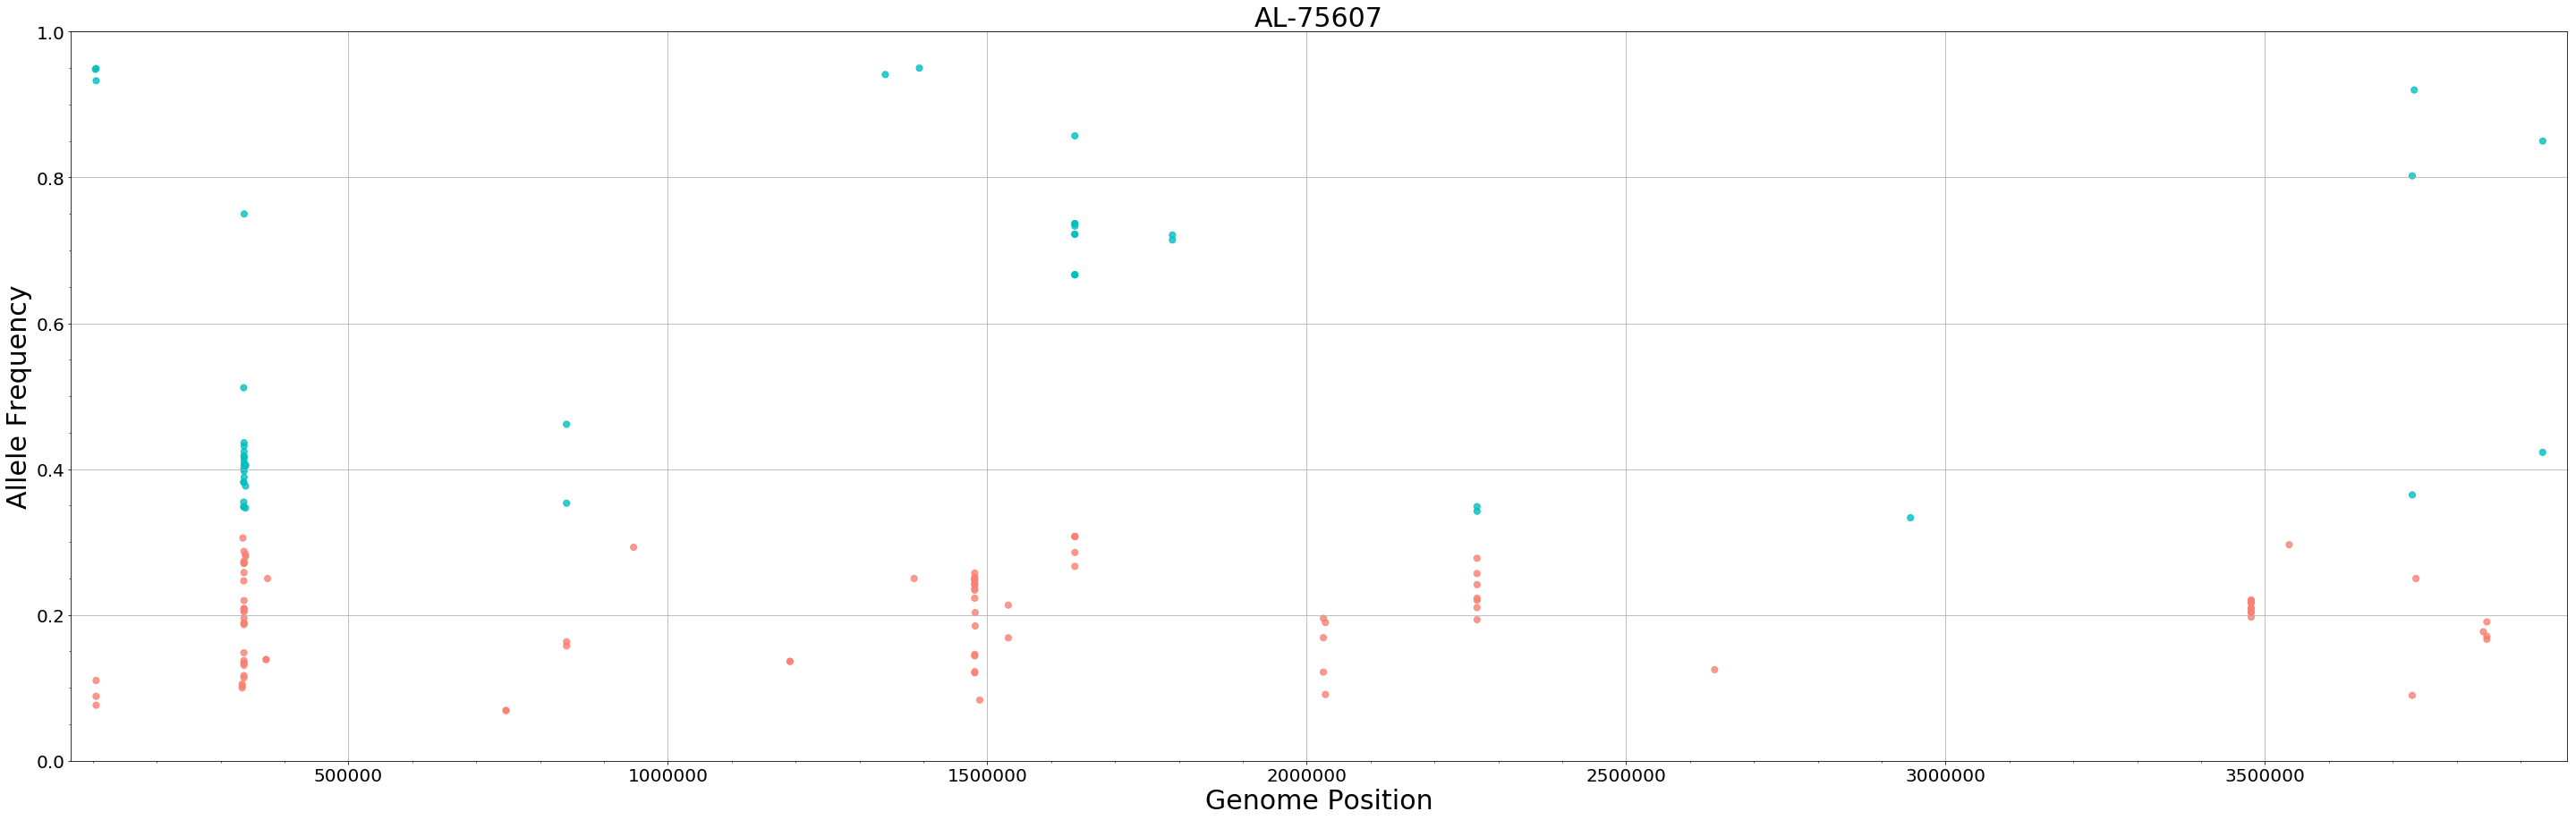

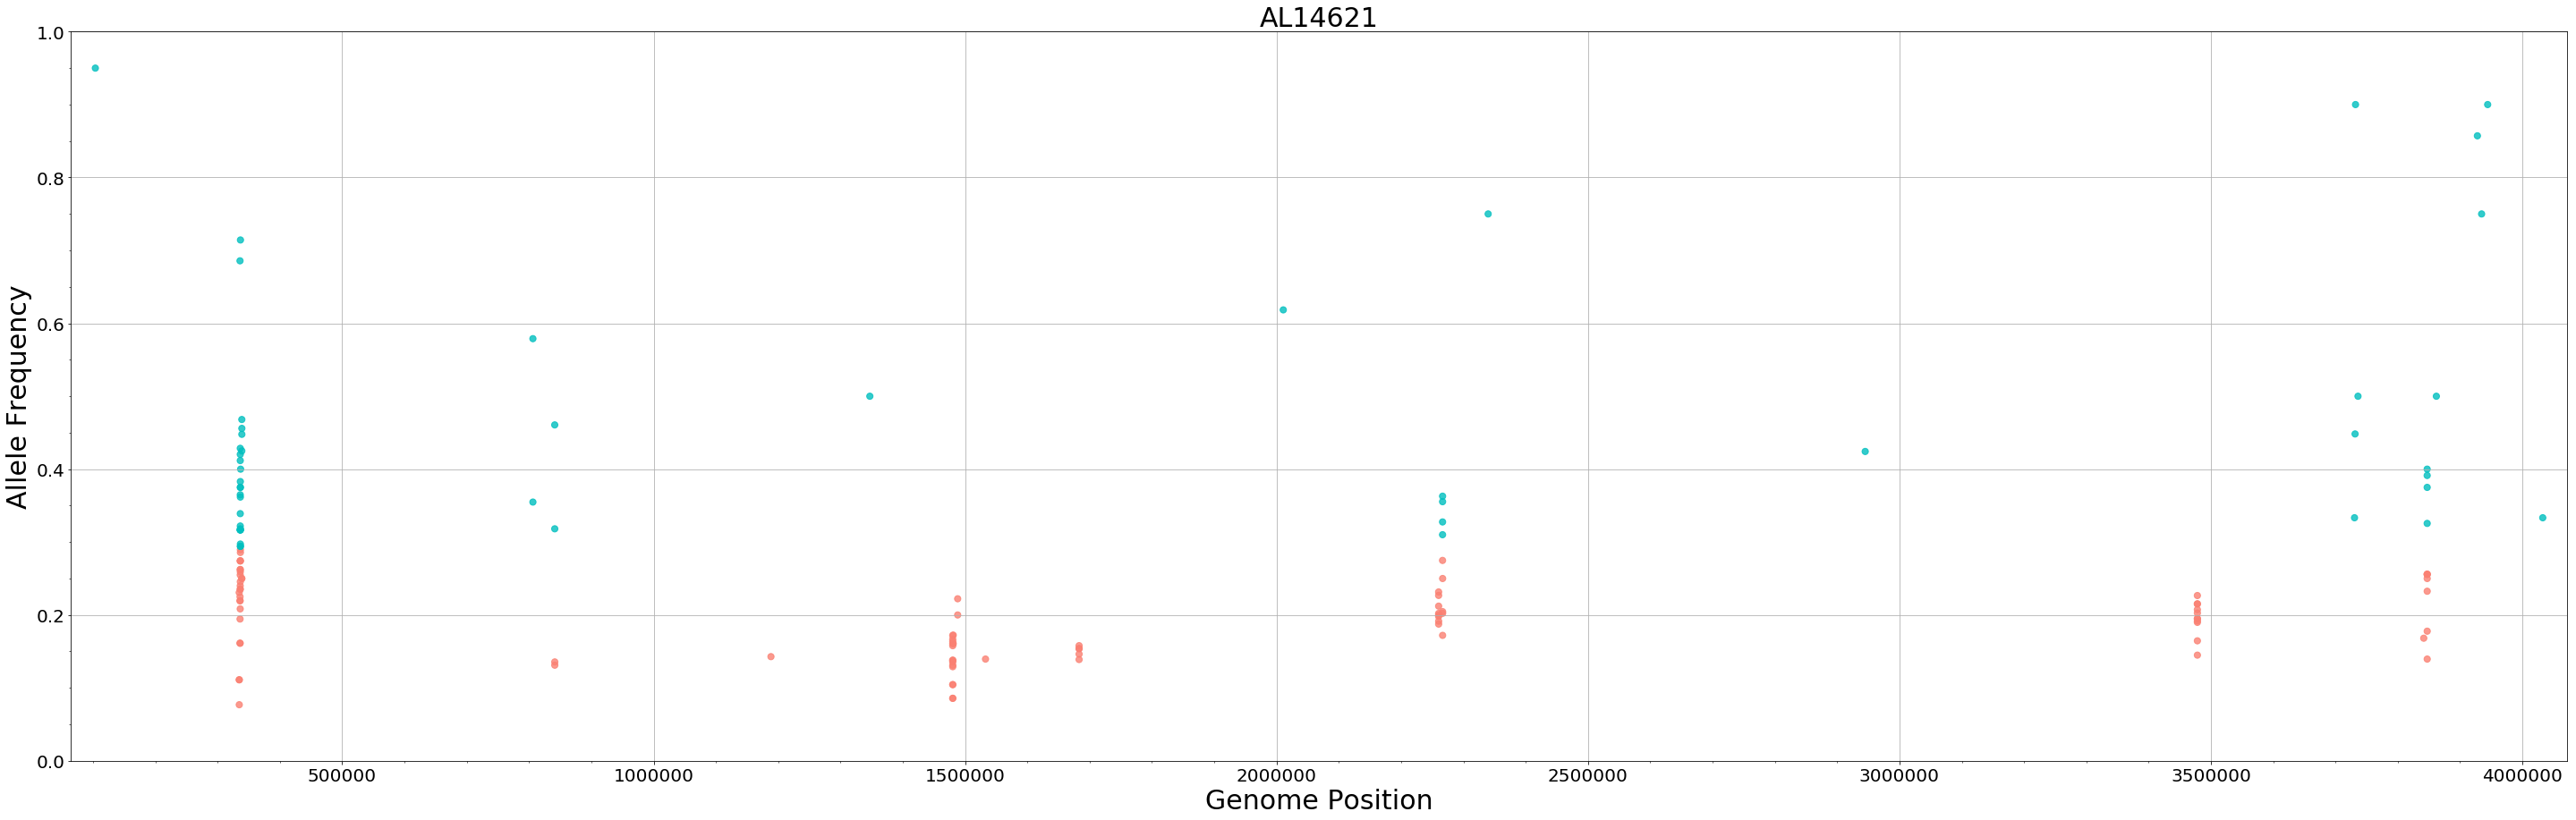

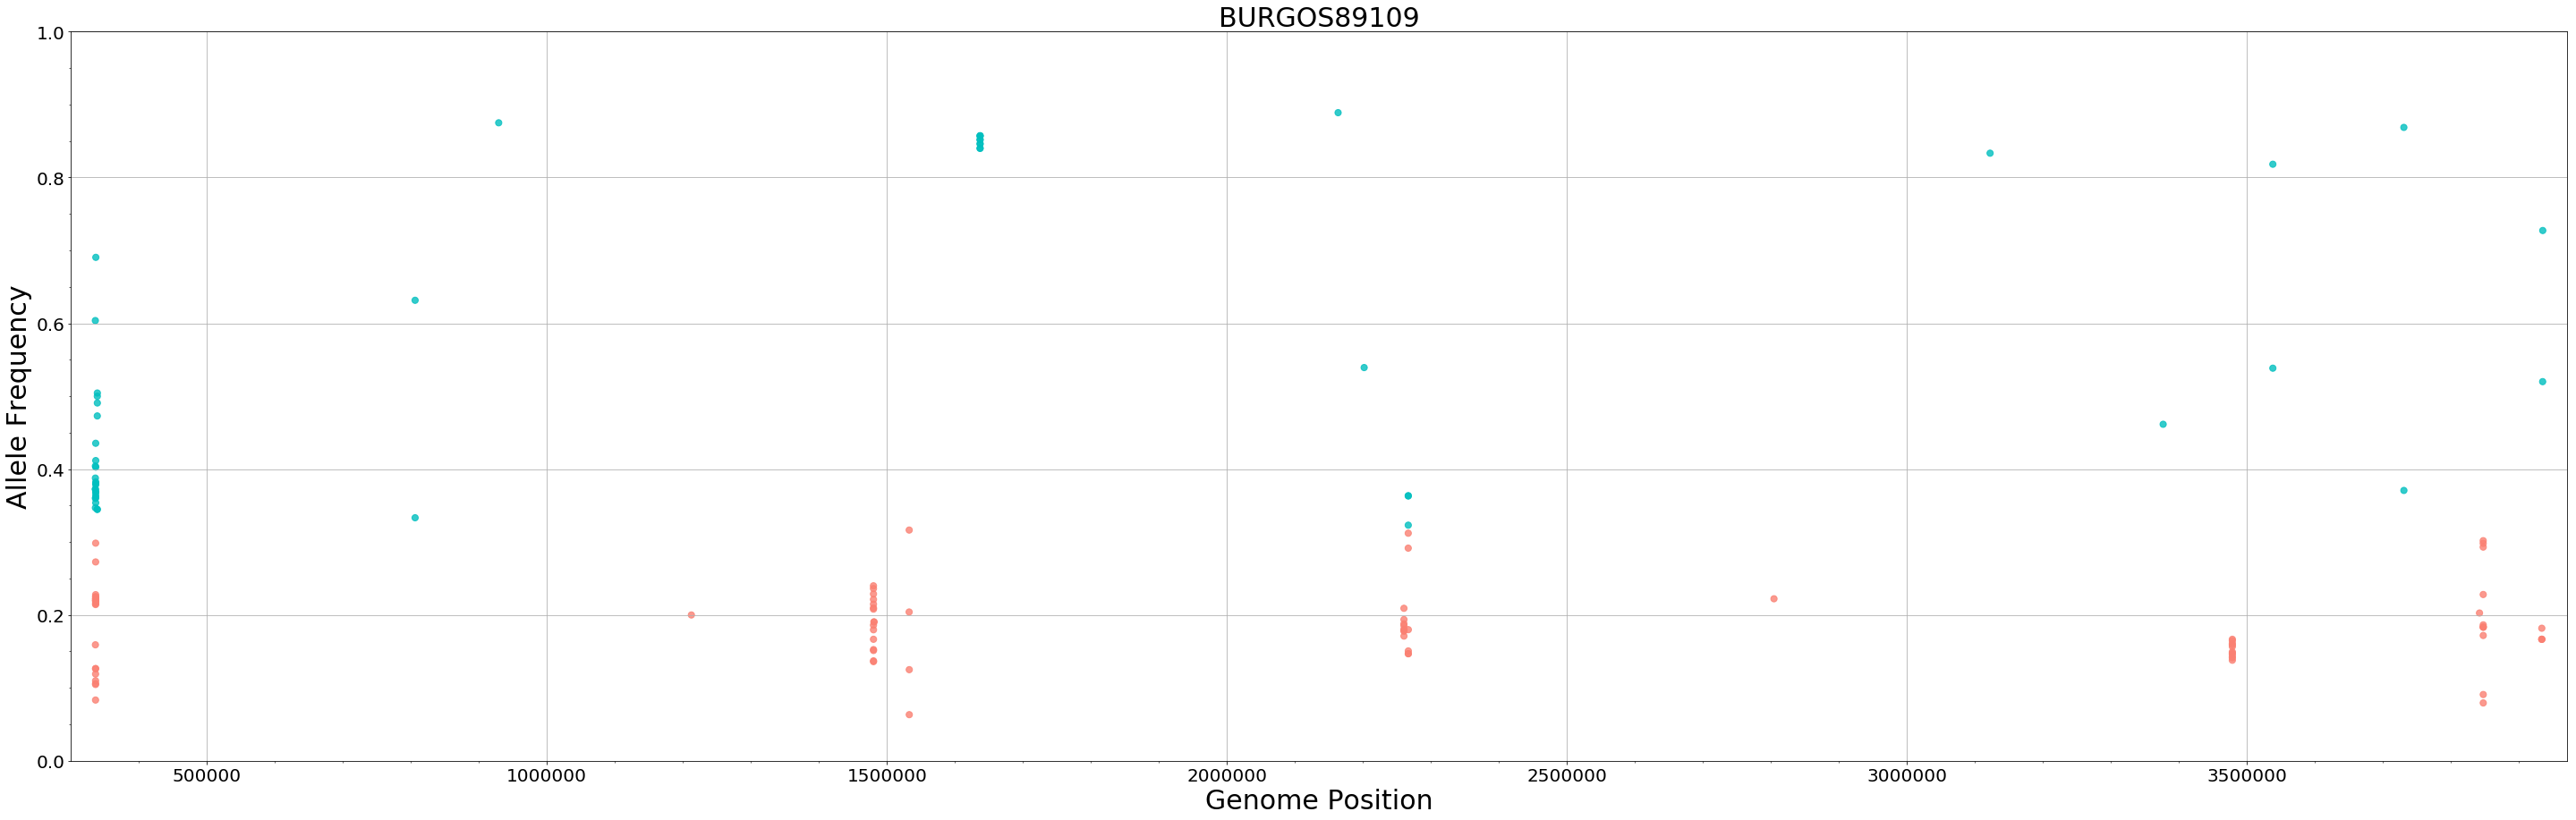

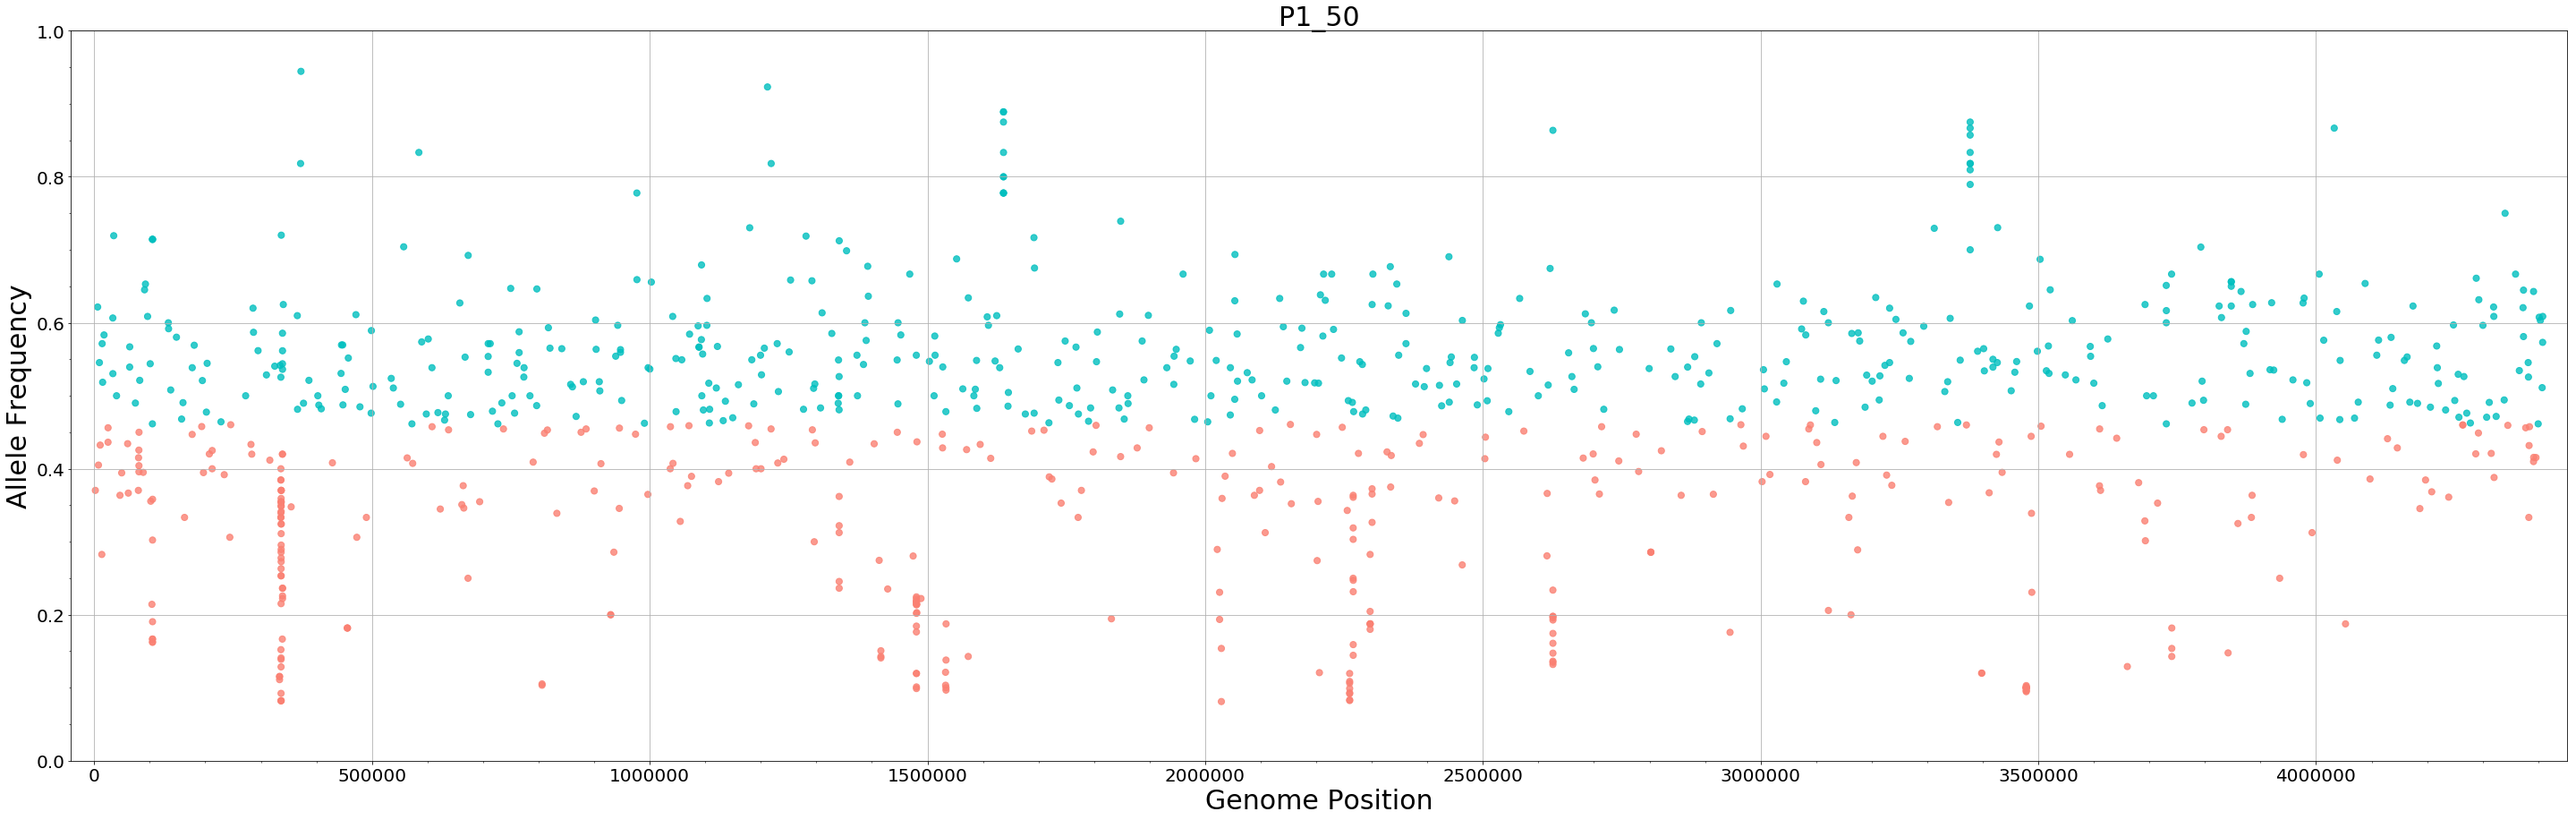

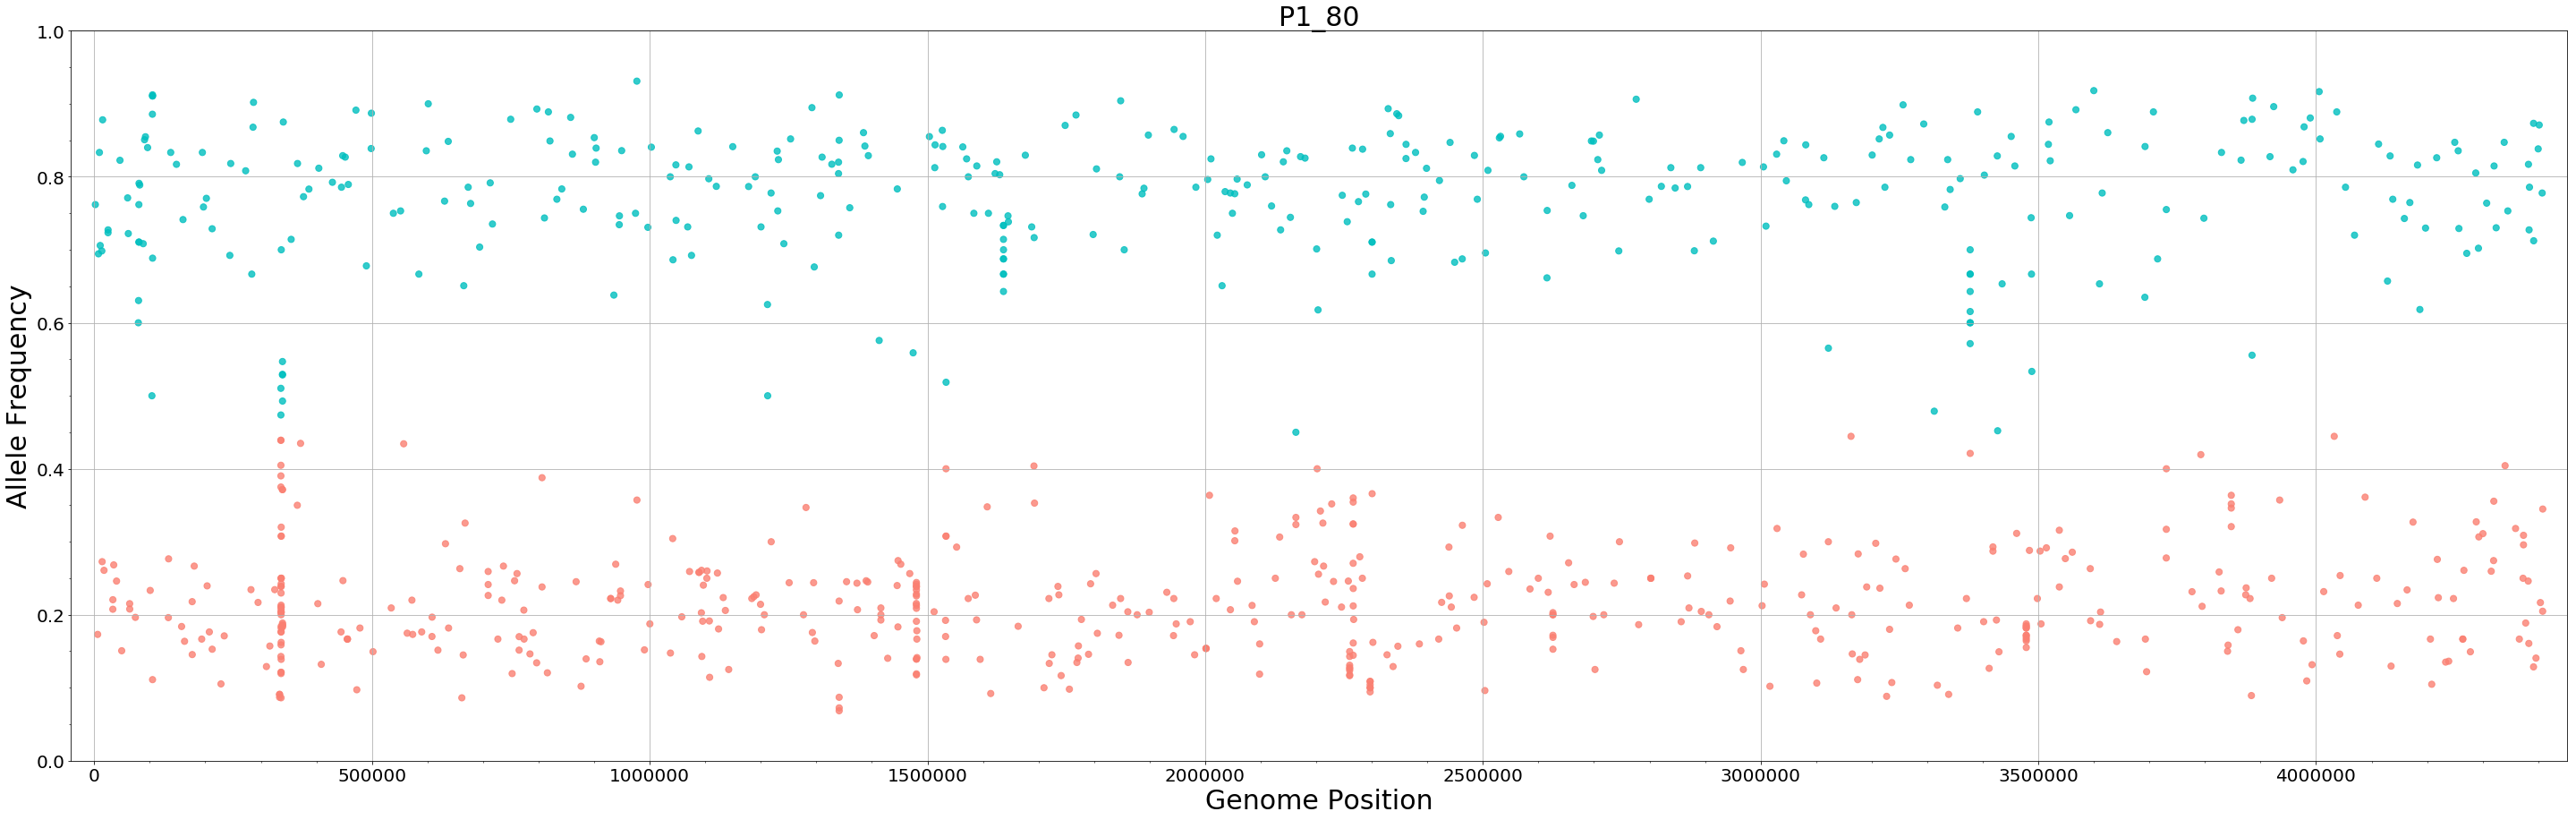

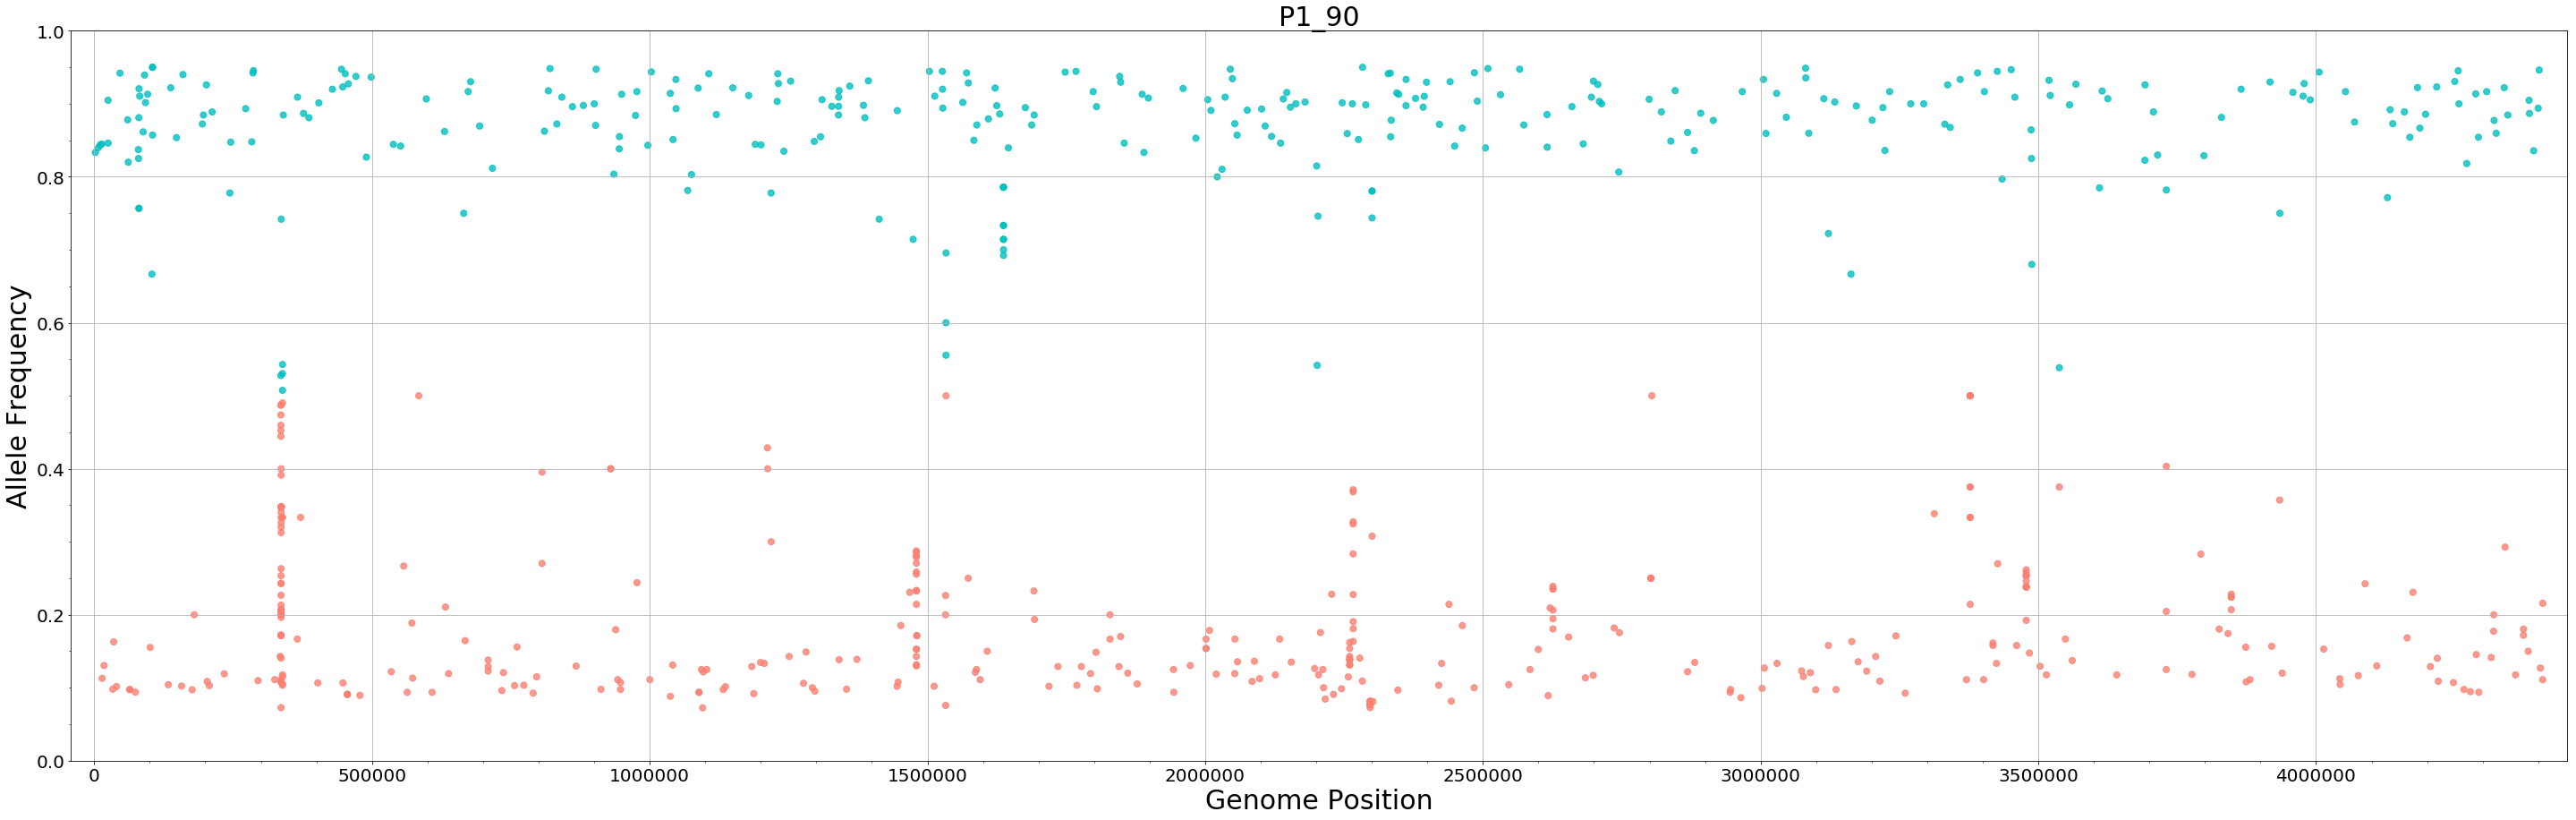

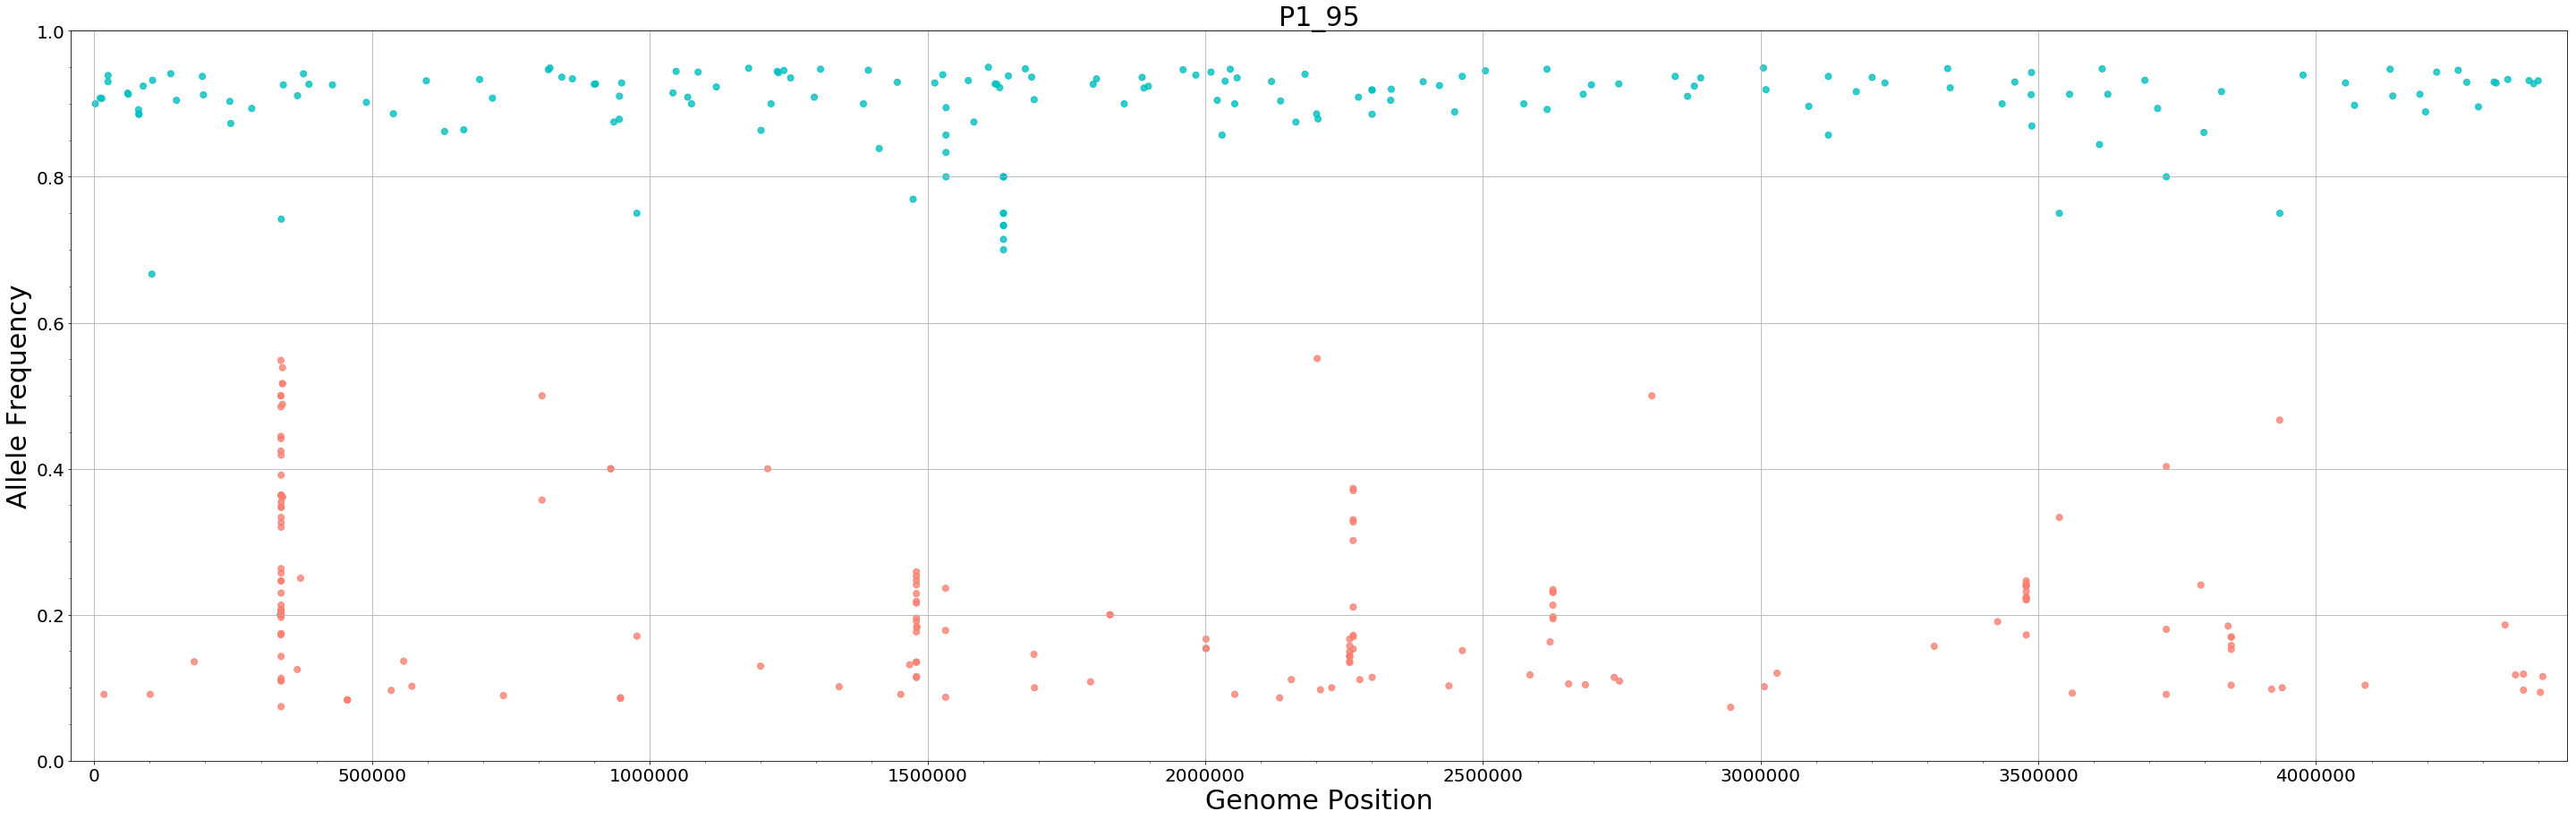

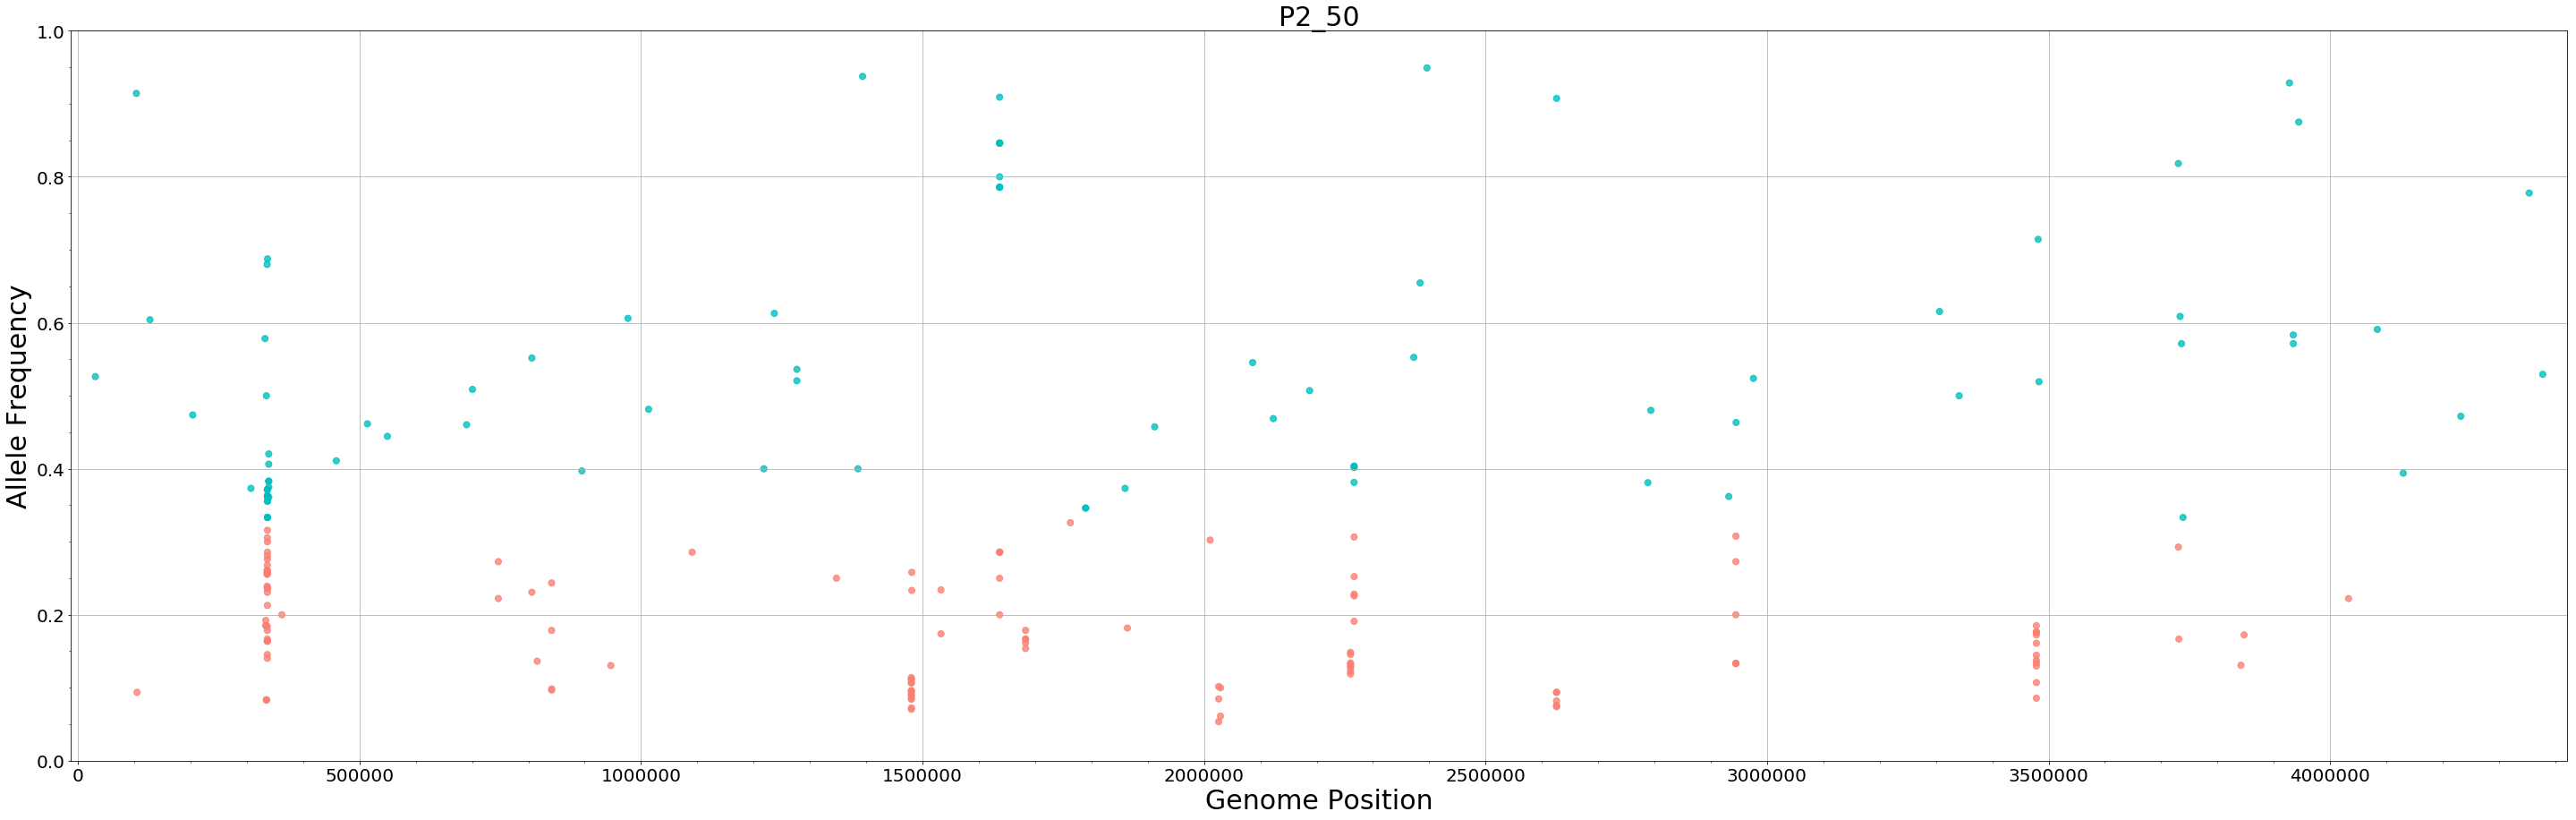

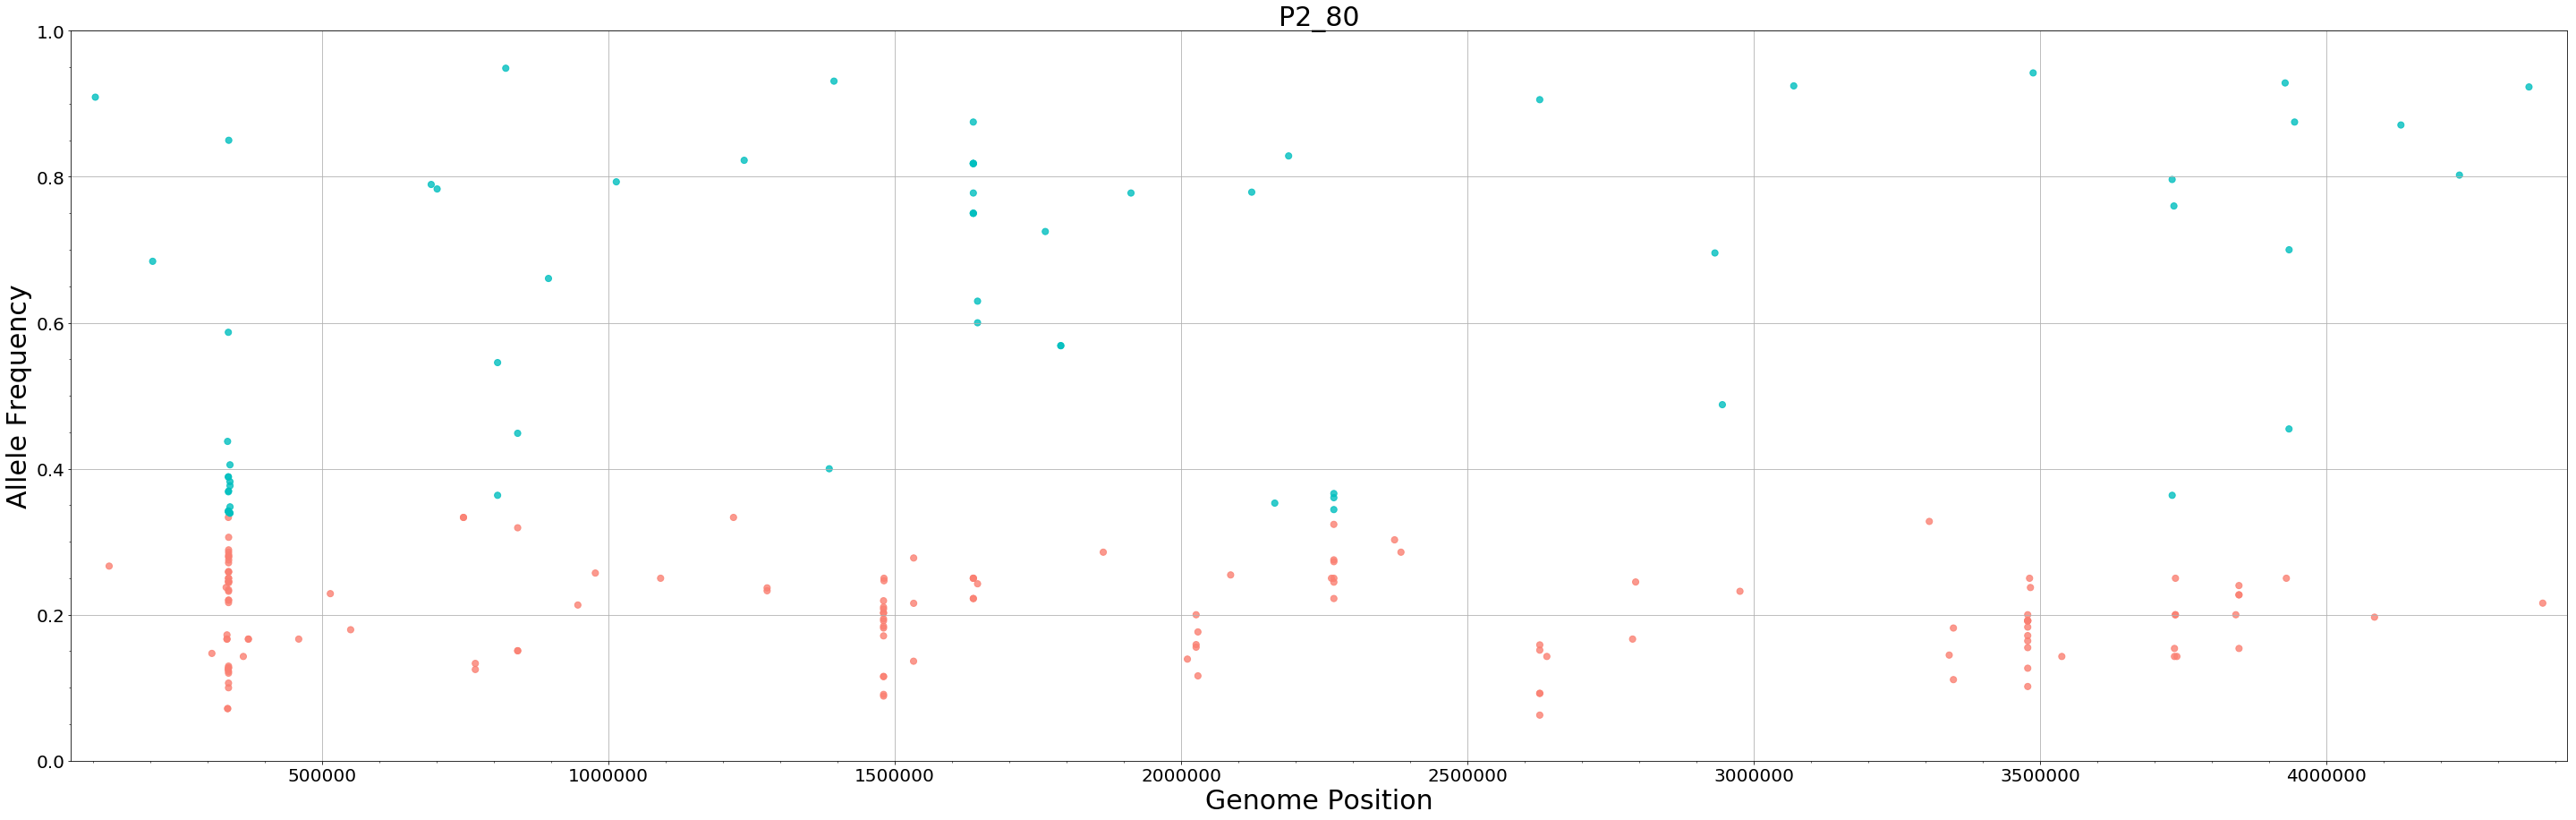

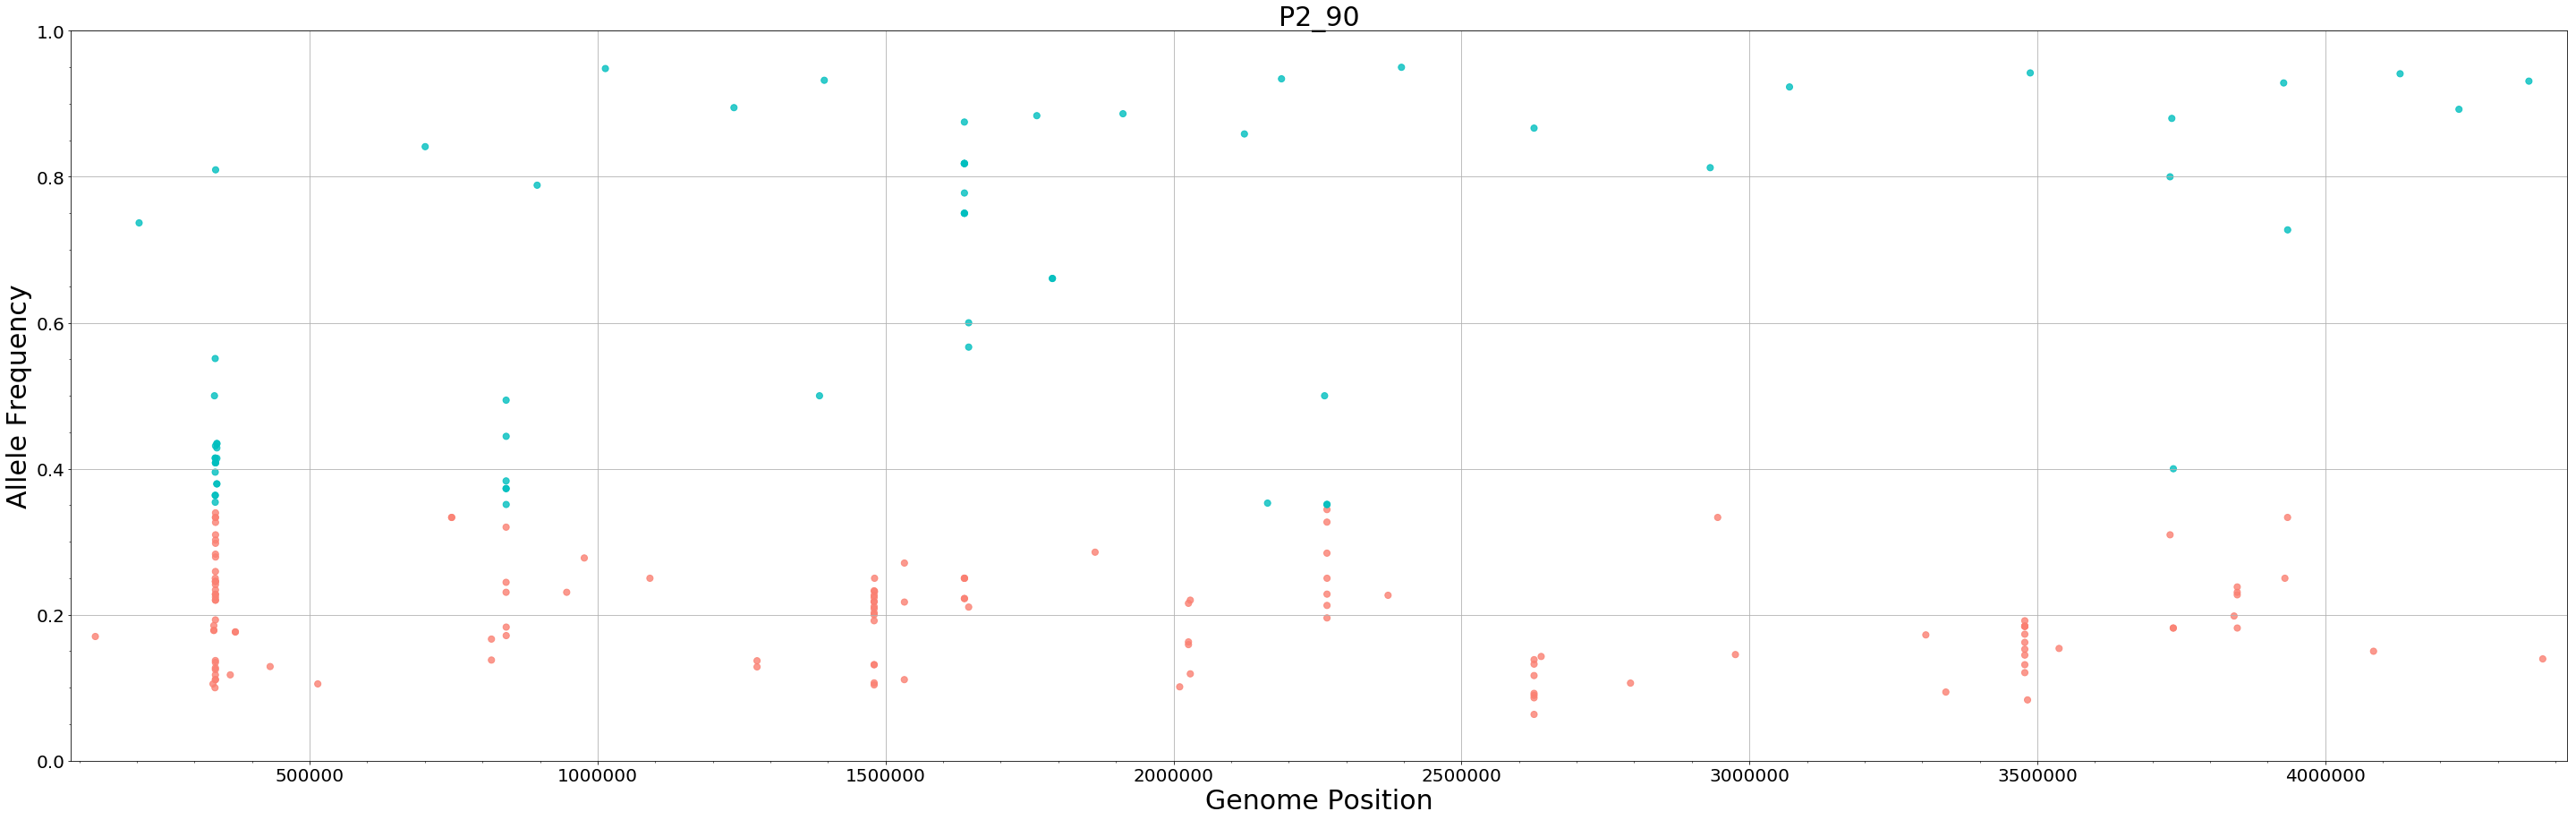

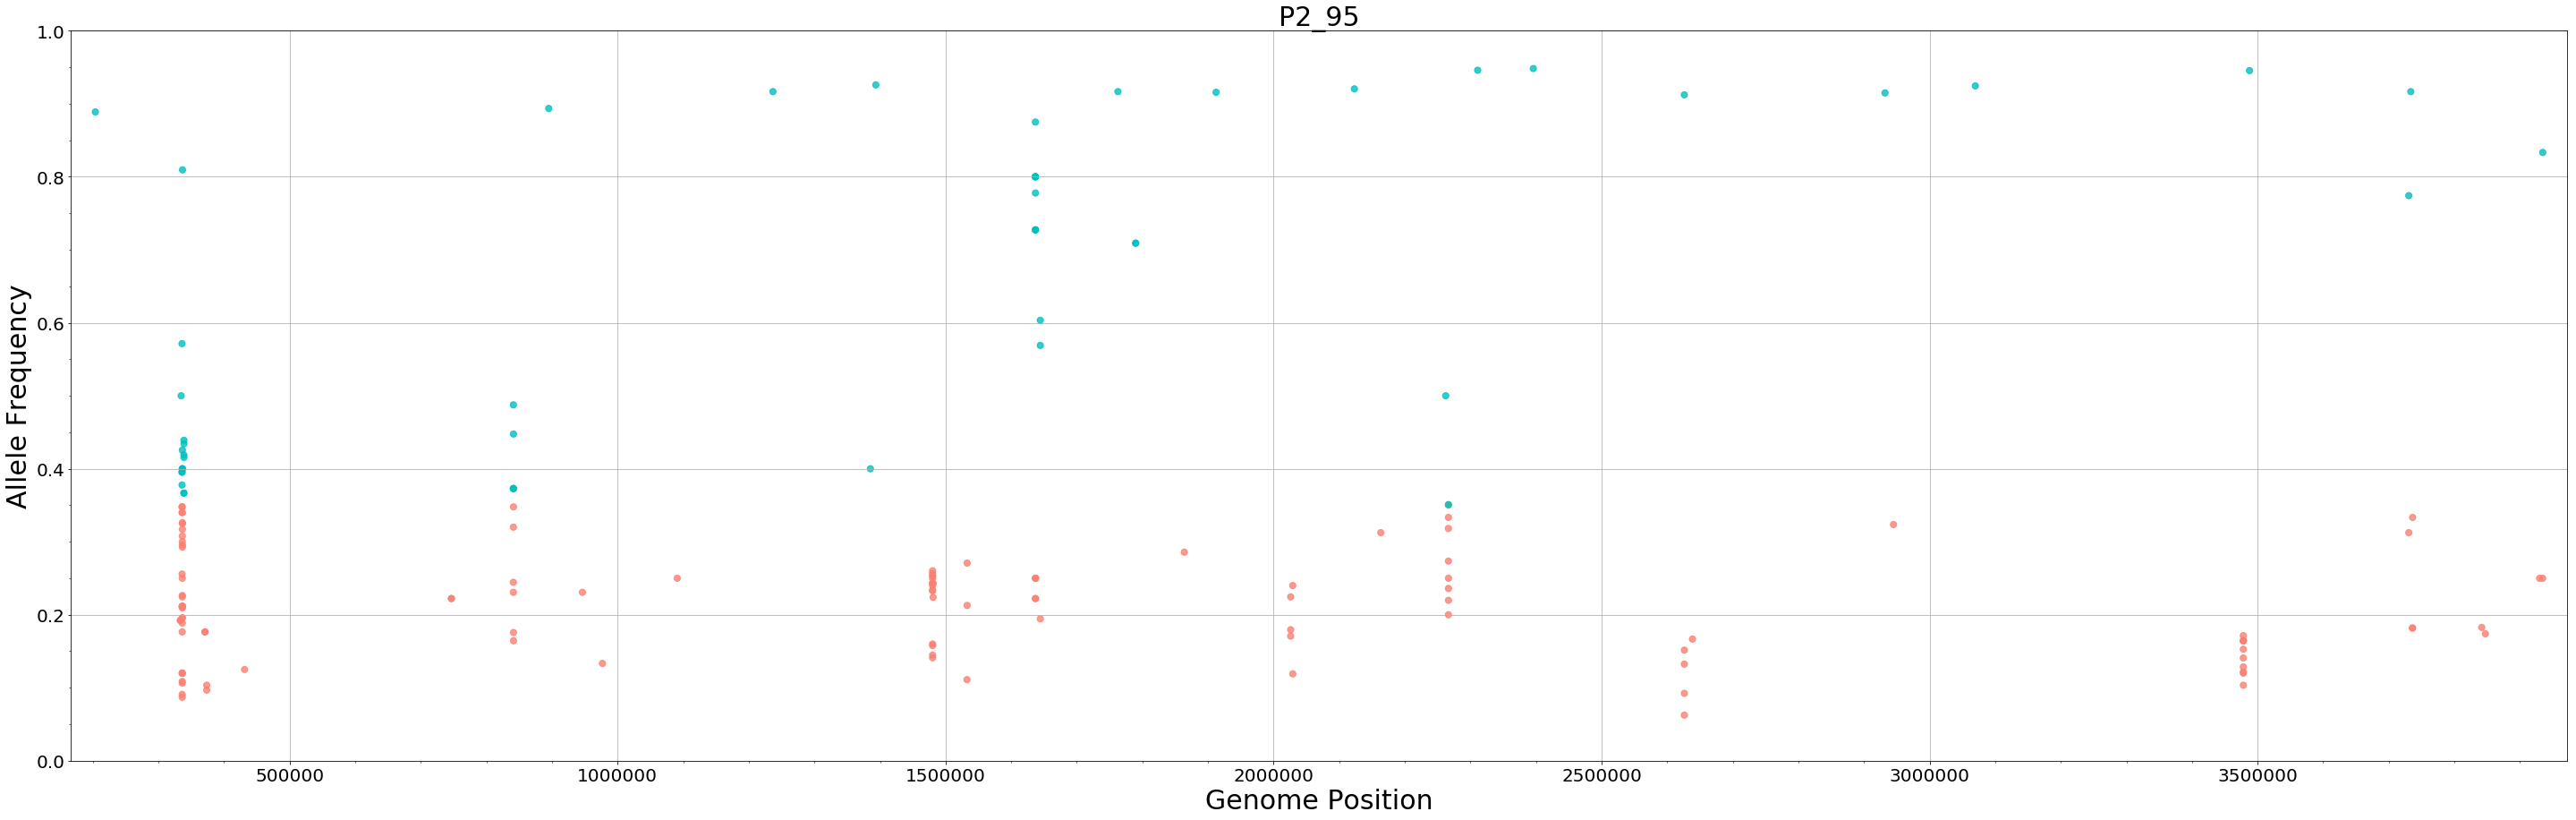

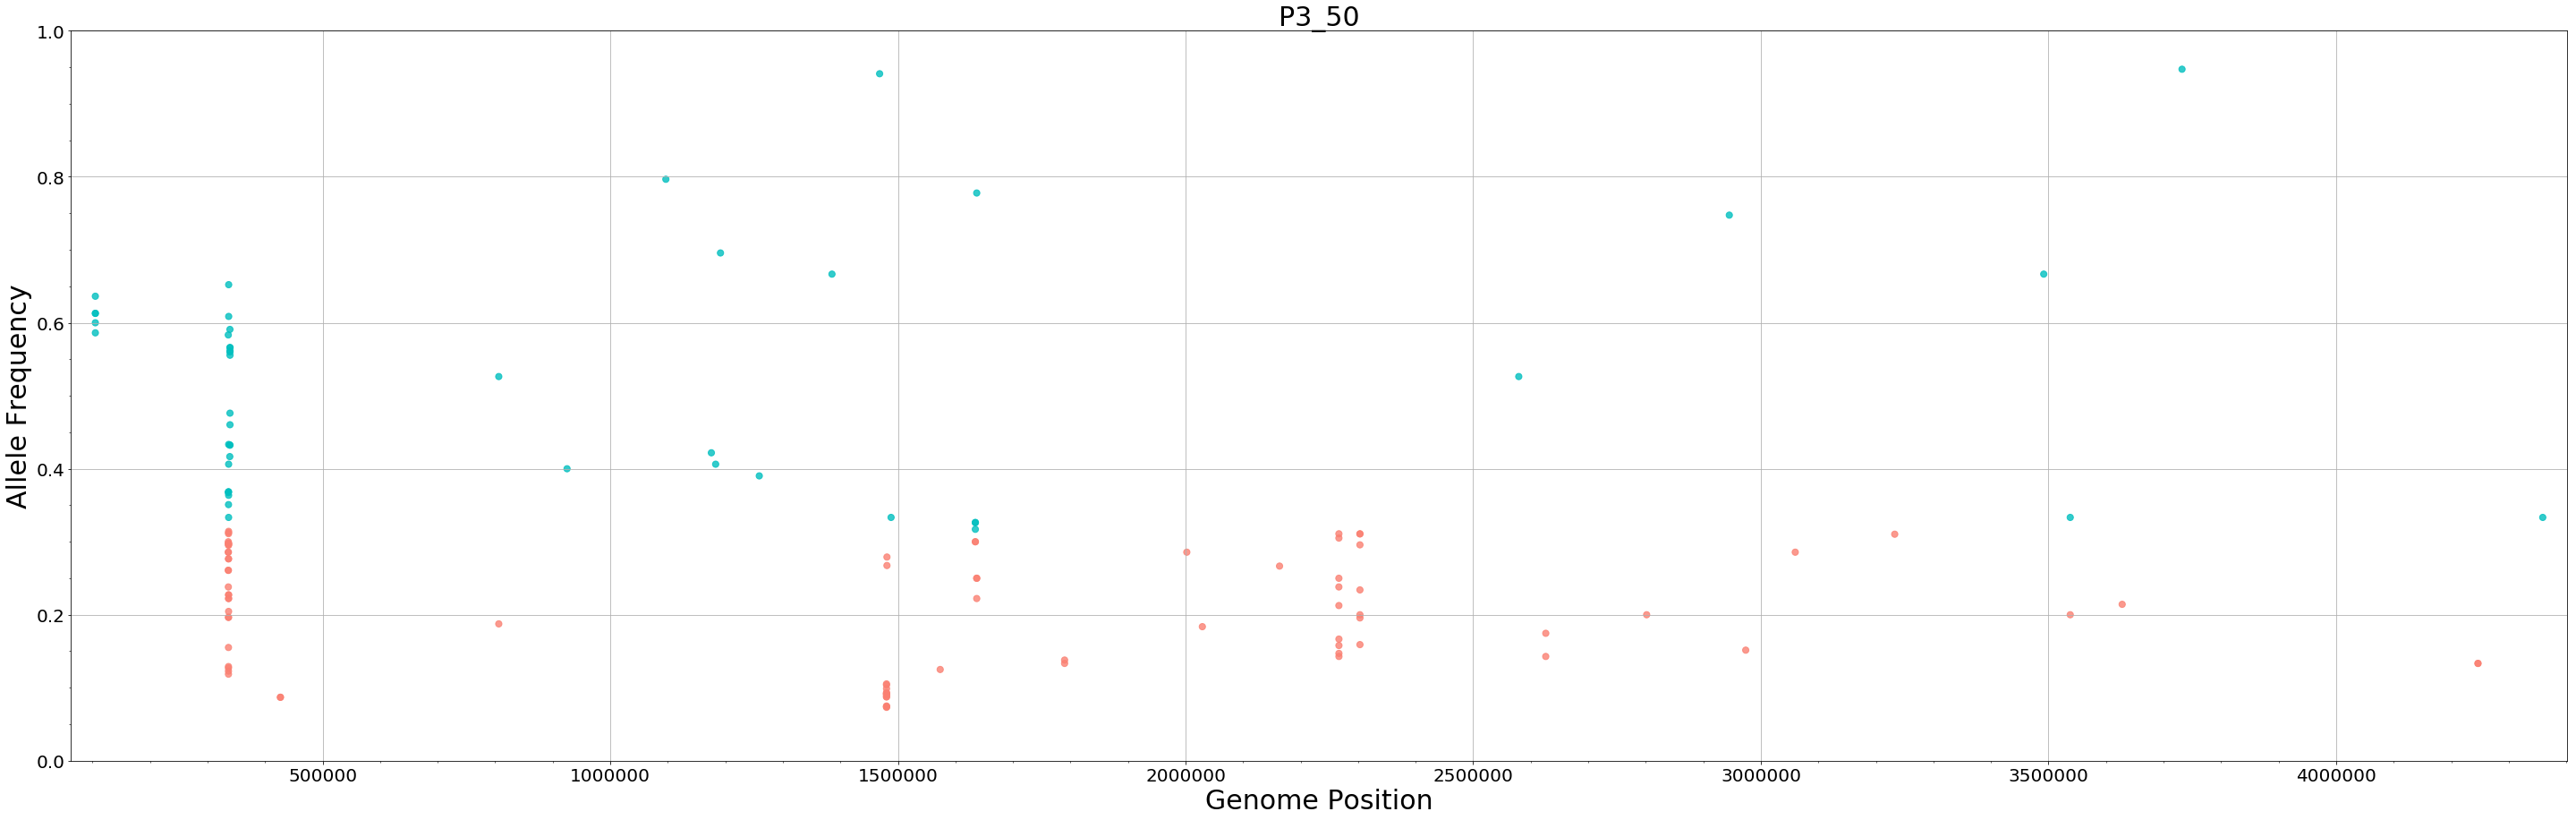

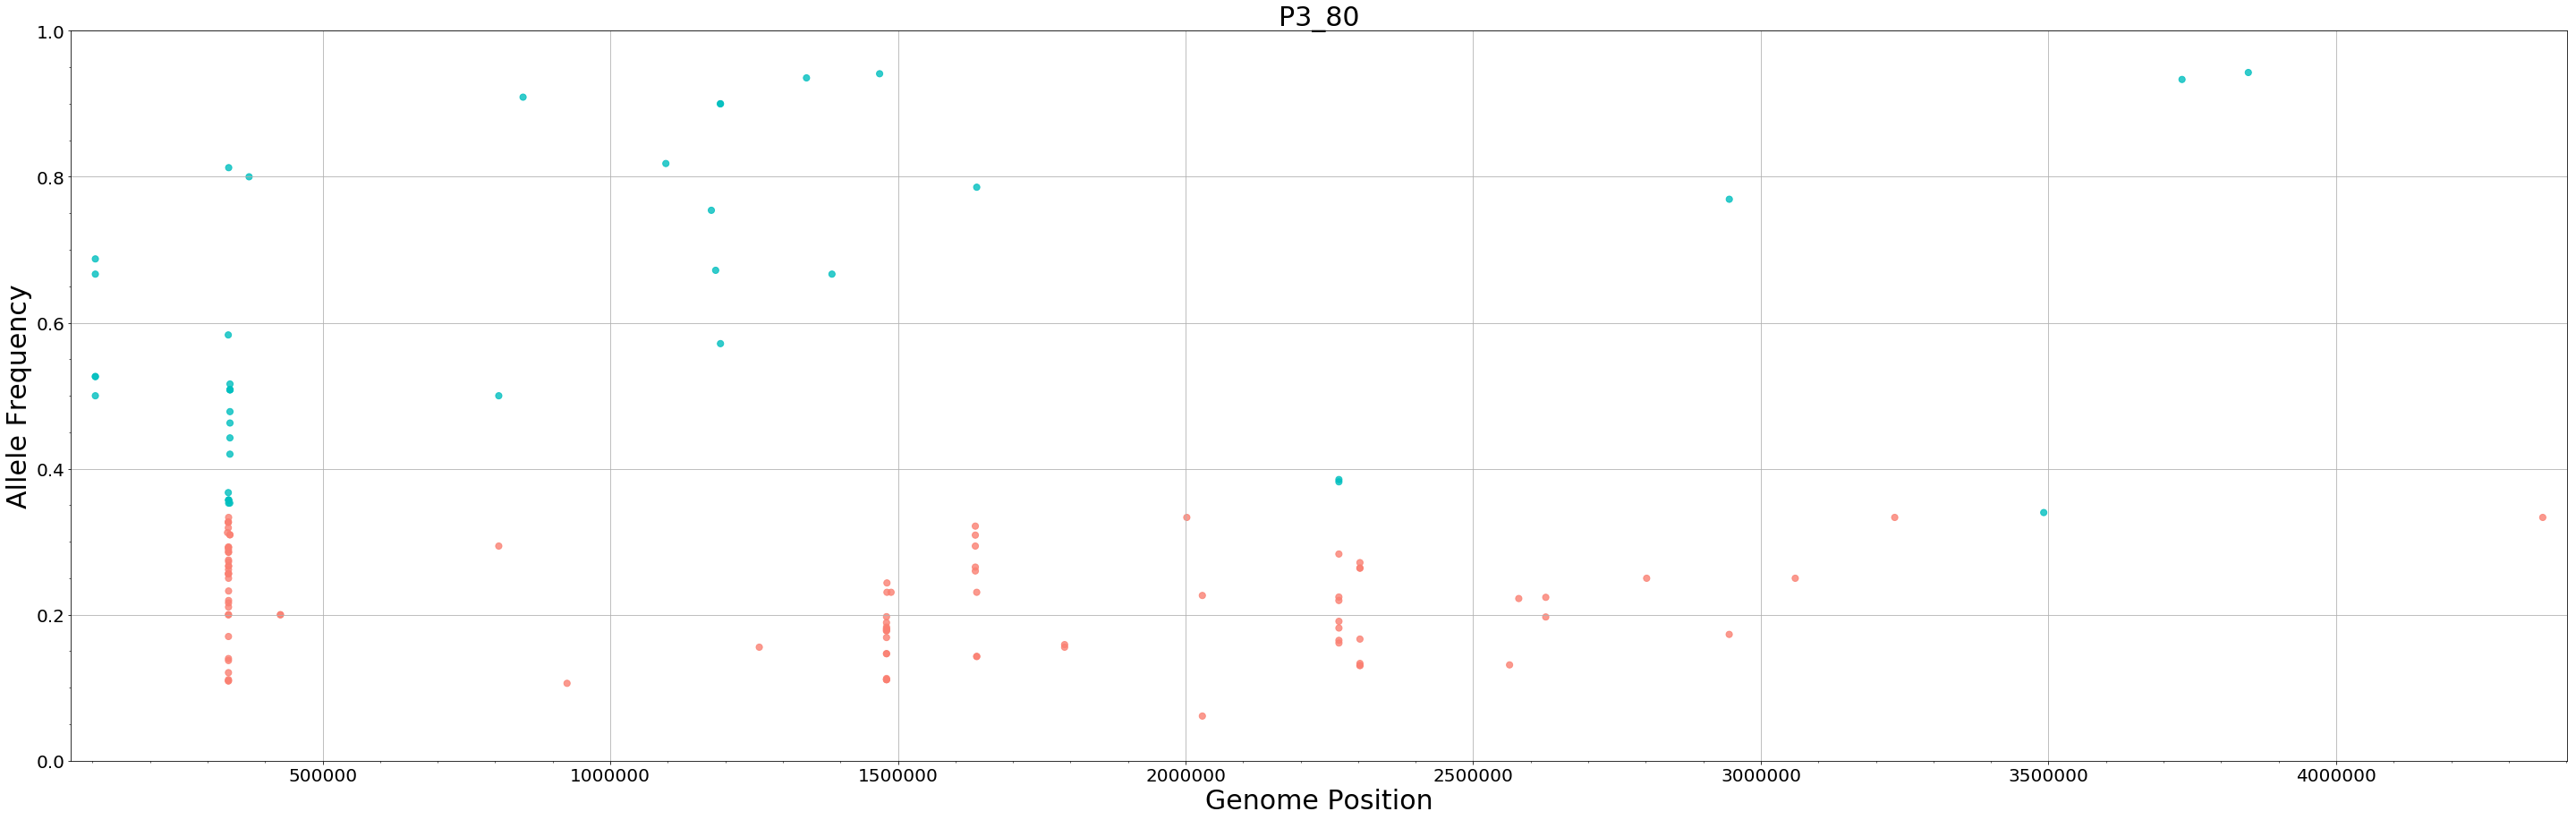

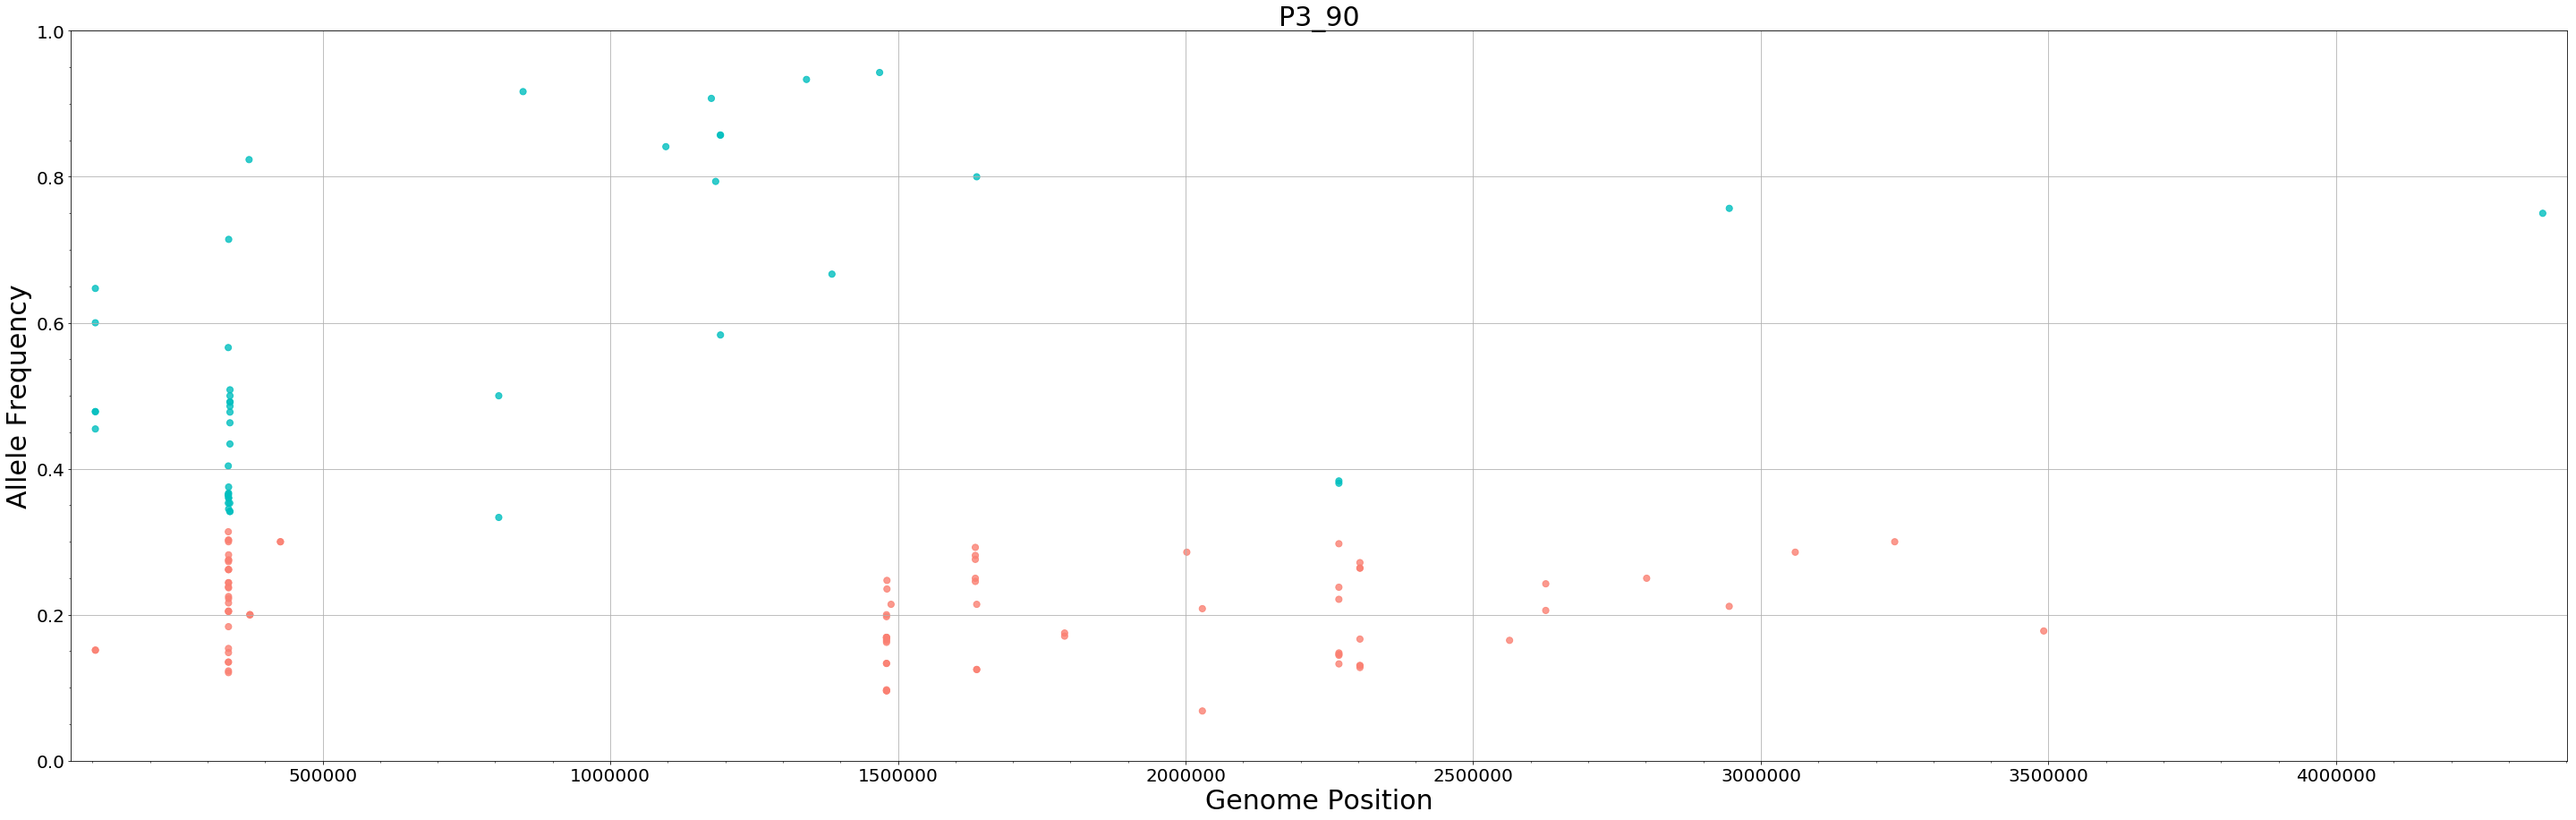

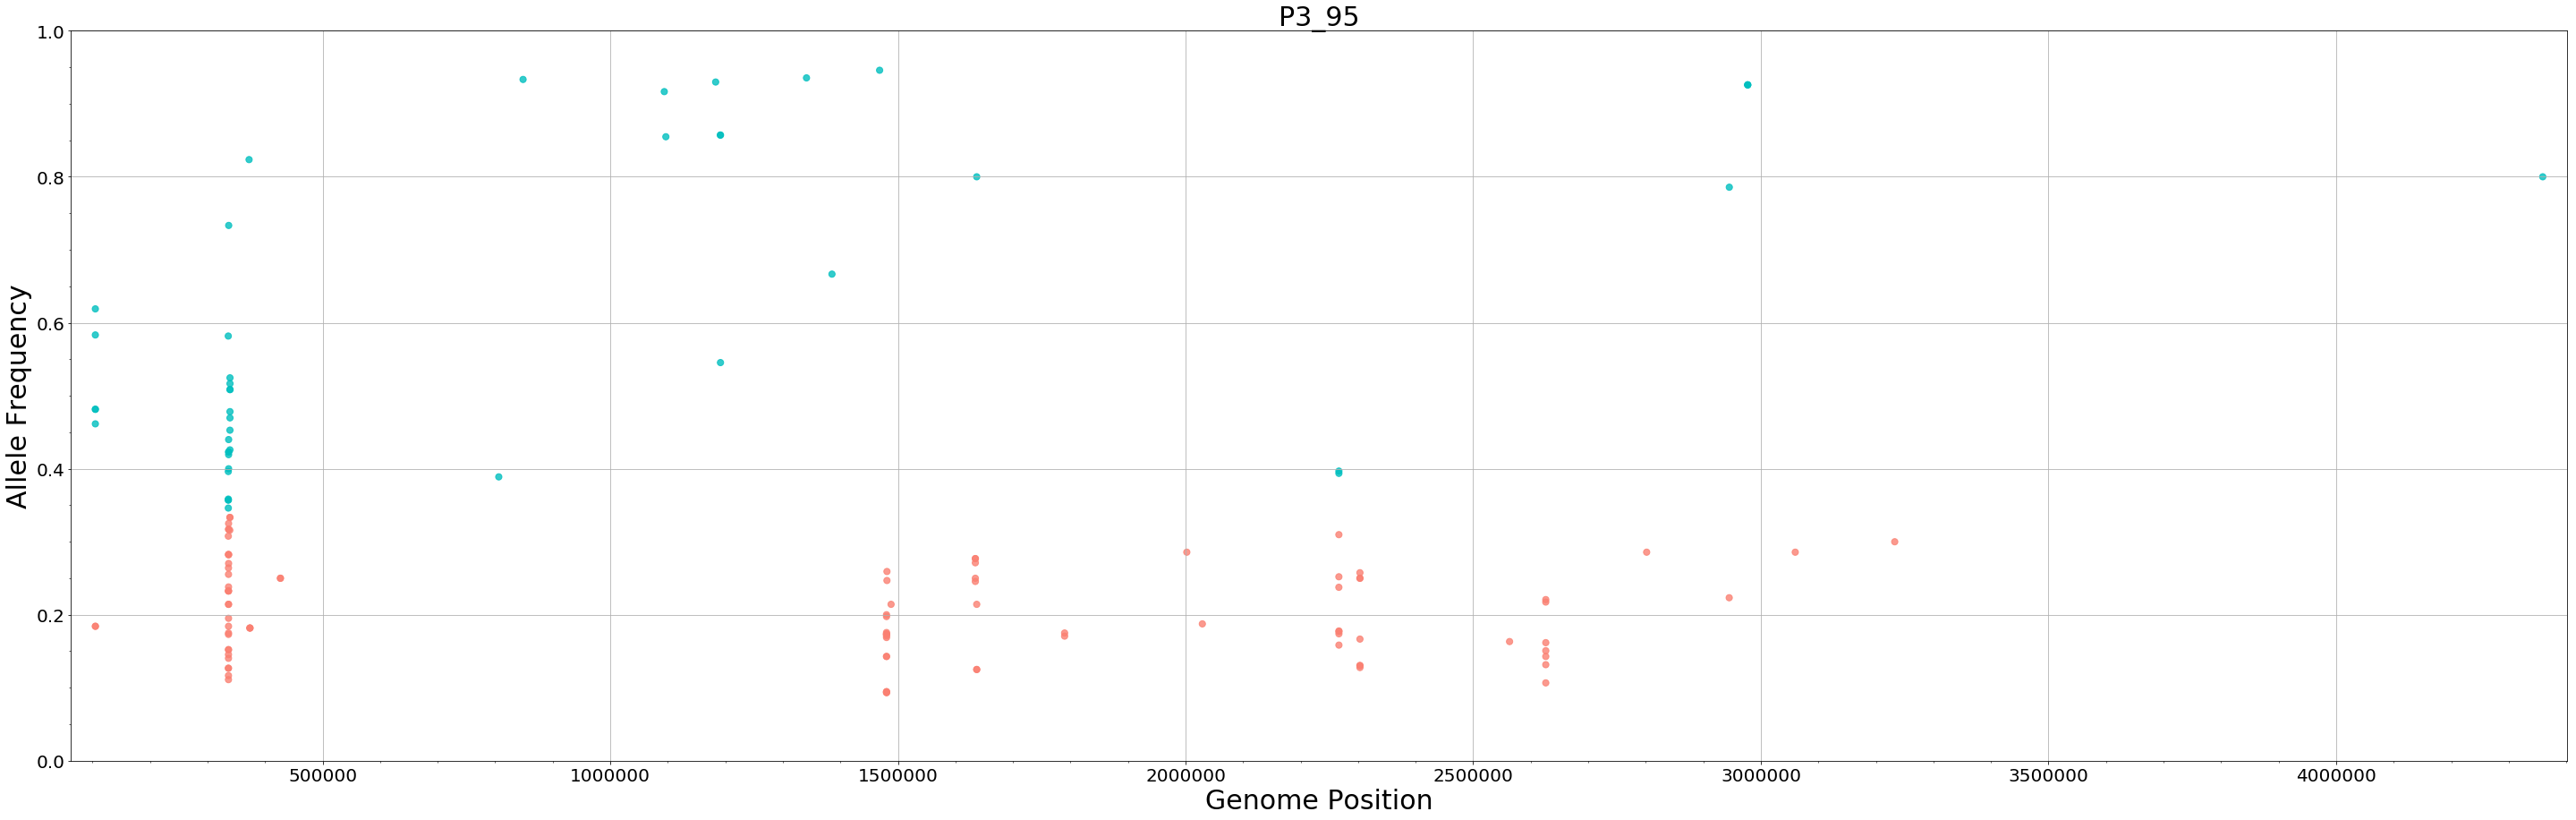

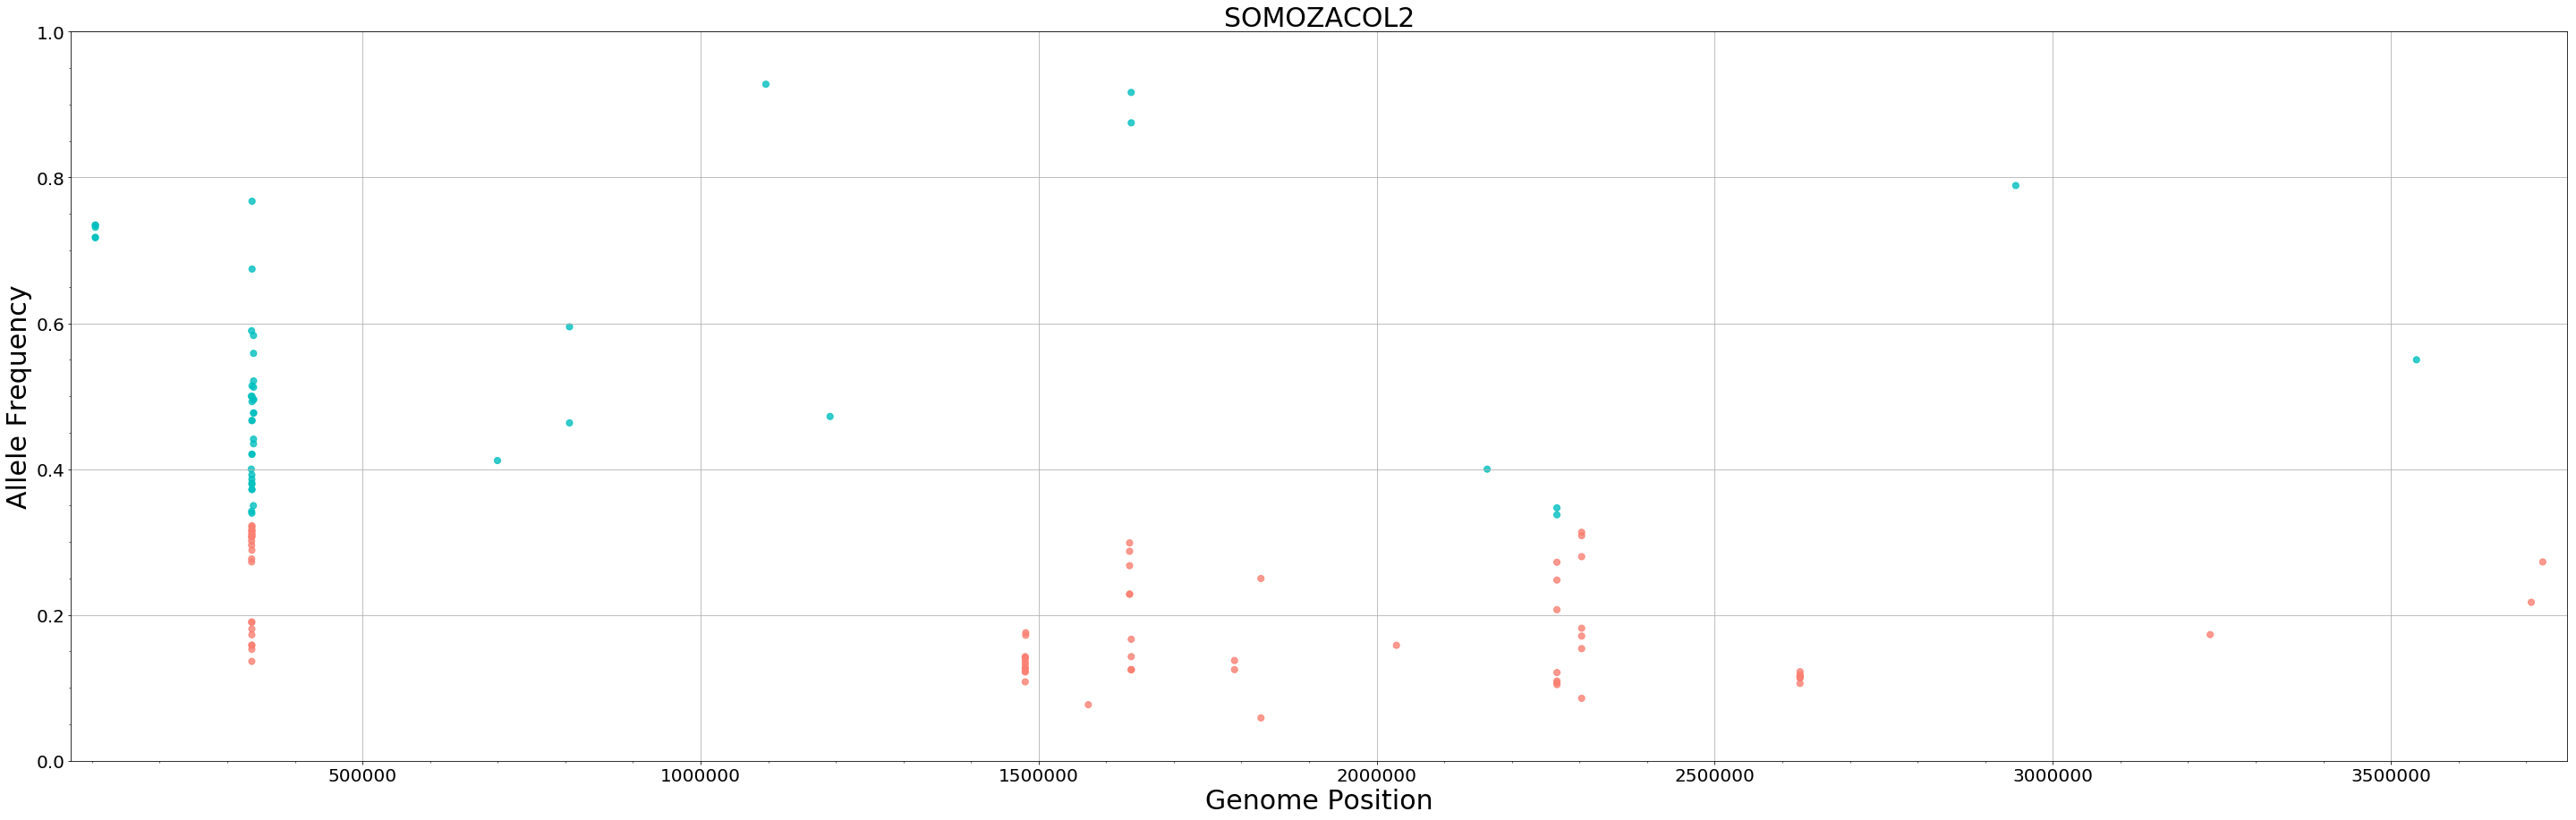

In [12]:
for name_dsf, df in dict_vcf.items():
    scatter_vcf_pos(df,name_dsf)

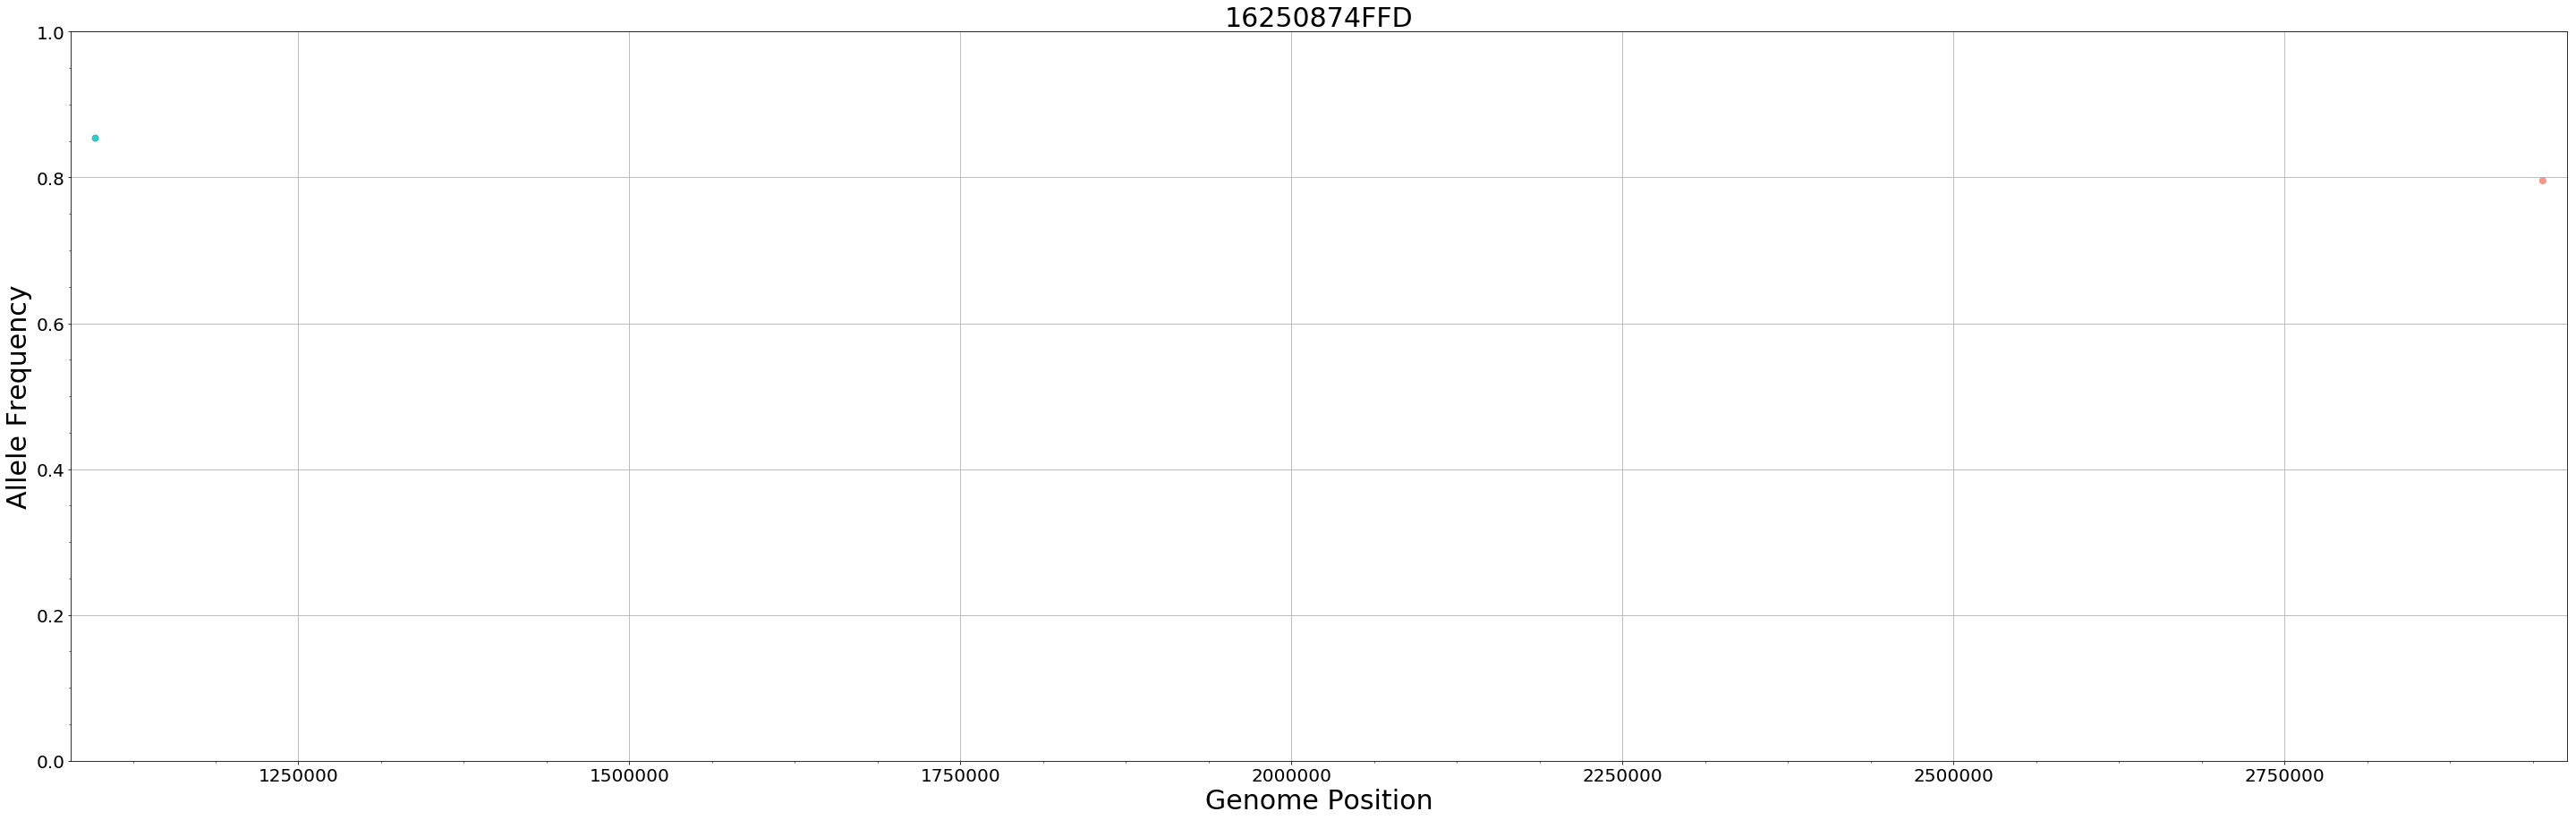

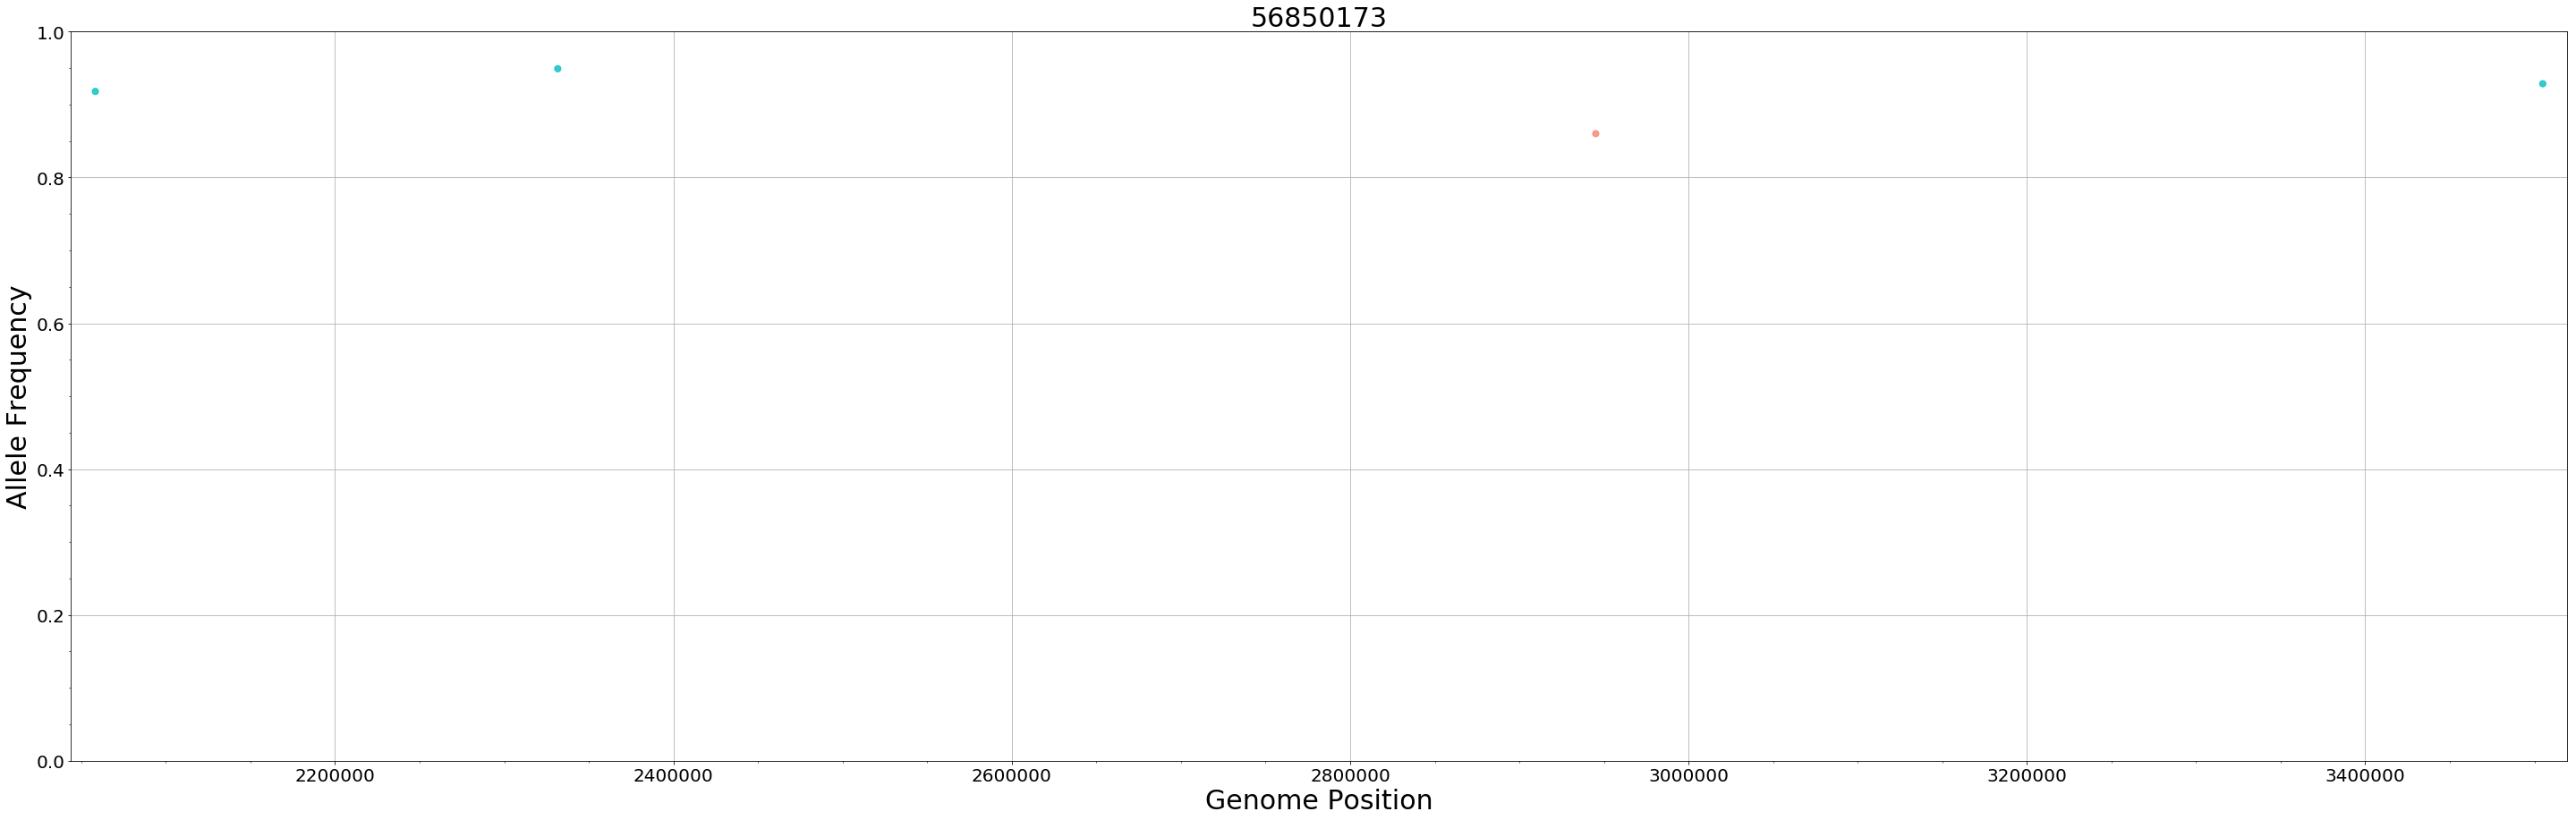

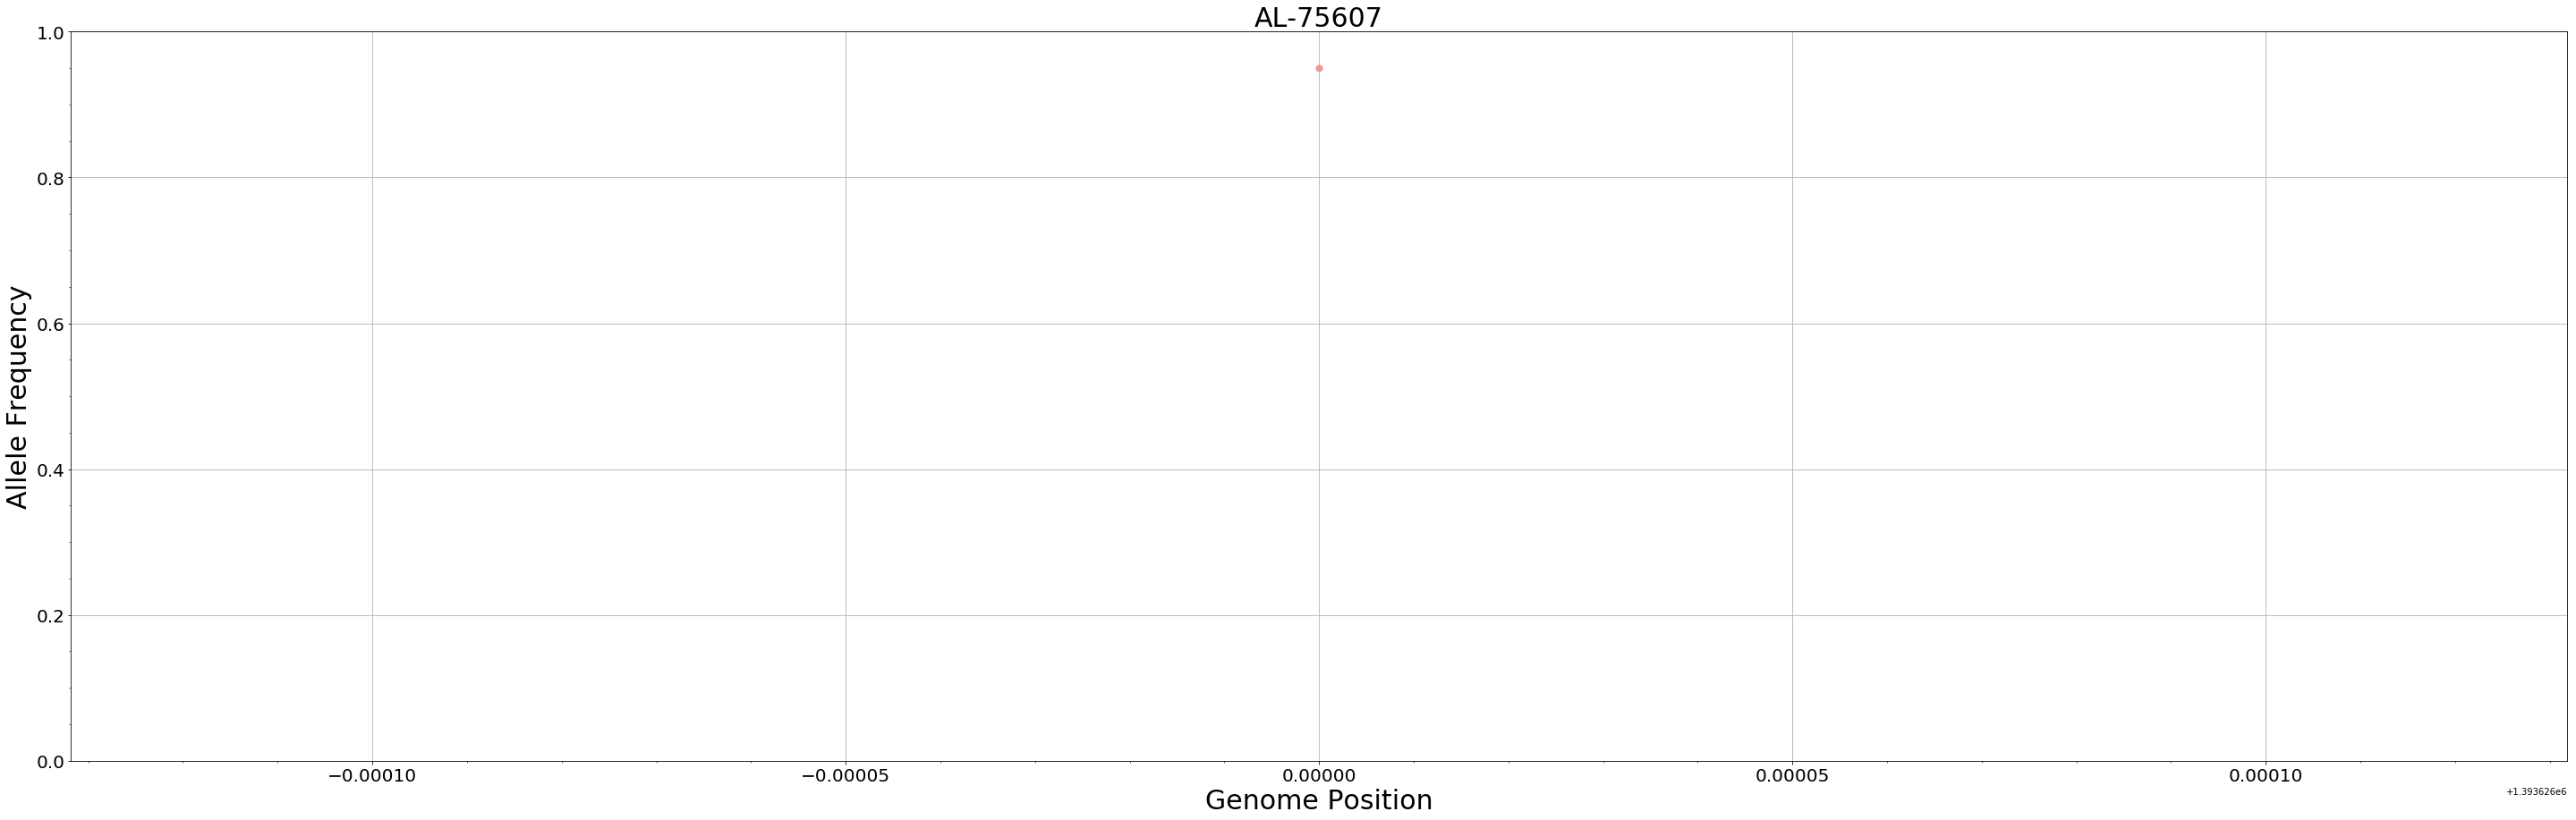

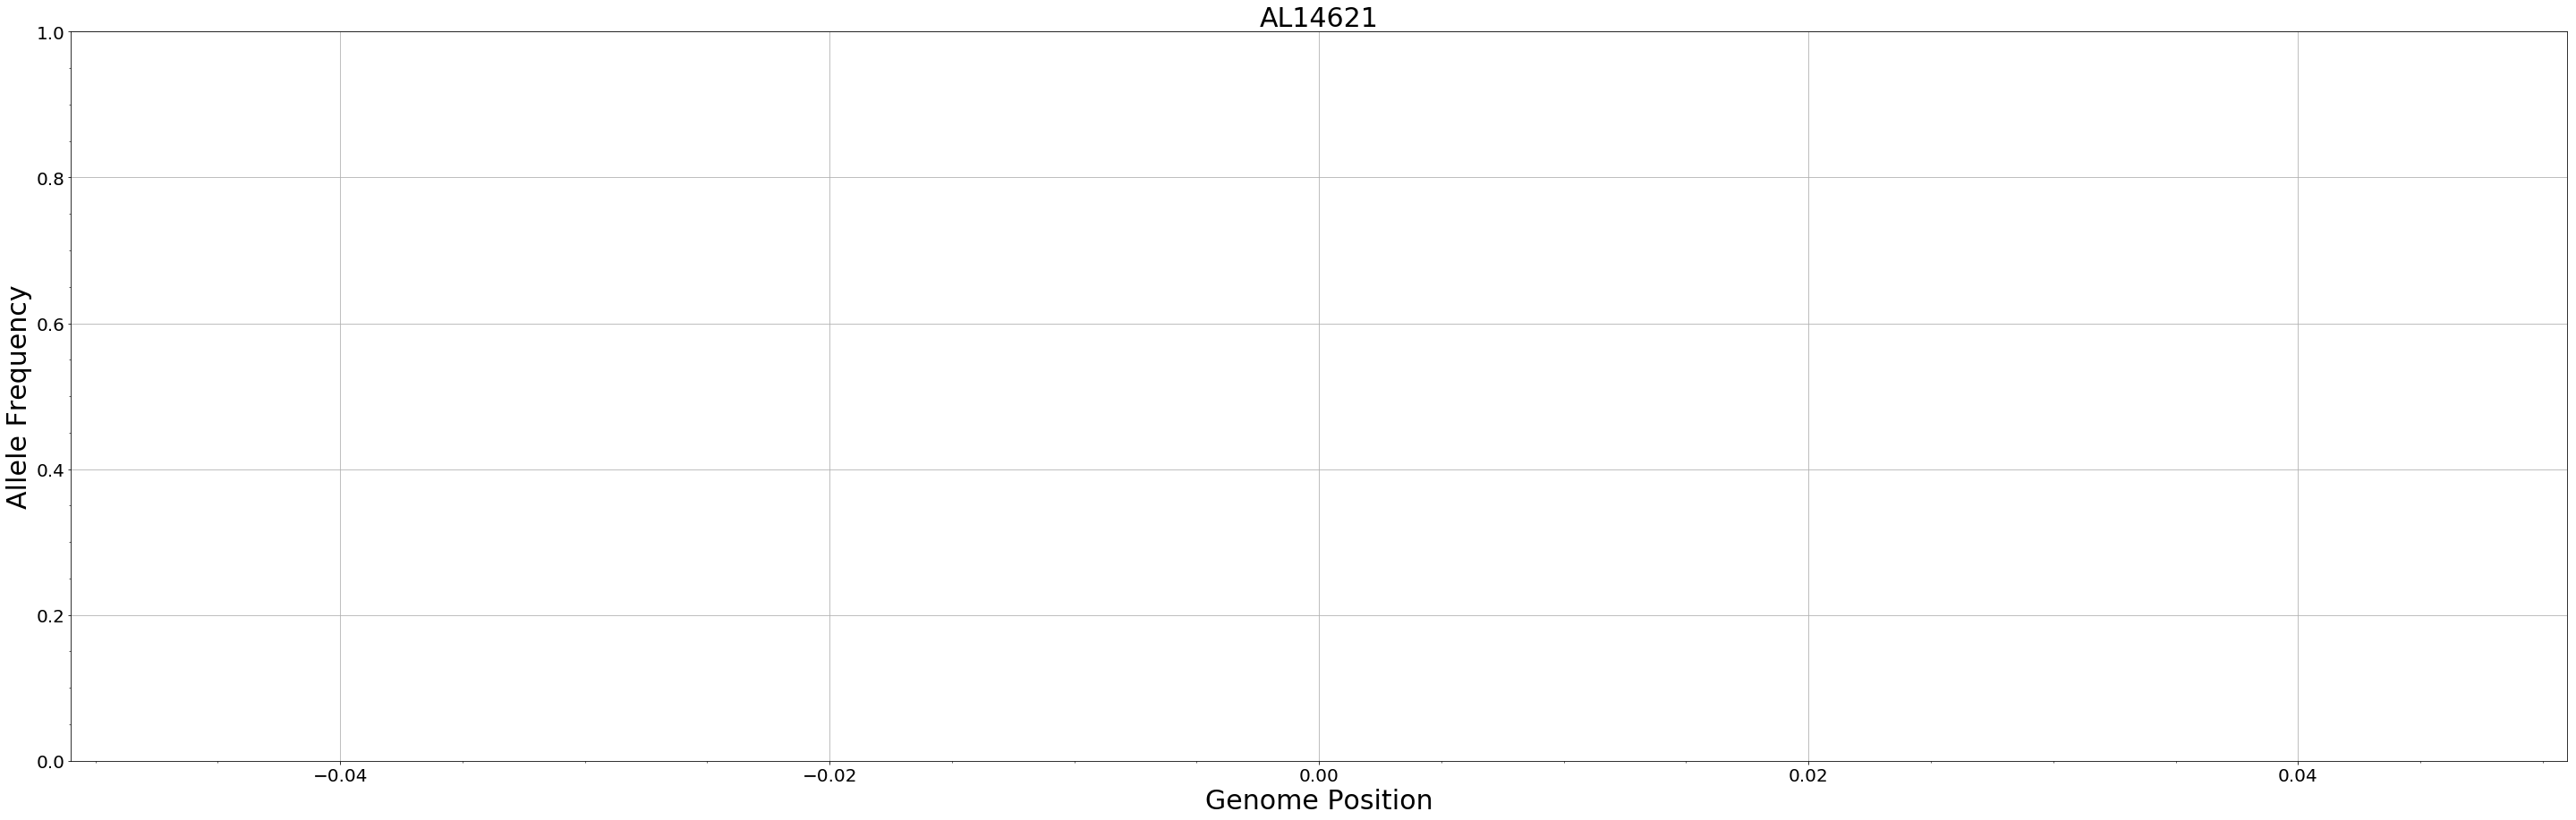

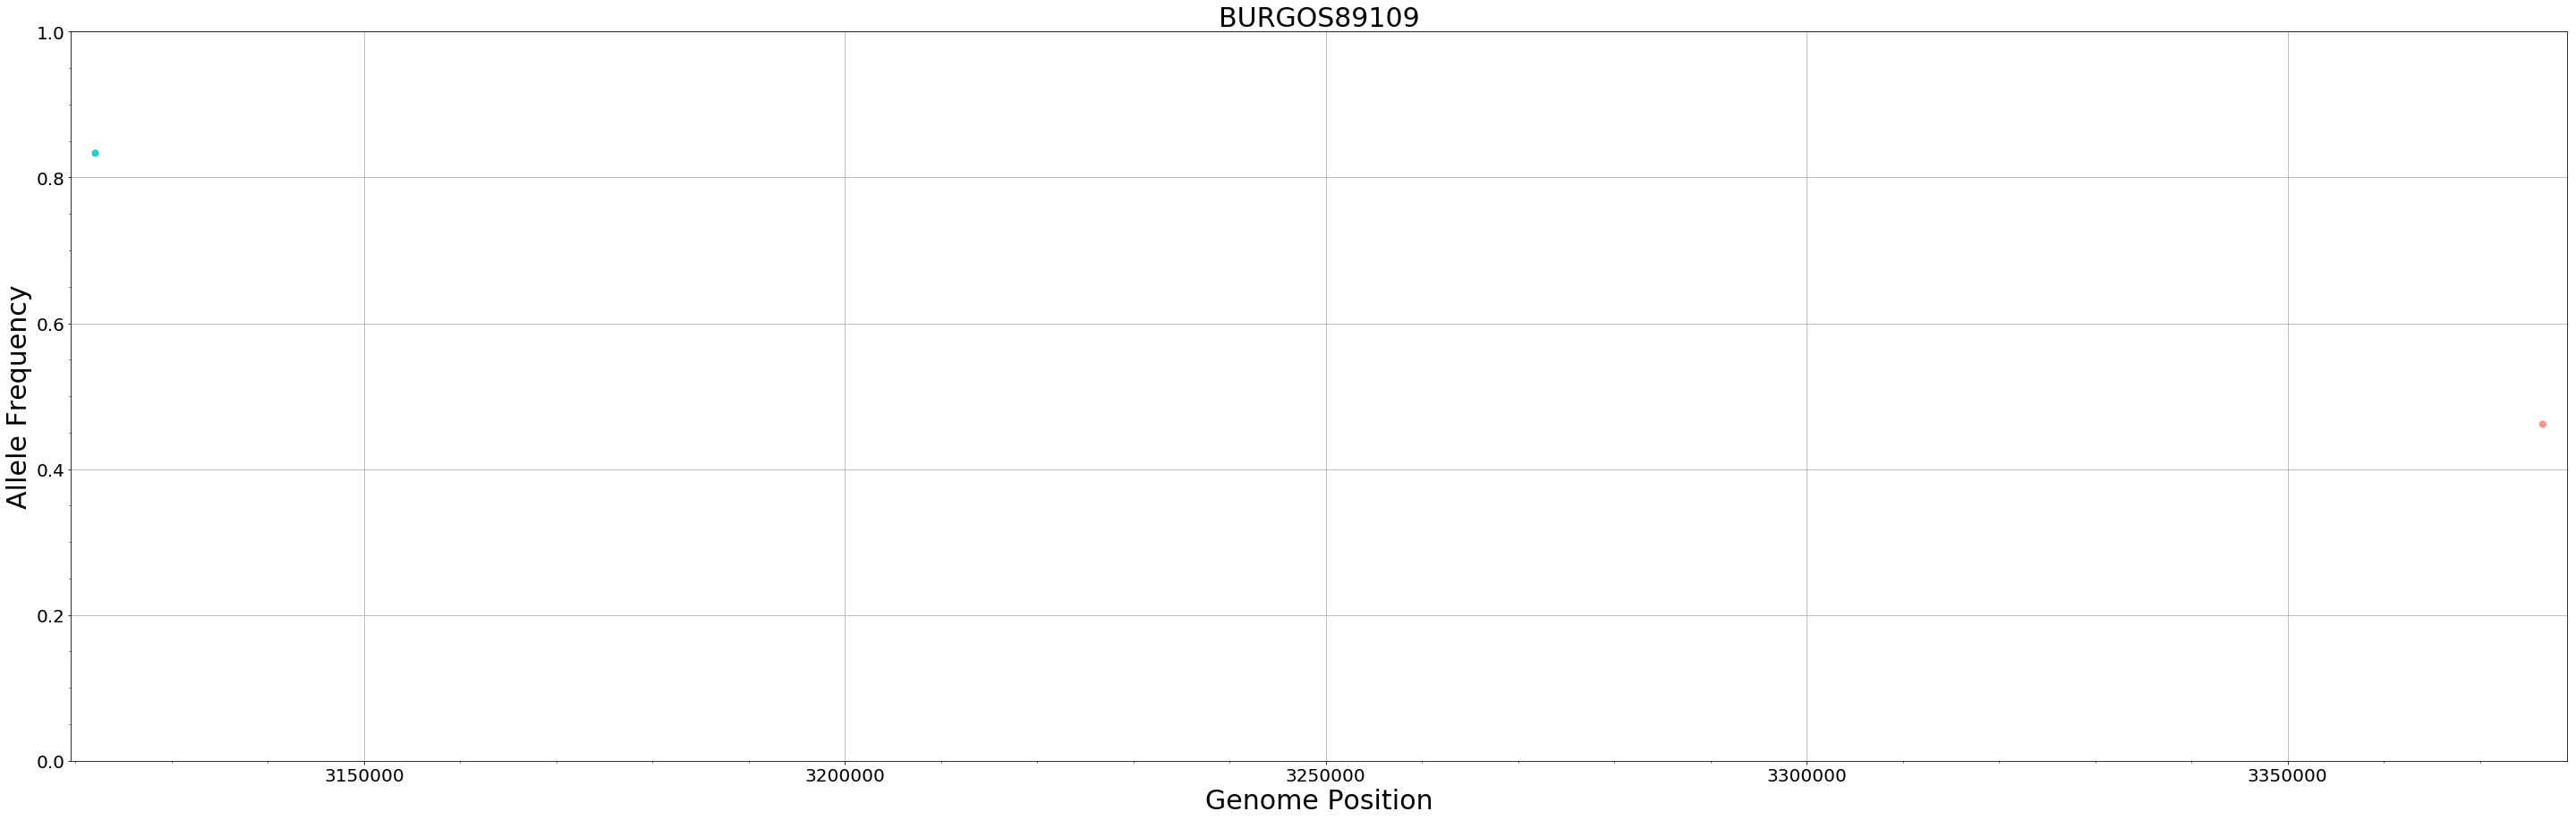

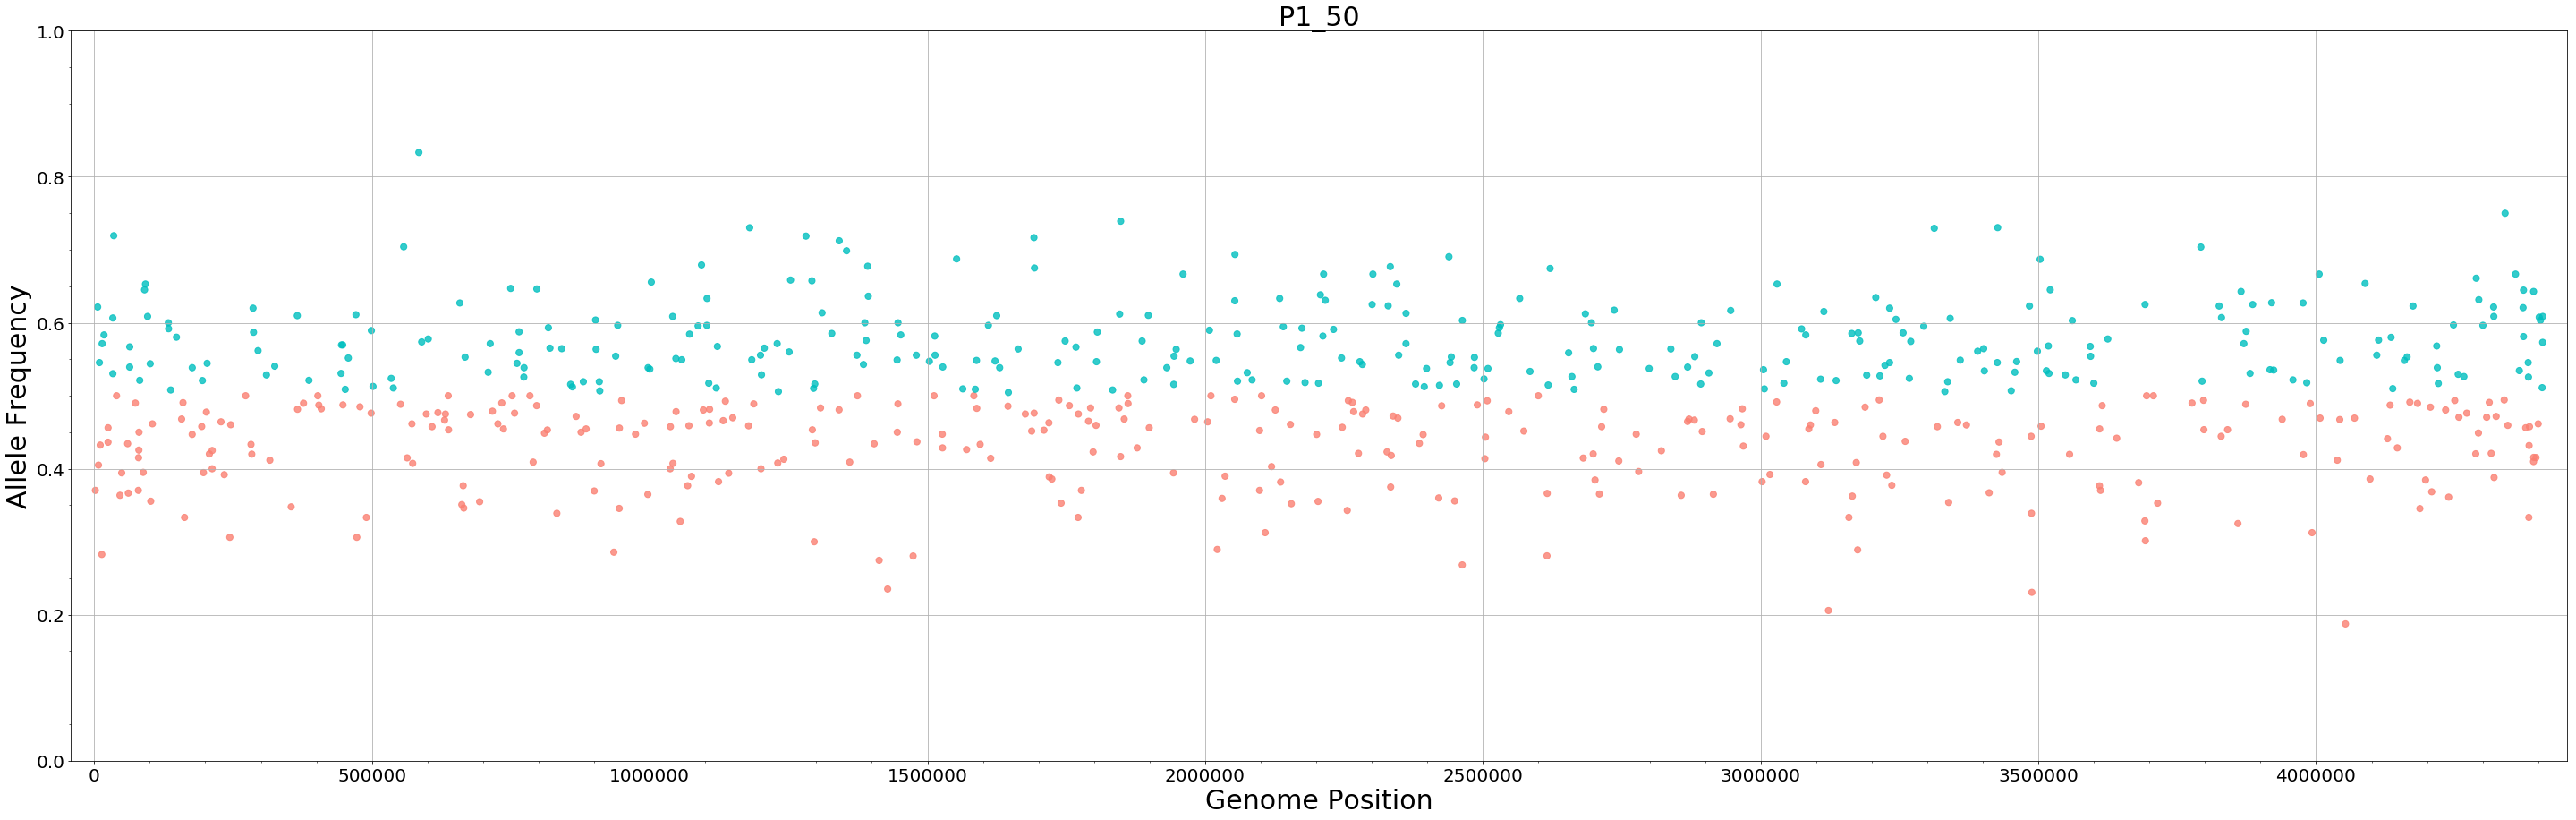

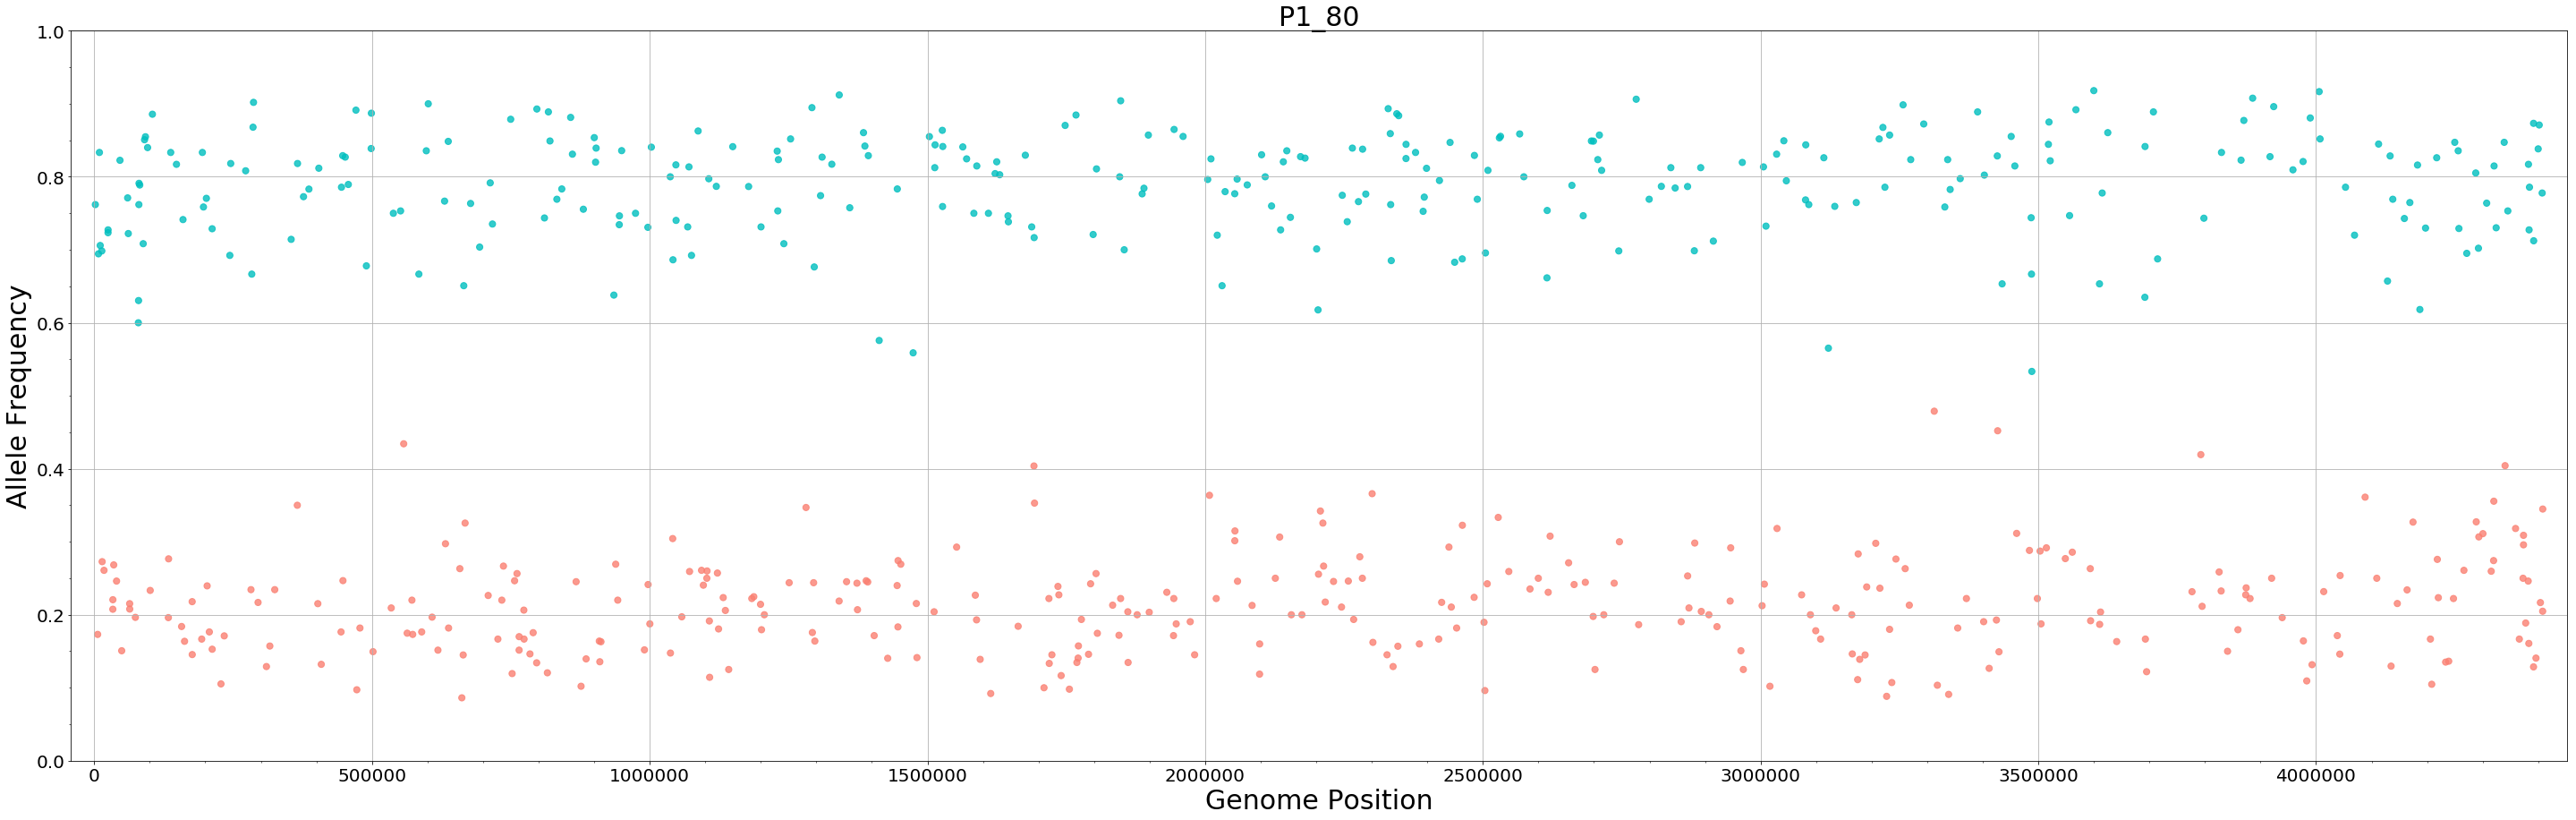

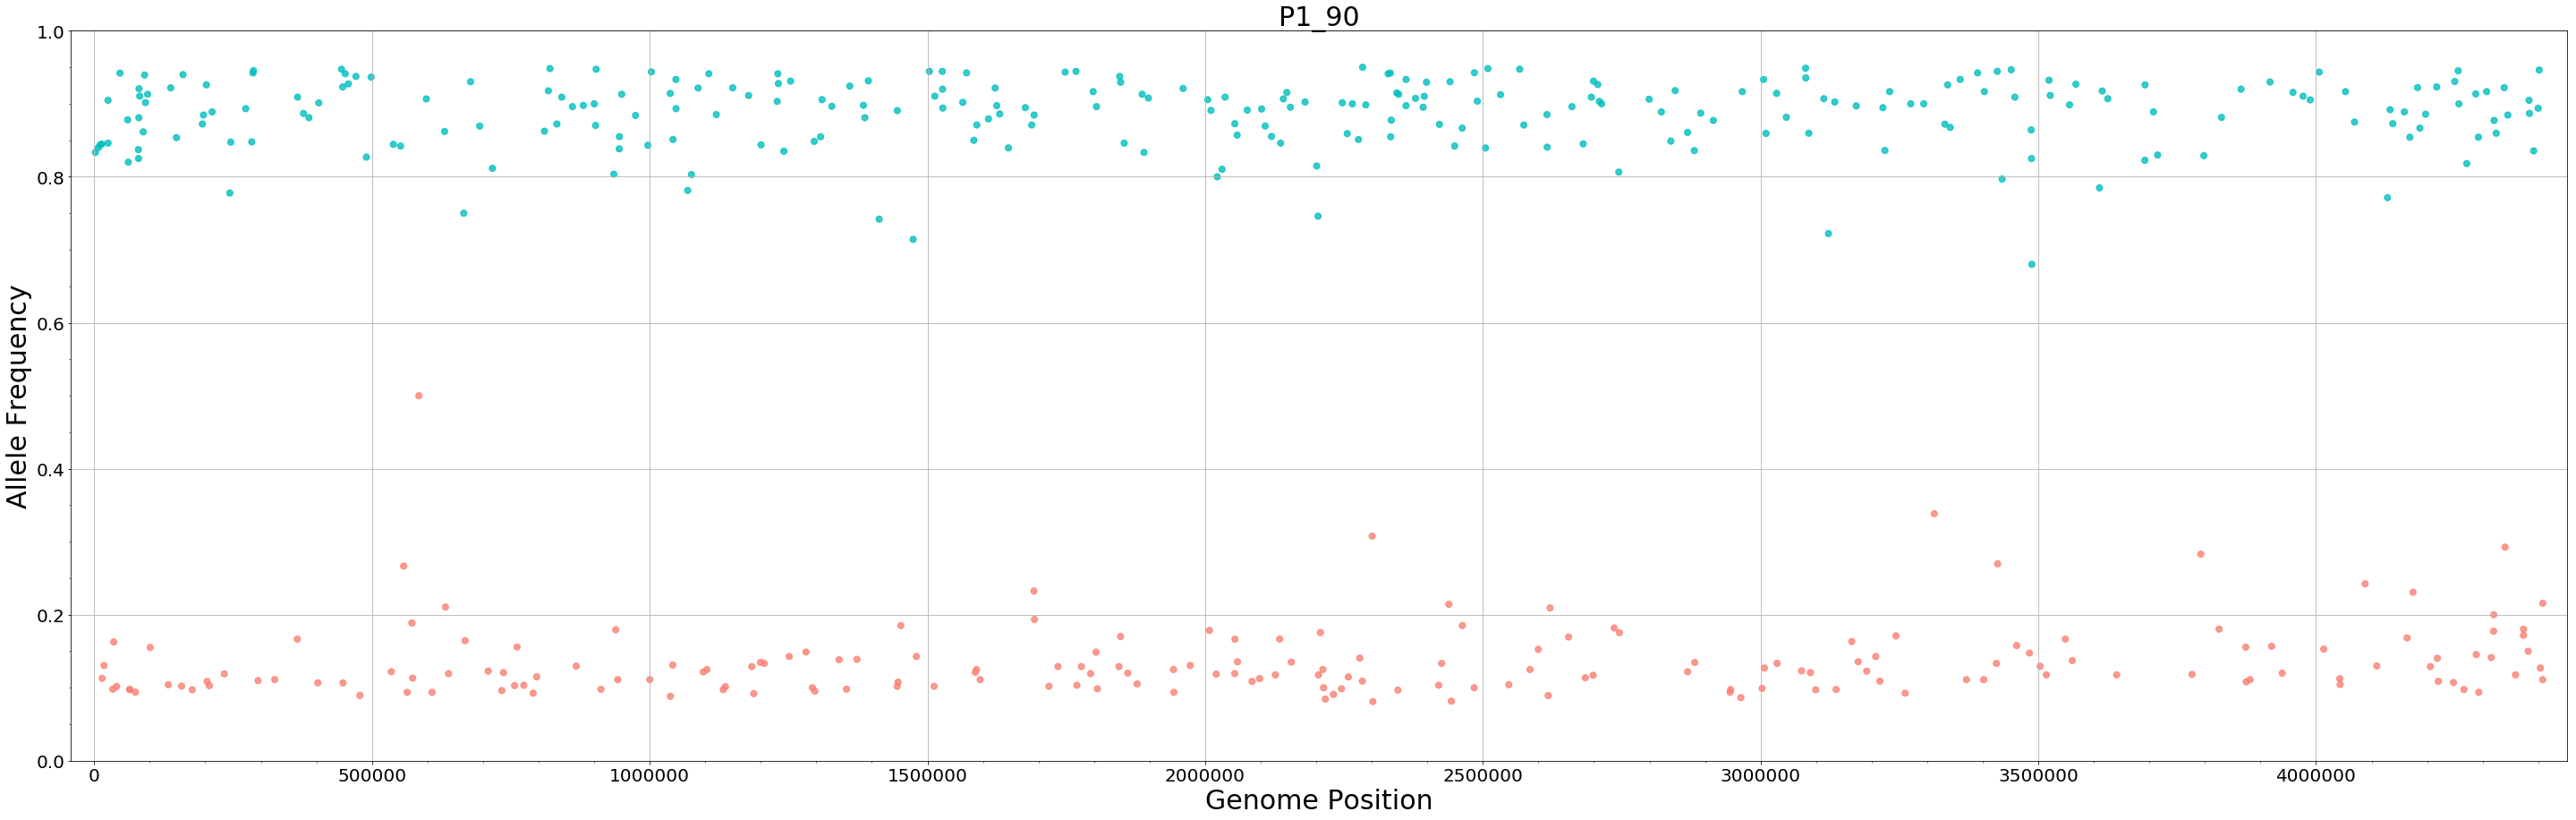

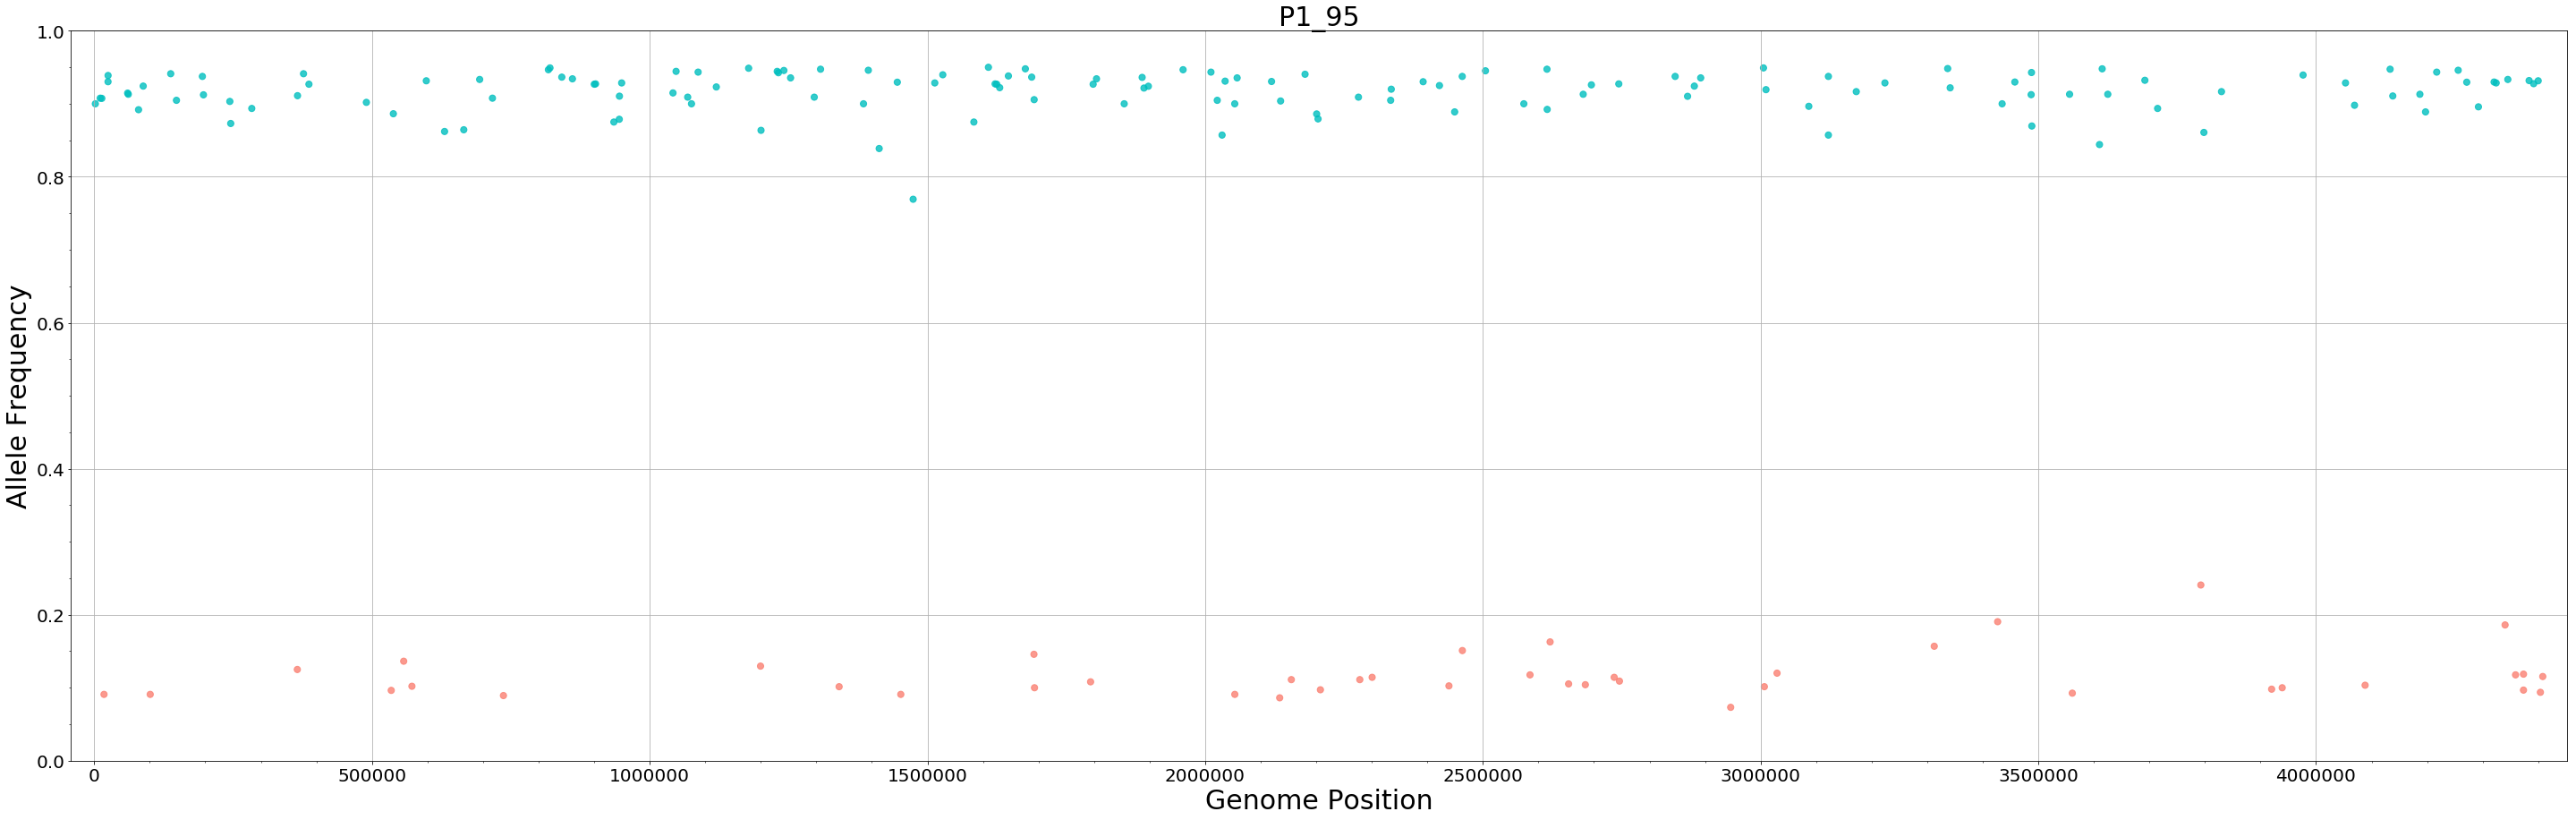

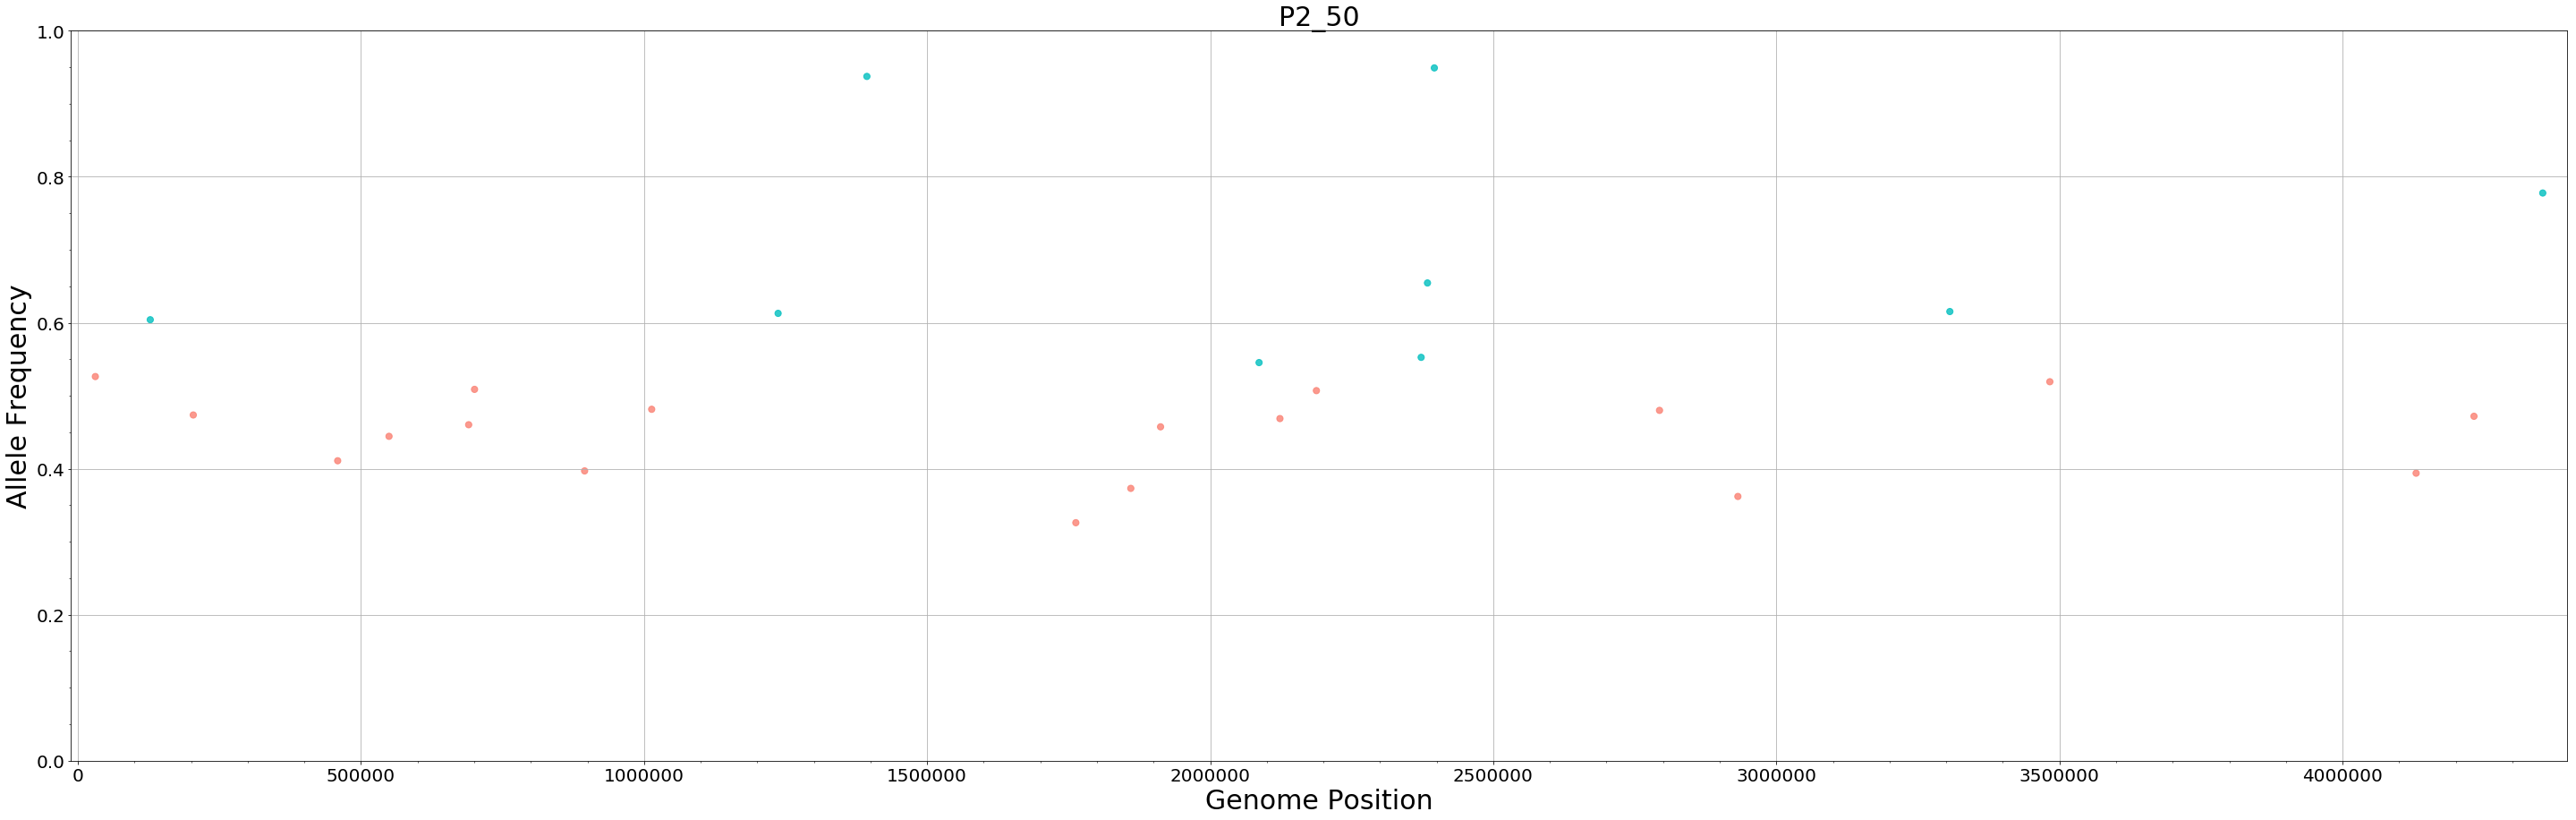

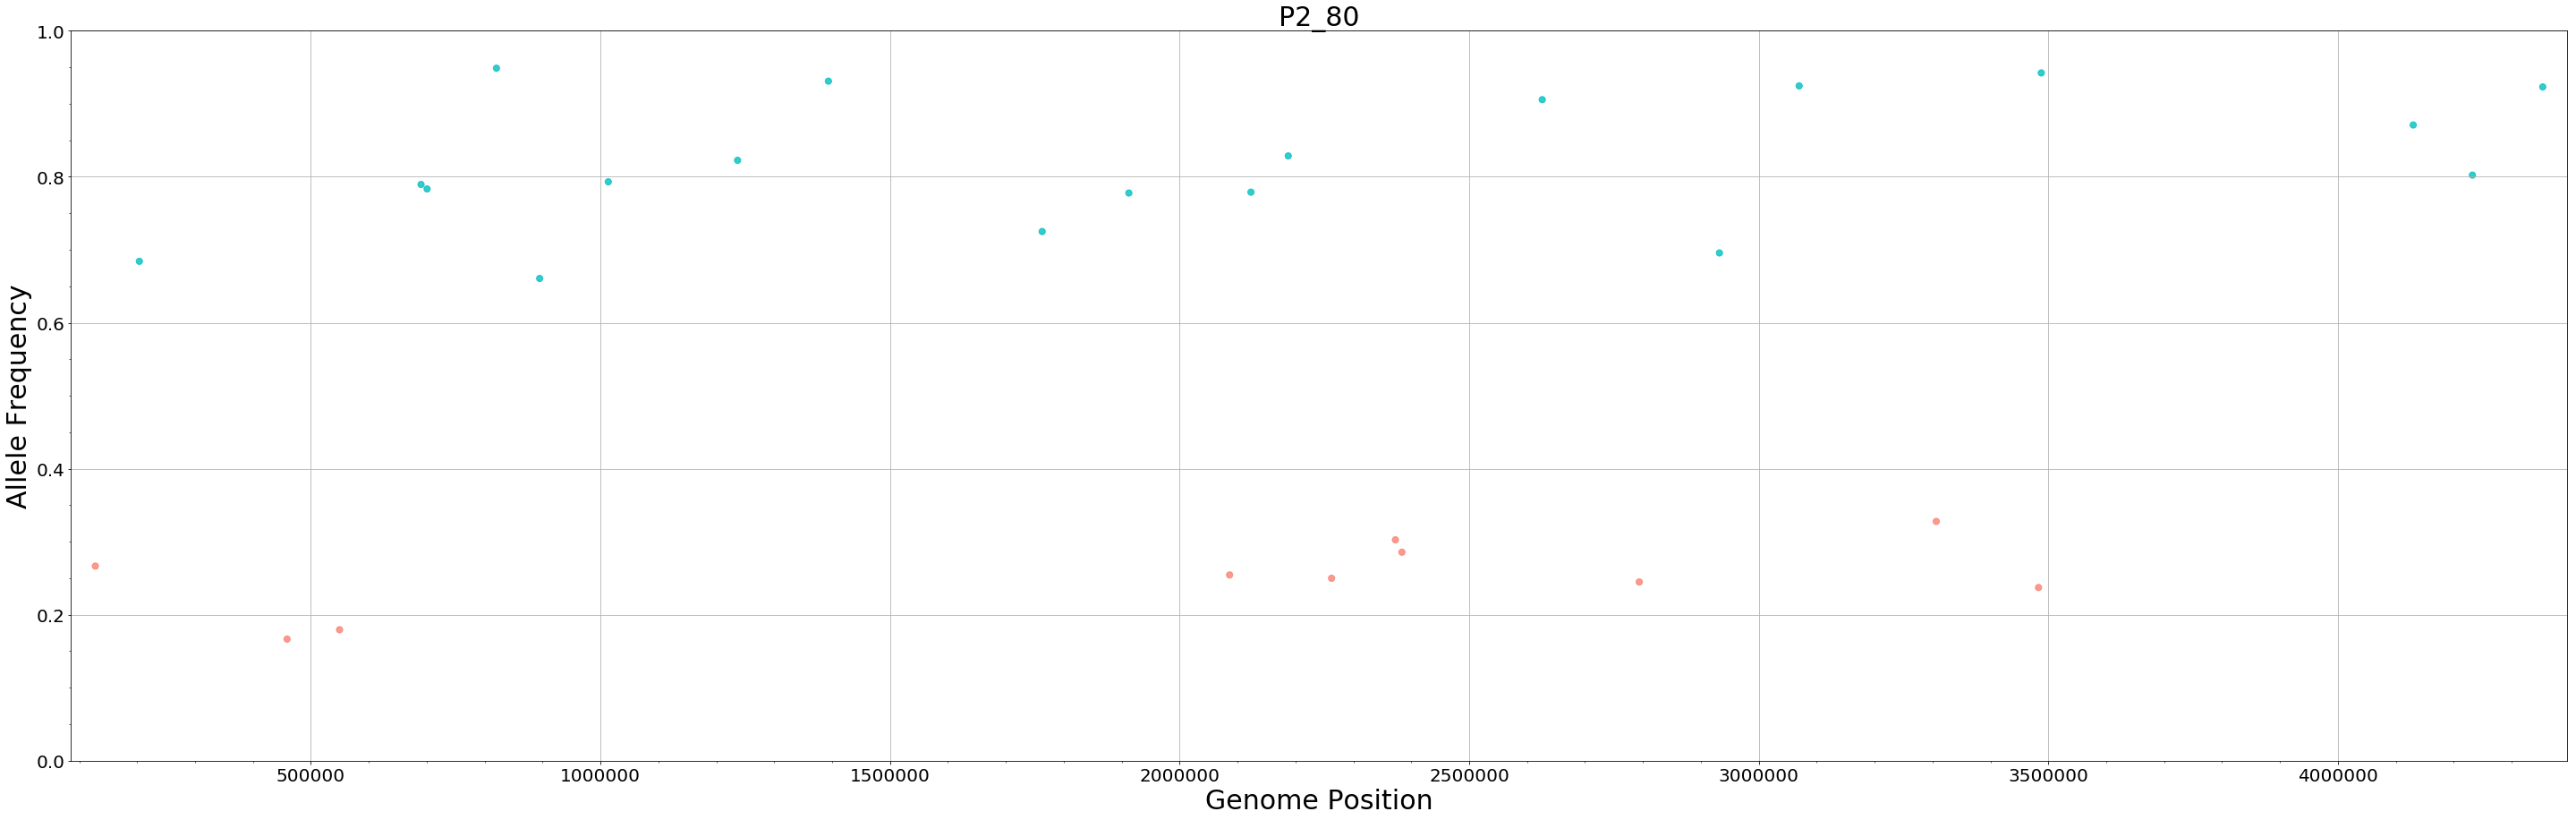

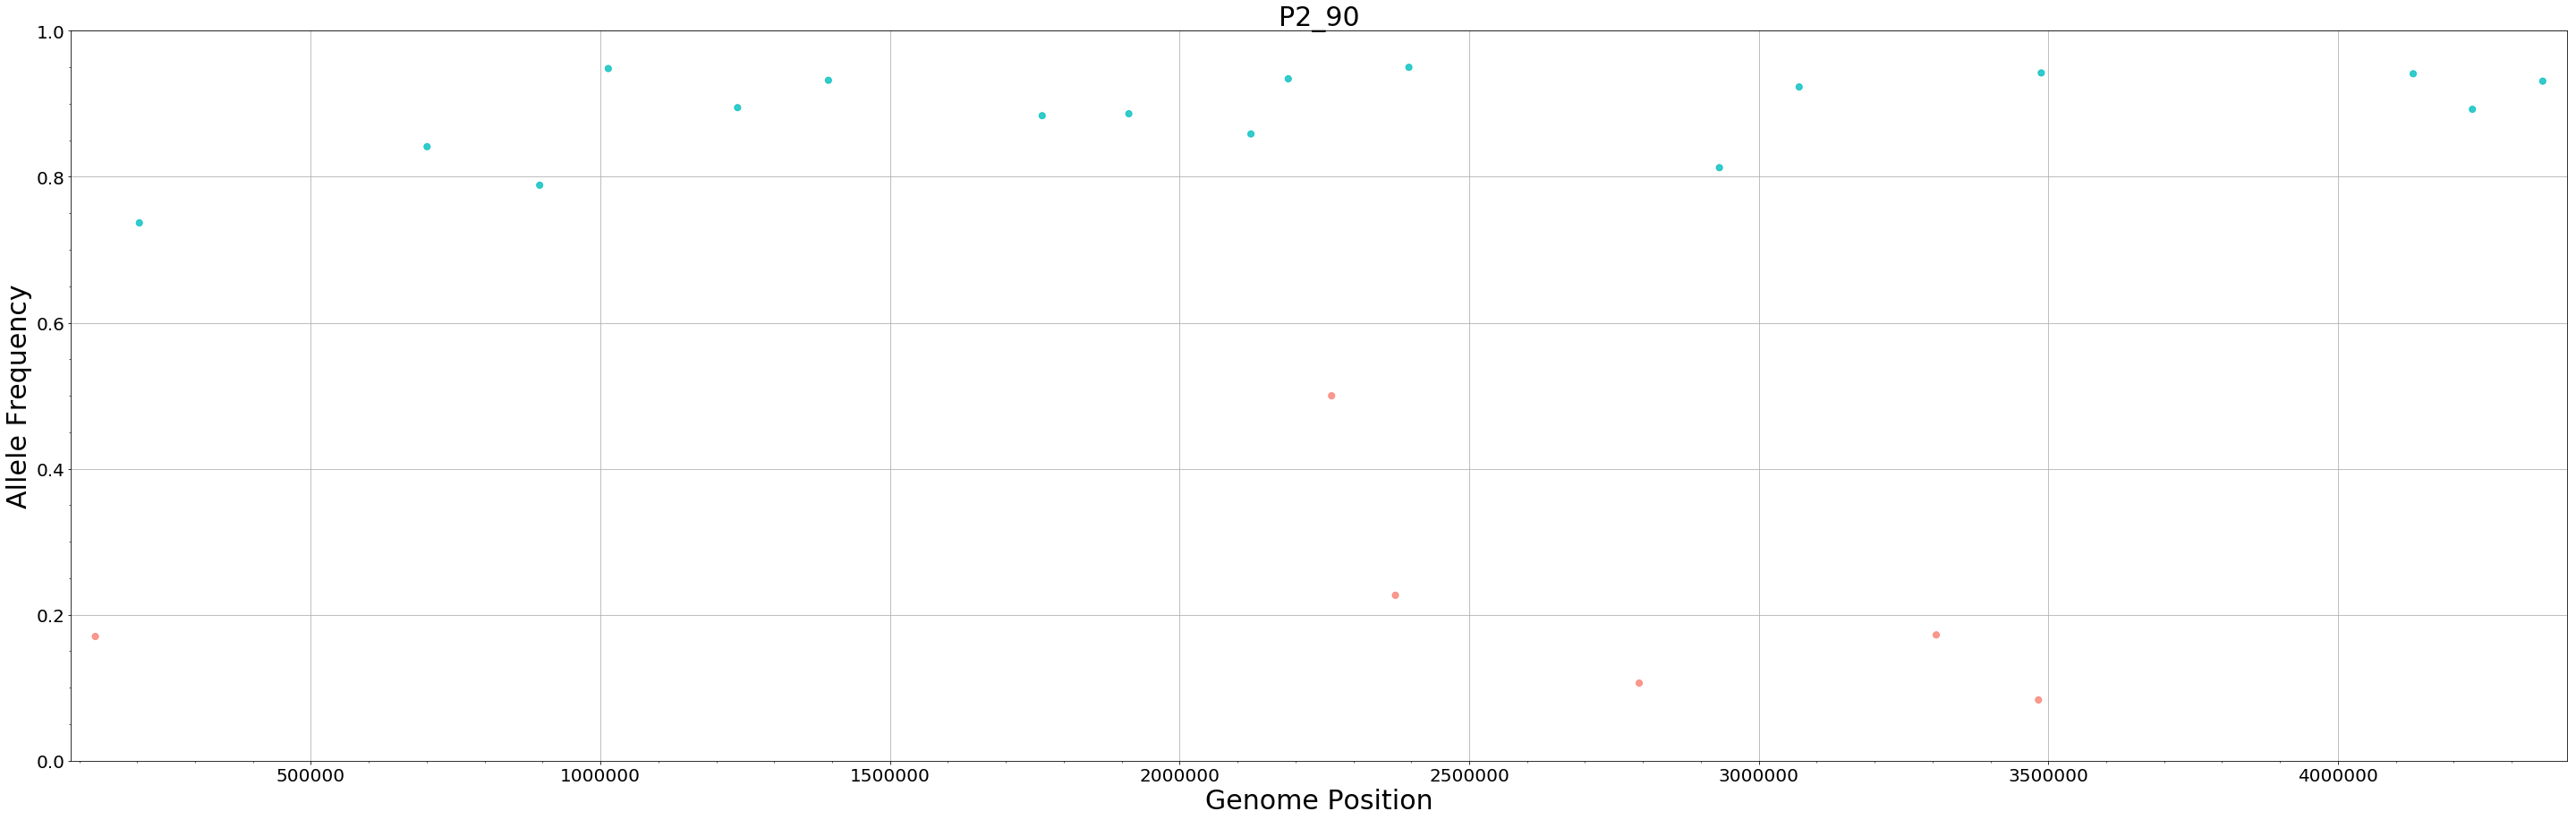

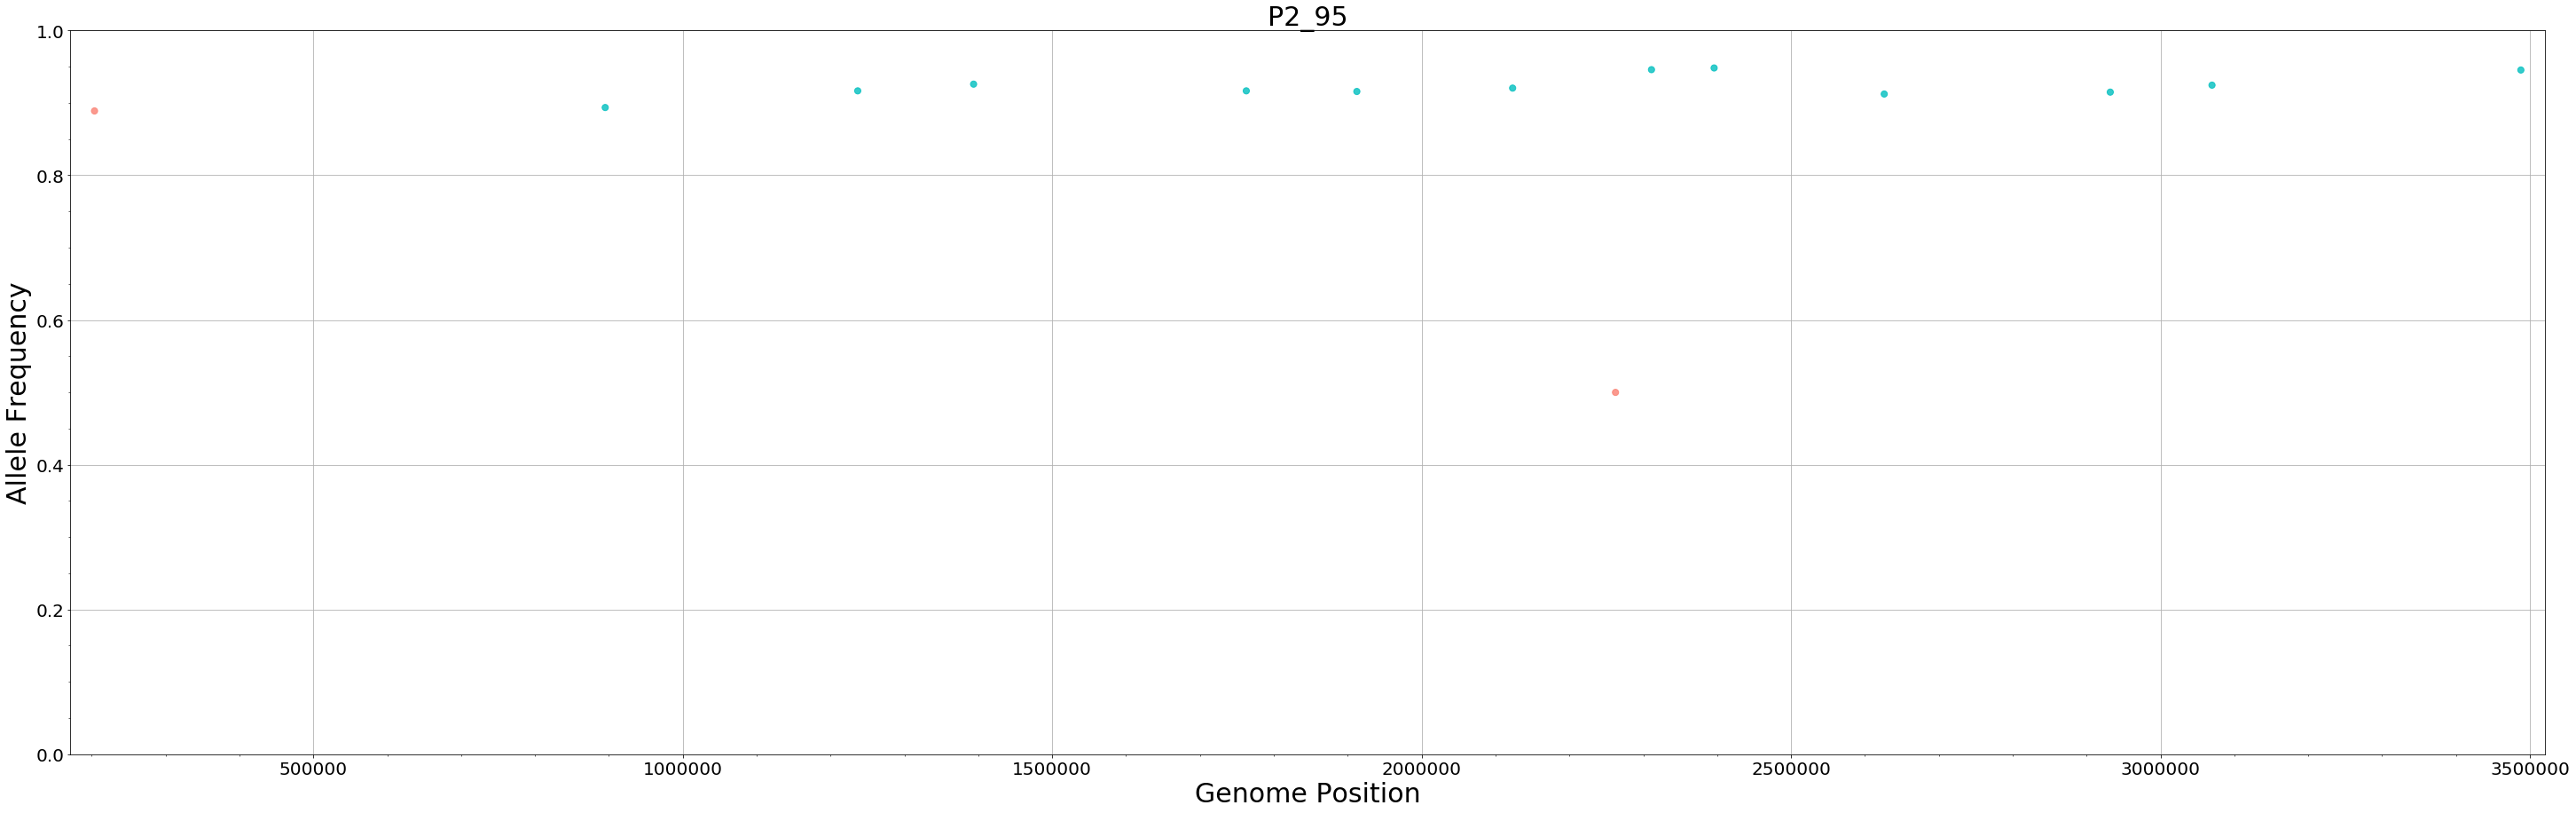

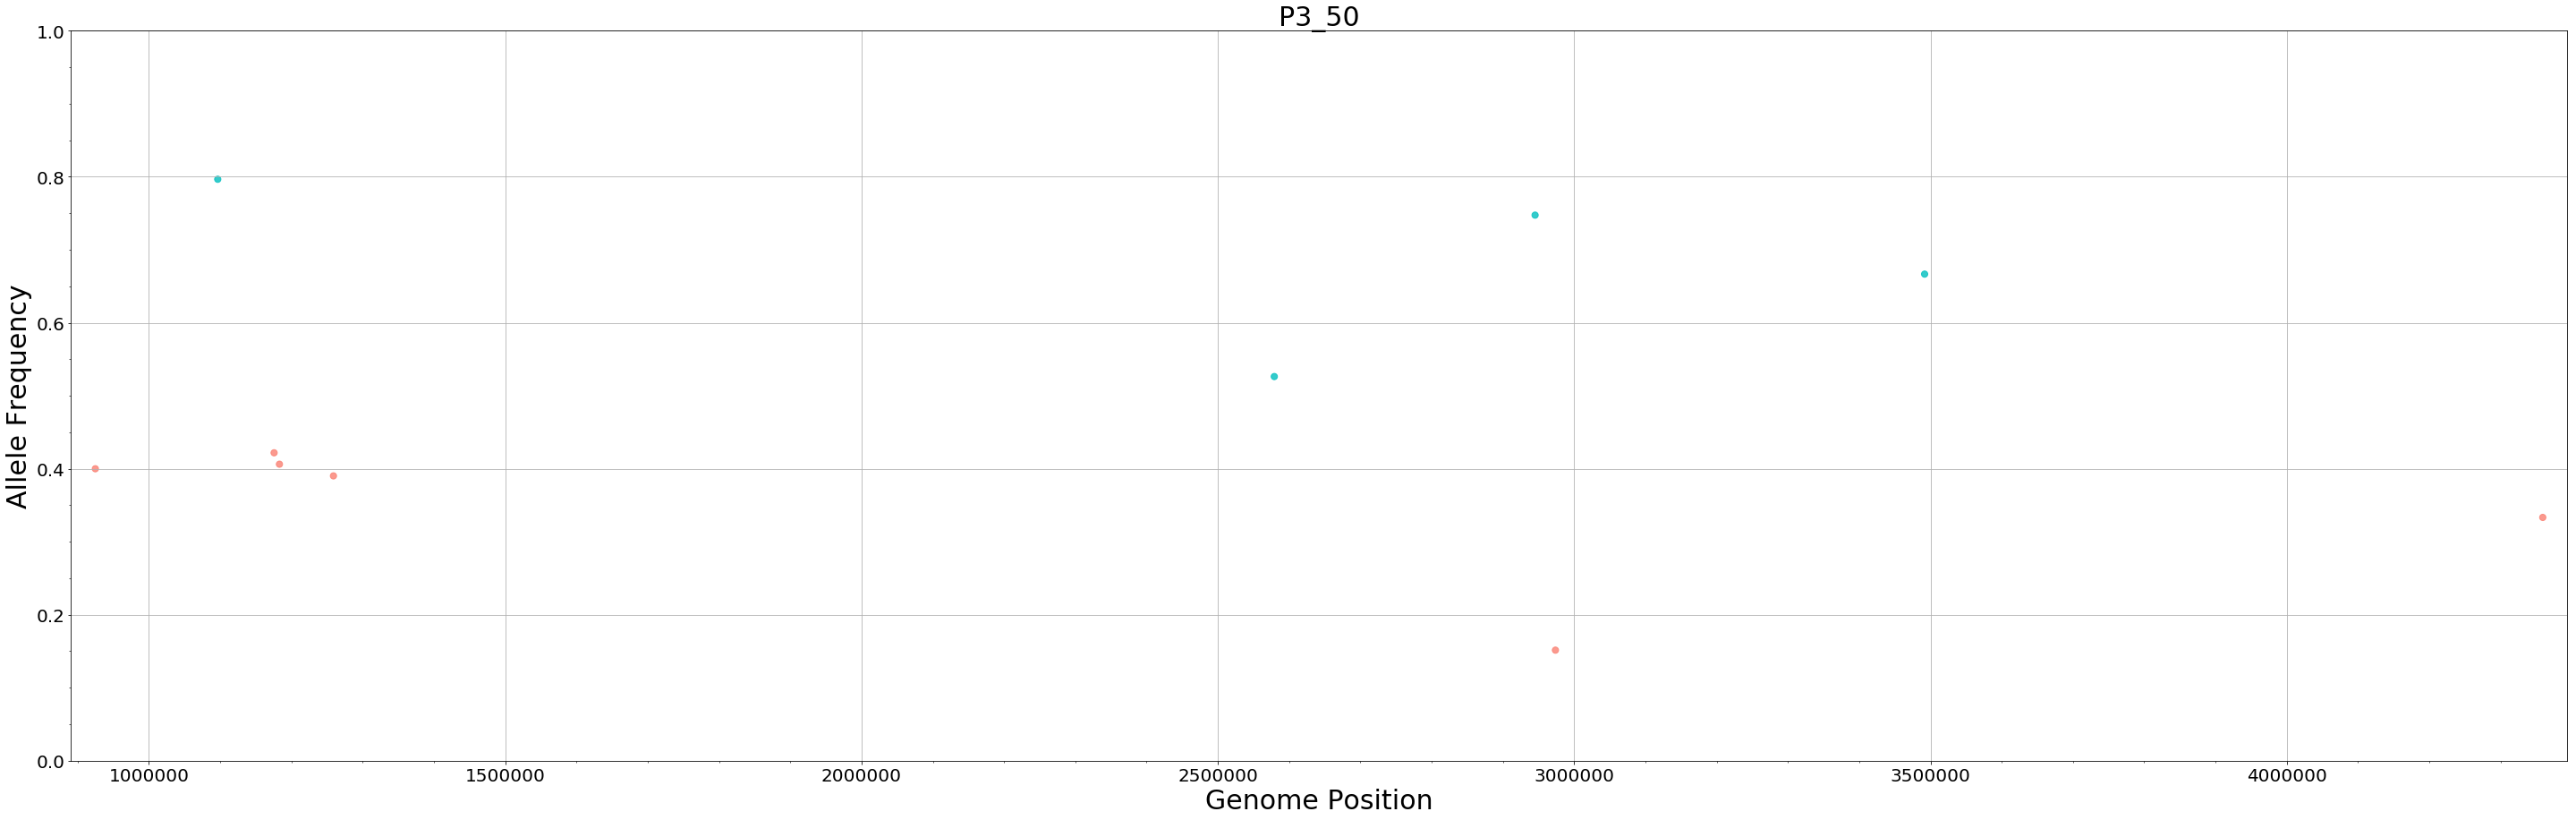

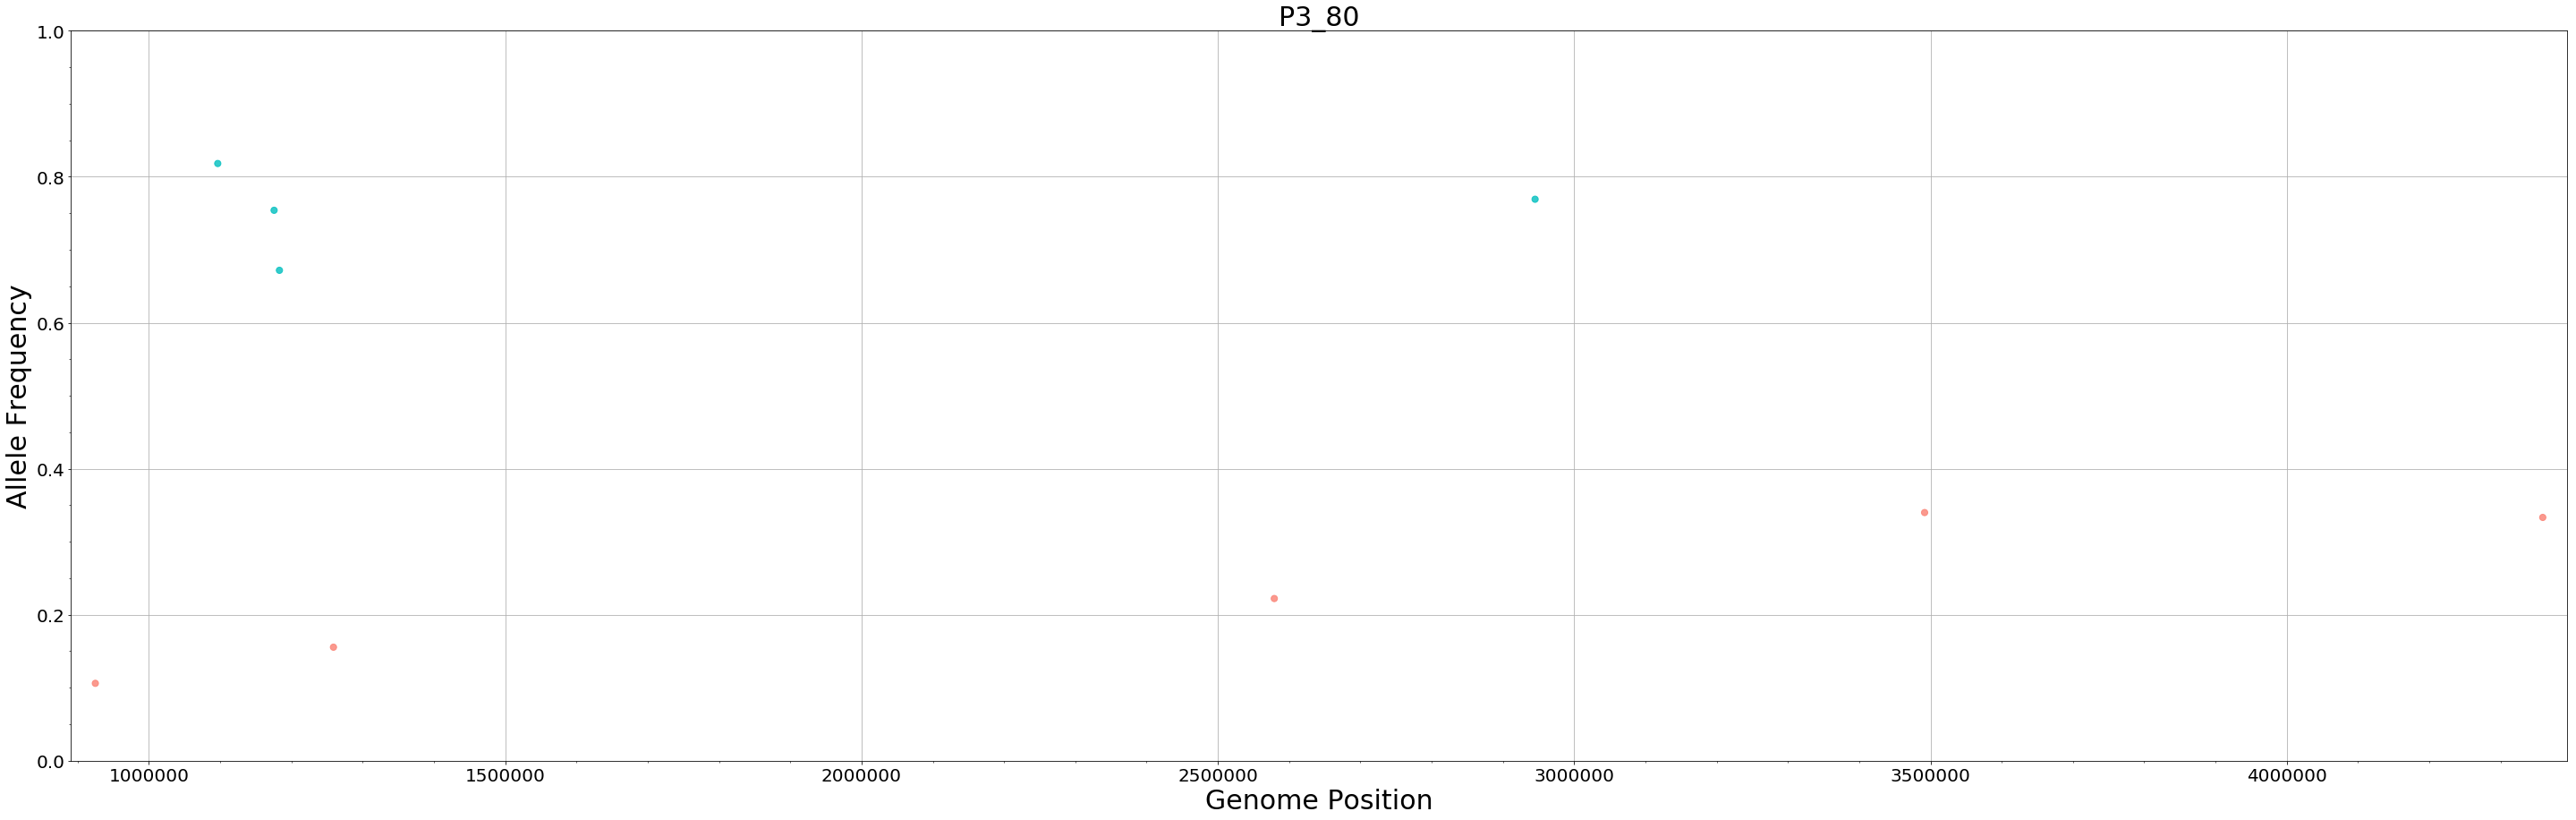

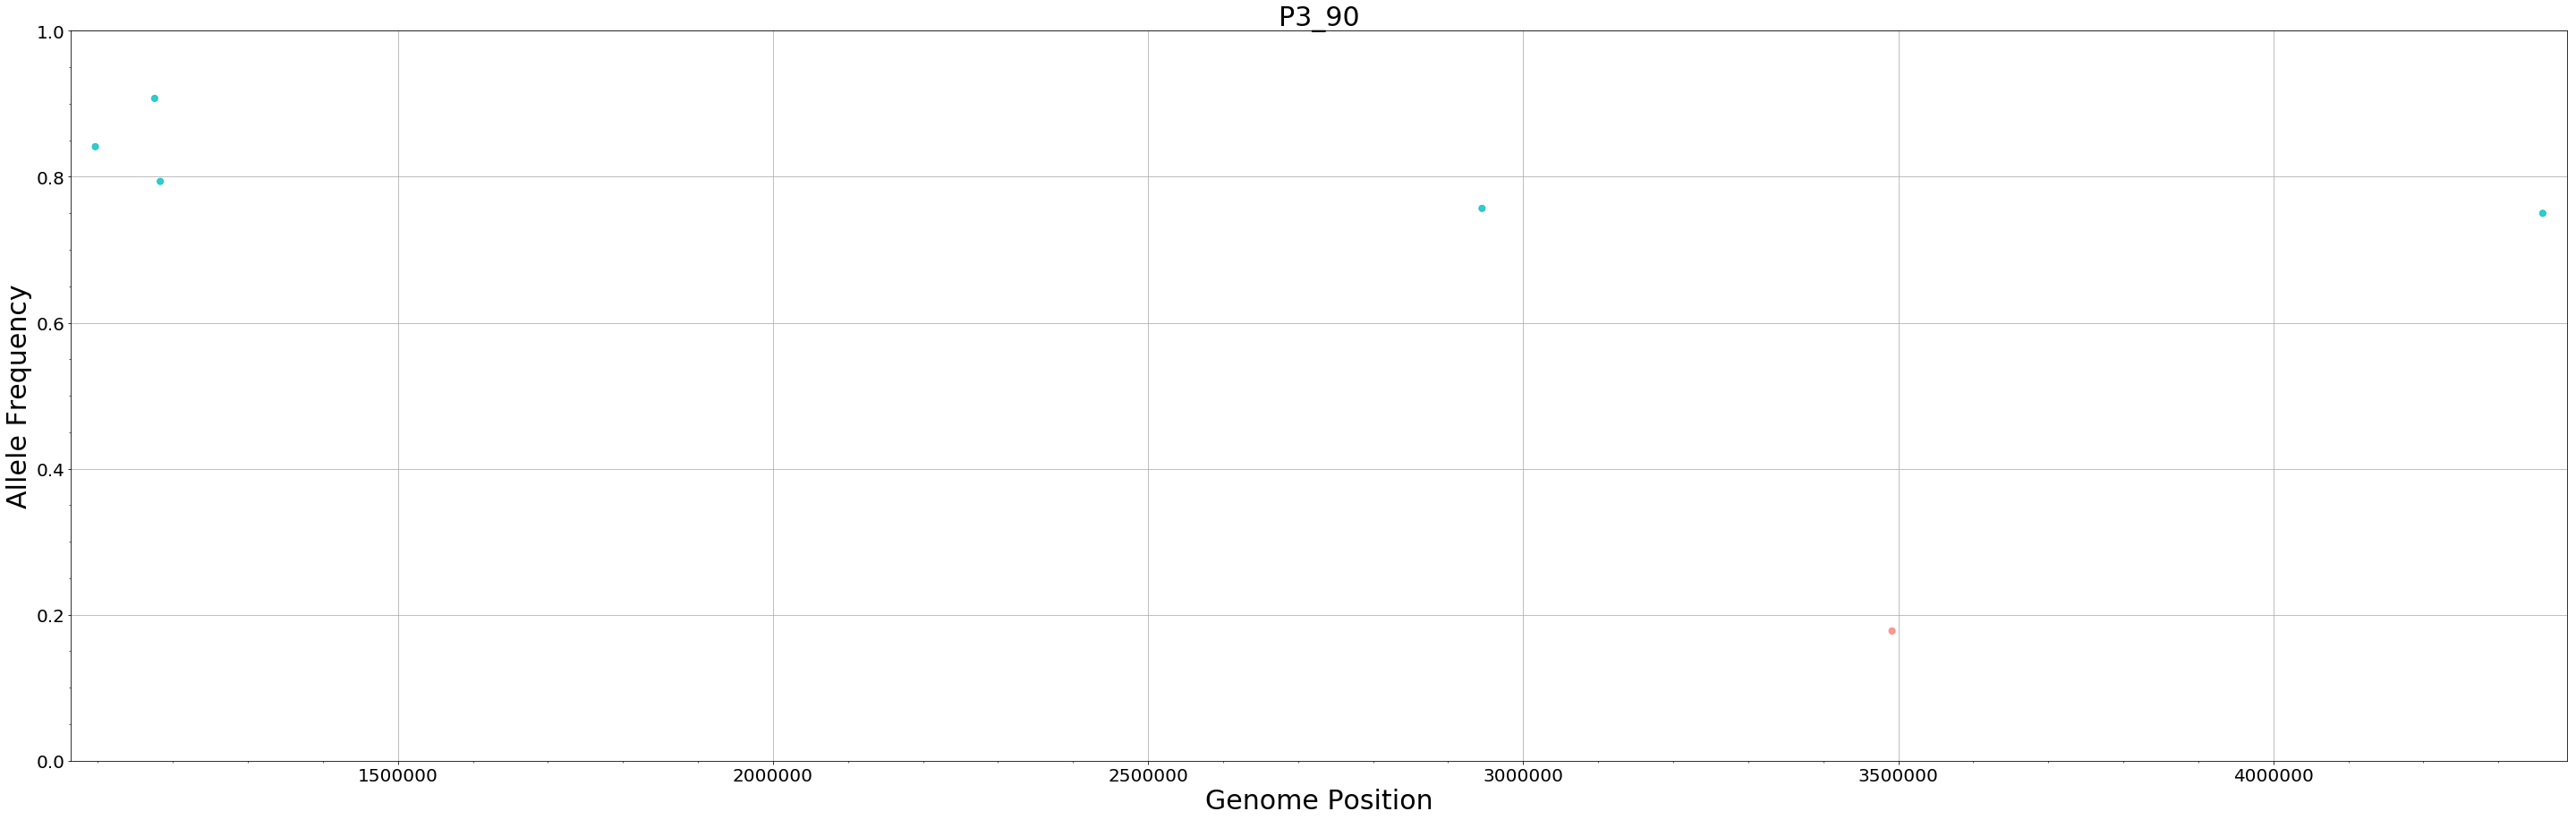

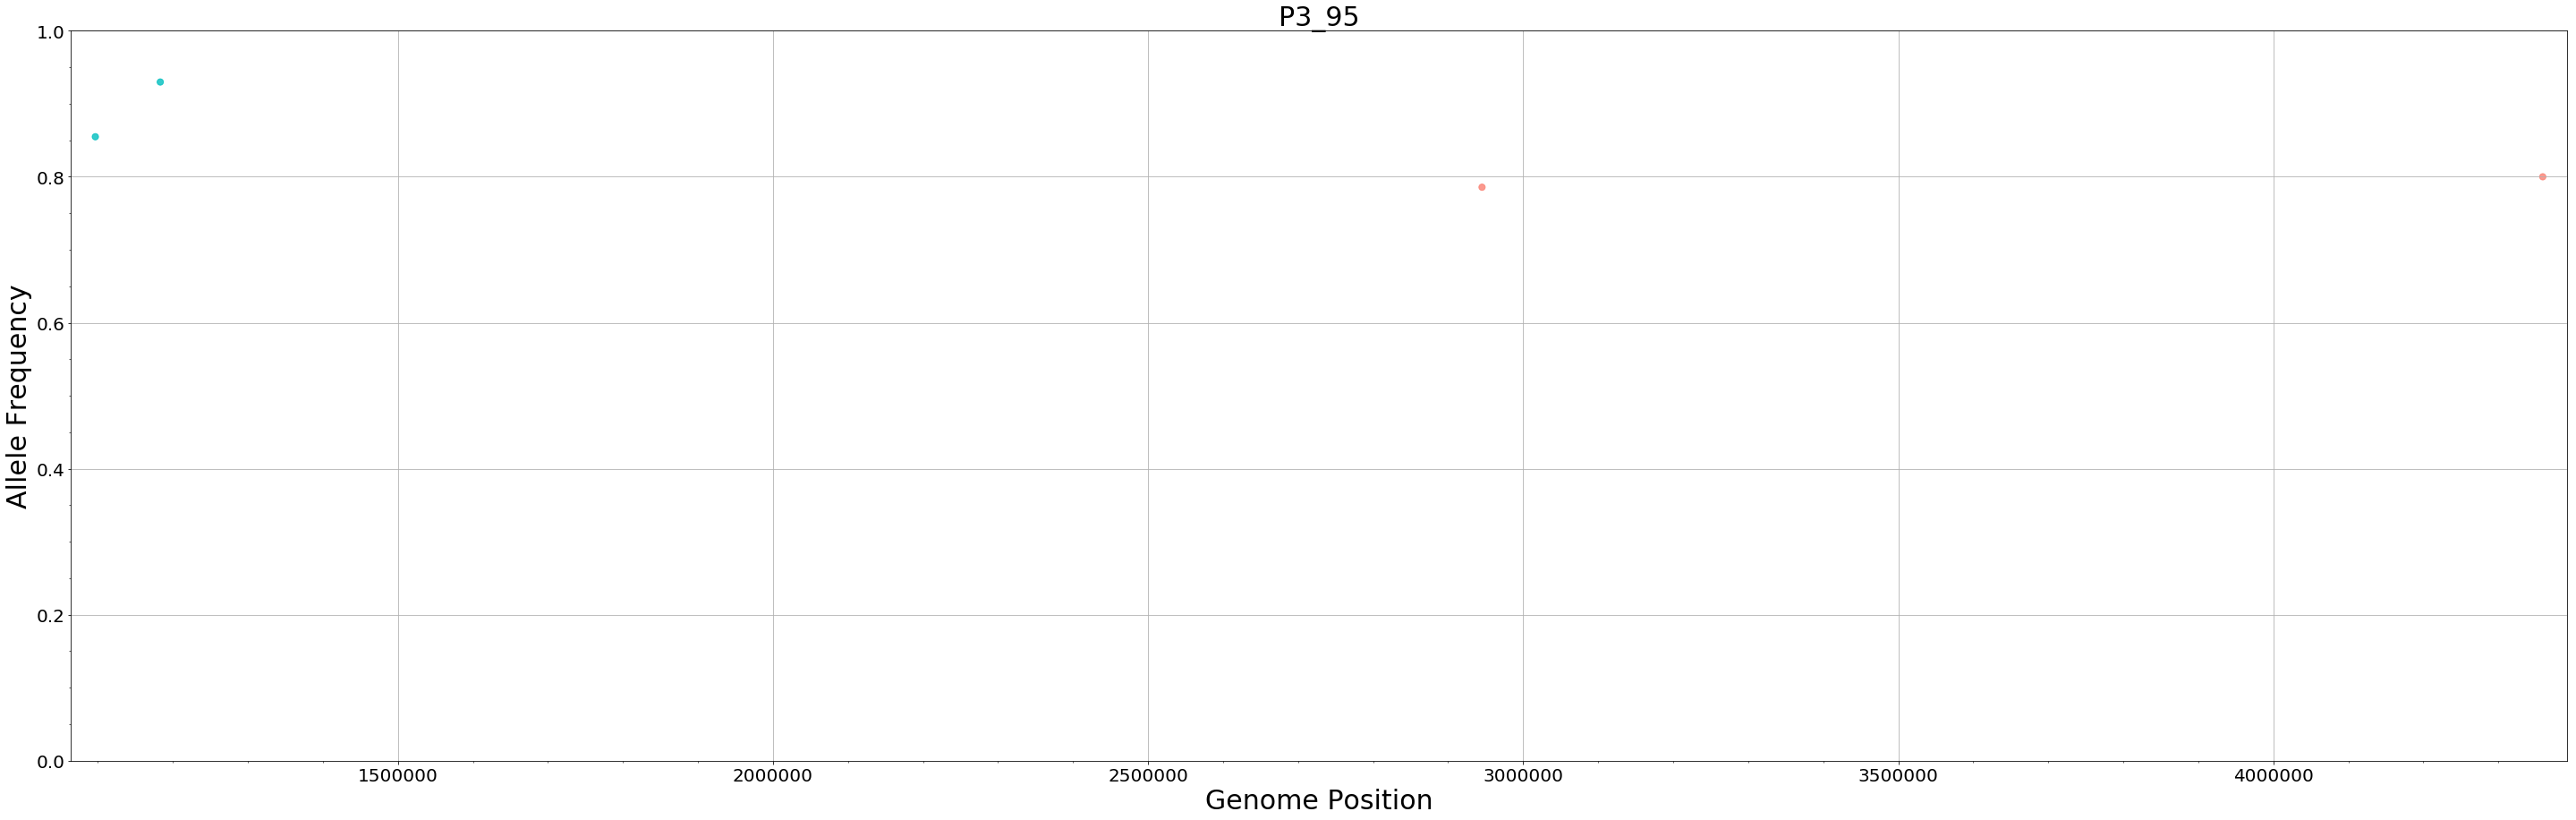

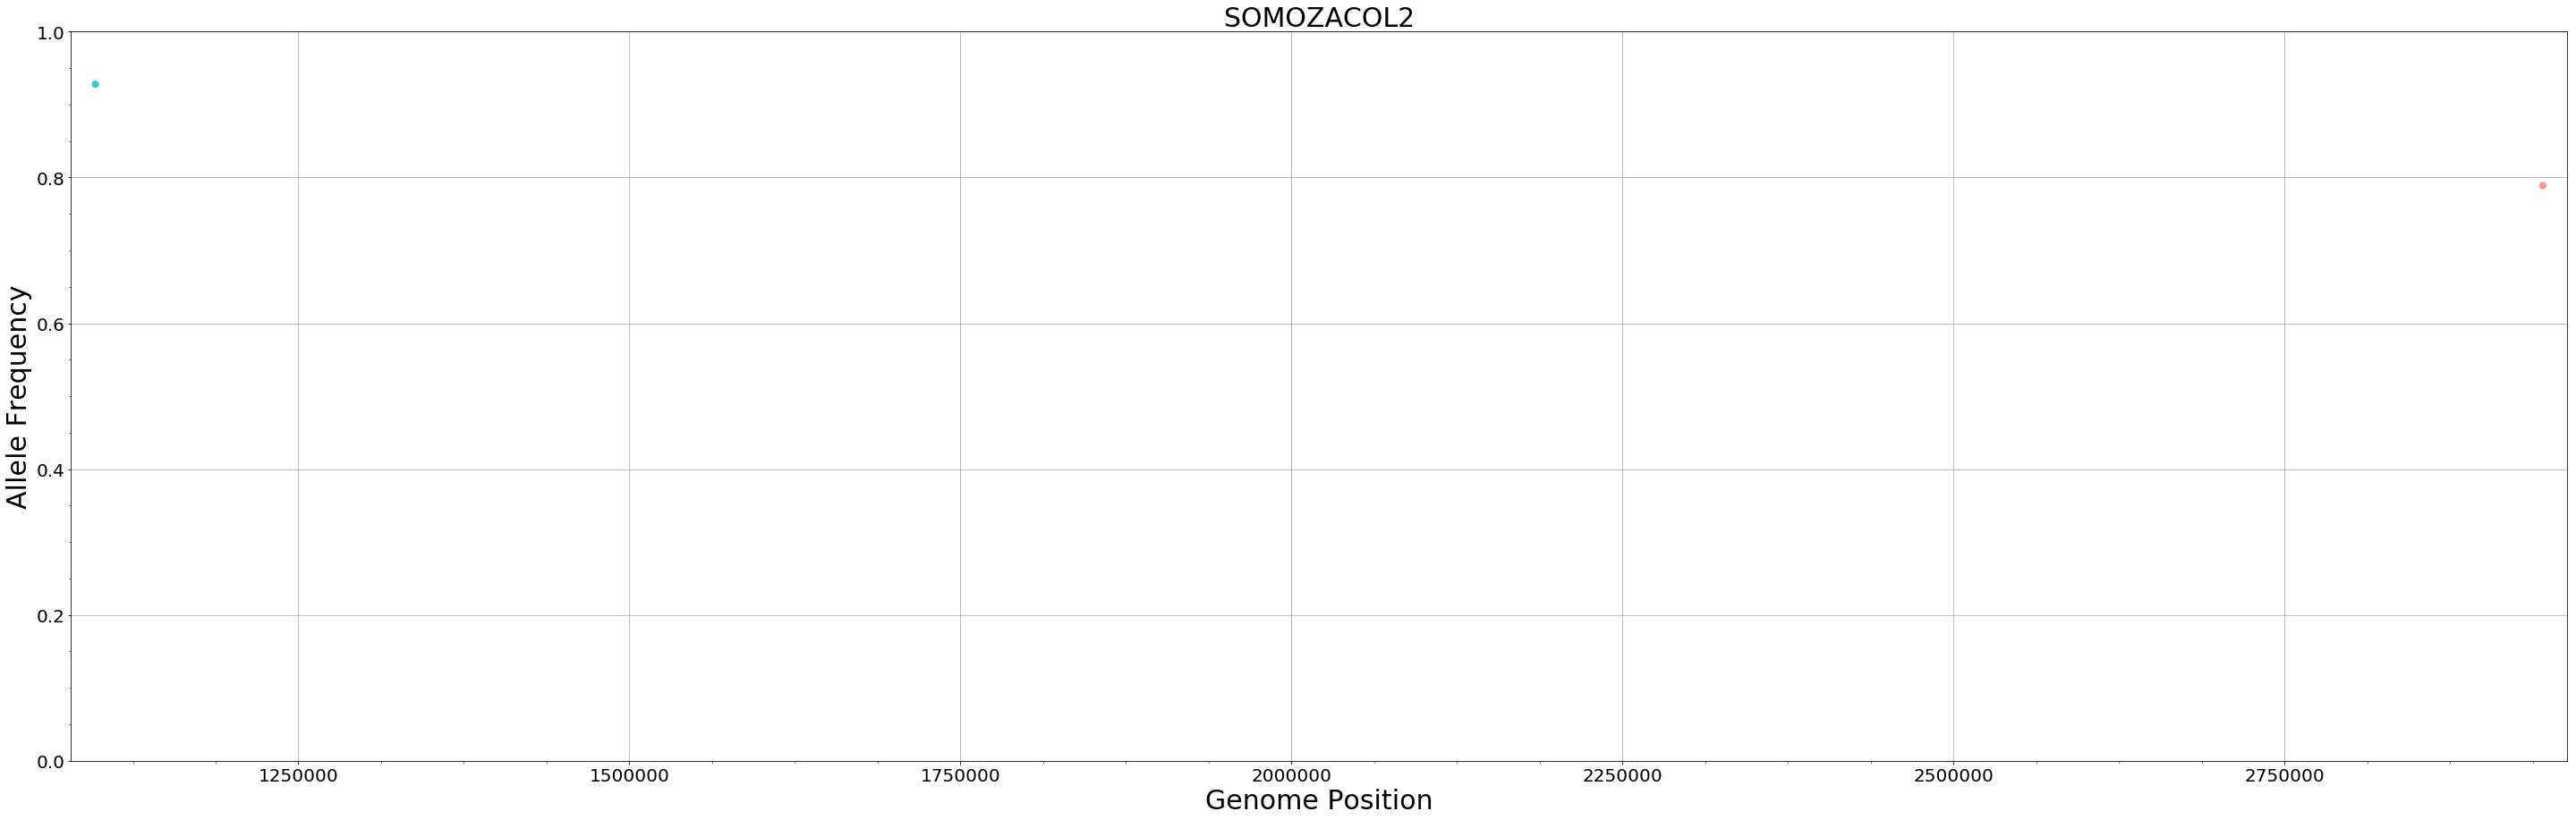

In [13]:
for name_dsf, df in dict_dff.items():
    scatter_vcf_pos(df,name_dsf, 0.95)

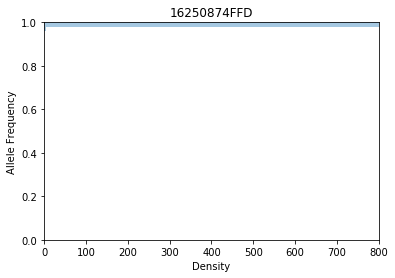

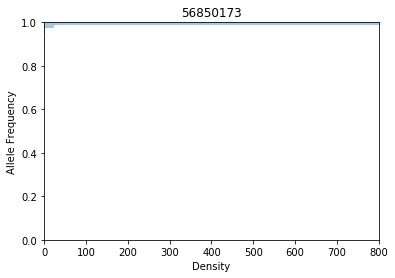

/home/laura/env36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/laura/env36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


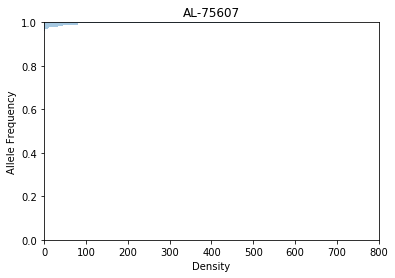

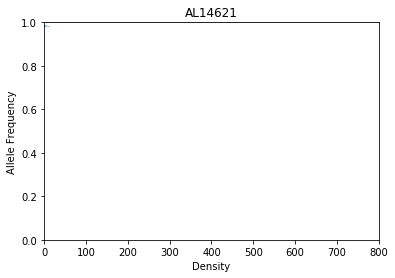

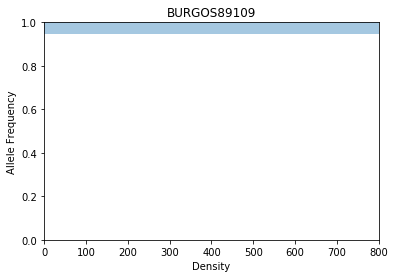

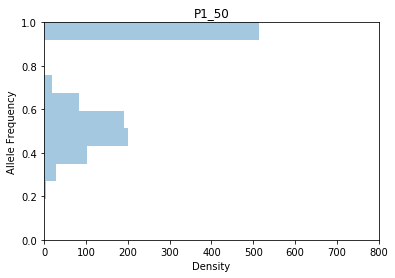

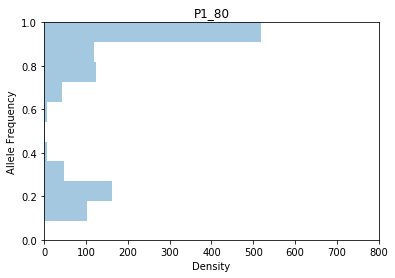

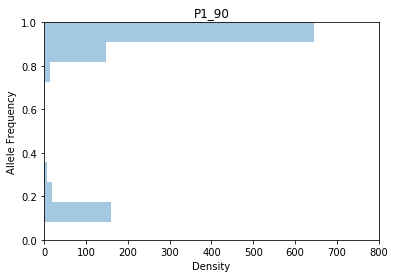

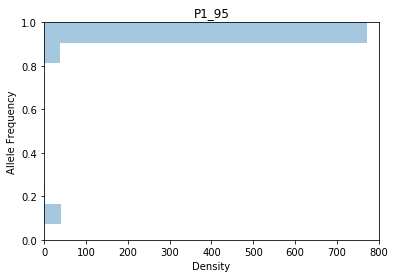

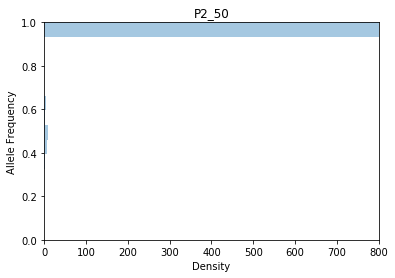

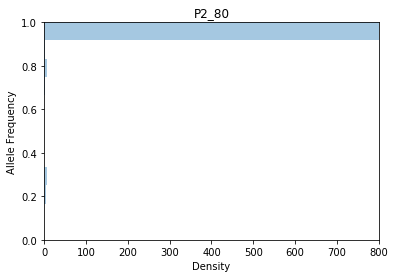

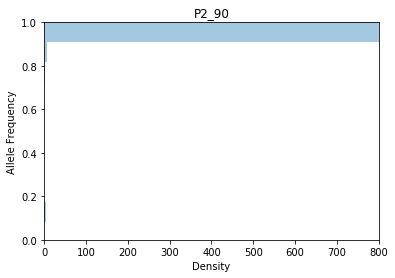

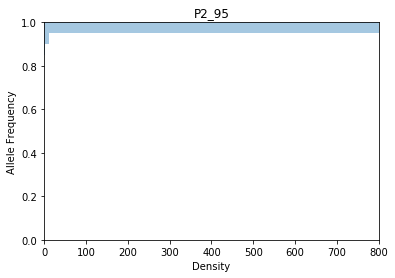

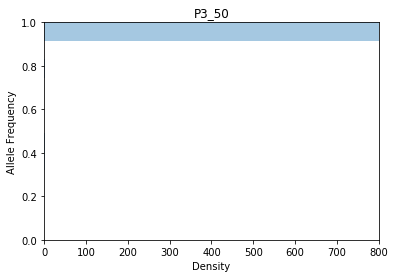

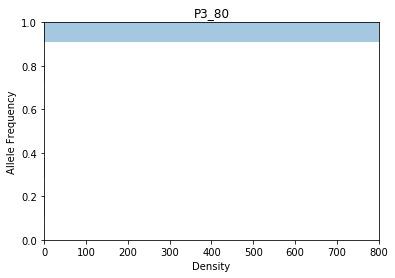

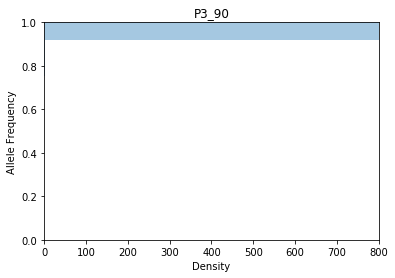

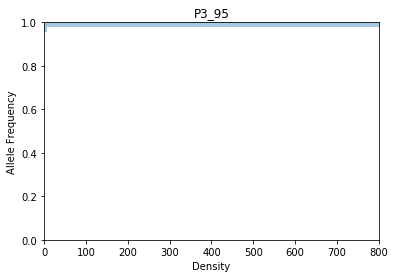

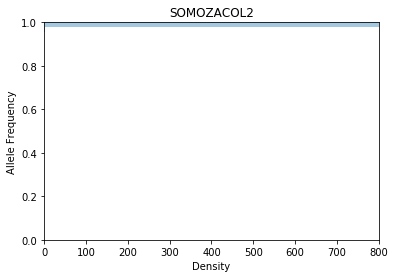

In [14]:
for name_dsf, df in dict_dff.items():
    distplot_sns(df,name_dsf)

In [15]:
def split_df_mean(vcf_df, homoz=0.95):
    filter_homoz_top = homoz
    filter_homoz_bottom = (1 - filter_homoz_top)
    
    mean = vcf_df['AF'][(vcf_df['AF'] <= filter_homoz_top) & (vcf_df['AF'] >= filter_homoz_bottom)].mean(axis = 0)    

    top_positions = vcf_df['POS'][(vcf_df['AF'] >= mean) & (vcf_df['AF'] <= filter_homoz_top)].tolist()
    bottom_positions = vcf_df['POS'][(vcf_df['AF'] <= mean) & (vcf_df['AF'] >= filter_homoz_bottom)].tolist()
    
    return top_positions, bottom_positions

In [16]:
dict_t_b = {}
for name_dff, df_dff in dict_dff.items():
    name_top = name_dff + "_t"
    name_btm = name_dff + "_b"
    name_top , name_btm = split_df_mean(df_dff)
    dict_t_b[name_dff] = name_top , name_btm

In [17]:
for k,v in dict_t_b.items():
    print(k, len(v), len(v[0]), len(v[1]))

16250874FFD 2 1 1
56850173 2 3 1
AL-75607 2 1 1
AL14621 2 0 0
BURGOS89109 2 1 1
P1_50 2 313 316
P1_80 2 297 321
P1_90 2 264 188
P1_95 2 141 43
P2_50 2 9 18
P2_80 2 19 10
P2_90 2 17 6
P2_95 2 12 2
P3_50 2 4 6
P3_80 2 4 5
P3_90 2 5 1
P3_95 2 2 2
SOMOZACOL2 2 1 1


# Create sets for comparing

In [18]:
B = set(dict_dff['BURGOS89109'].POS.values)
P = set(dict_dff['56850173'].POS.values)
A75 = set(dict_dff['AL-75607'].POS.values)
A14 = set(dict_dff['AL14621'].POS.values)
F = set(dict_dff['16250874FFD'].POS.values)
S = set(dict_dff['SOMOZACOL2'].POS.values)

In [19]:
B_exclusive = B - P
P_exclusive = P - B
Shared_B_P = P & B
total_difference_B_P = (len(B_exclusive) + len(P_exclusive))
print("B has %s unique positions\n\
P has %s unique positions\n\
Both share %s positions\n\
Total difference: %s" % (len(B_exclusive) , len(P_exclusive), len(Shared_B_P),total_difference_B_P ))

B has 299 unique positions
P has 334 unique positions
Both share 512 positions
Total difference: 633


In [20]:
A75_exclusive = A75 - A14
A14_exclusive = A14 - A75
Shared_A75_A14 = A14 & A75

print("A75 has %s unique positions\n\
A14 has %s unique positions\n\
Both share %s positions" % (len(A75_exclusive) , len(A14_exclusive), len(Shared_A75_A14)))

A75 has 17 unique positions
A14 has 10 unique positions
Both share 855 positions


In [21]:
F_exclusive = F - S
S_exclusive = S - F
Shared_F_S = S & F

print("F has %s unique Positions\n\
S has %s unique Sositions\n\
Both share %s Positions" % (len(F_exclusive) , len(S_exclusive), len(Shared_F_S)))

F has 2 unique Positions
S has 4 unique Sositions
Both share 840 Positions


# Use venn diagram to check disgregation

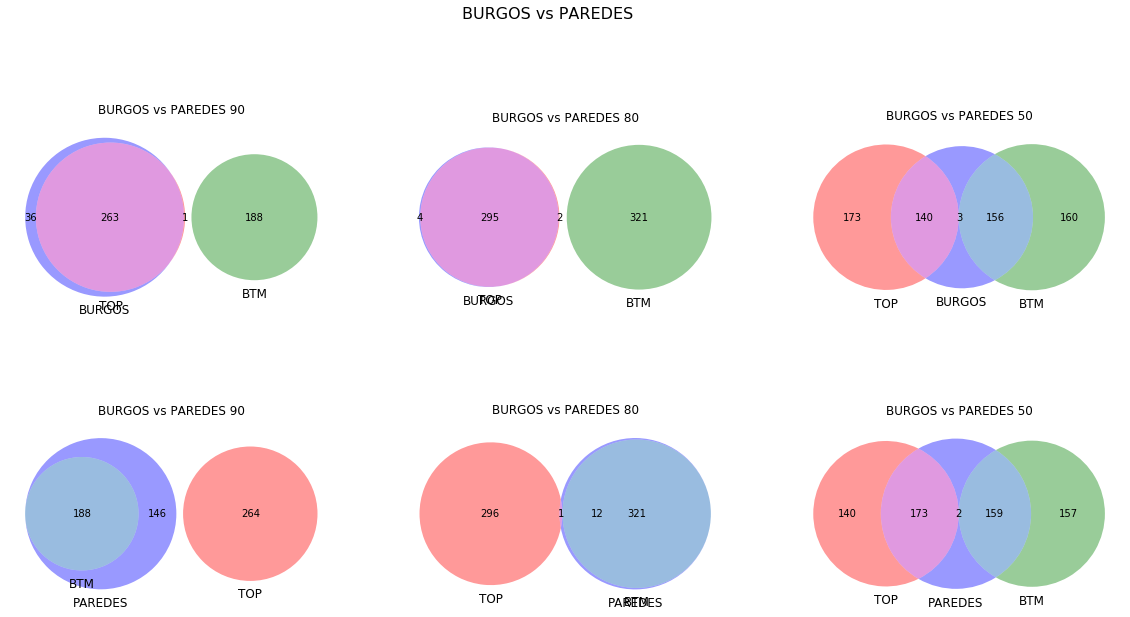

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 2)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.subplot(2, 3, 3)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), B_exclusive], 
            set_labels = ('TOP', 'BTM', 'BURGOS'))

plt.suptitle('BURGOS vs PAREDES', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("BURGOS vs PAREDES 90")
v3 = venn3([set(dict_t_b['P1_90'][0]), set(dict_t_b['P1_90'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 5)
plt.title("BURGOS vs PAREDES 80")
v3 = venn3([set(dict_t_b['P1_80'][0]), set(dict_t_b['P1_80'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

plt.subplot(2, 3, 6)
plt.title("BURGOS vs PAREDES 50")
v3 = venn3([set(dict_t_b['P1_50'][0]), set(dict_t_b['P1_50'][1]), P_exclusive], 
            set_labels = ('TOP', 'BTM', 'PAREDES'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

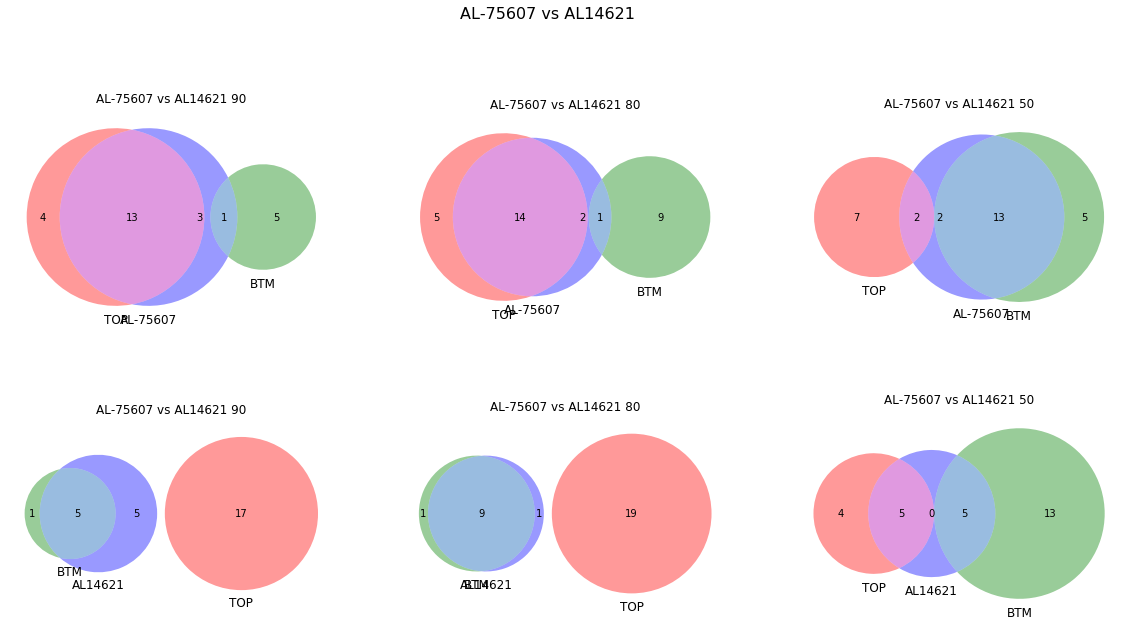

In [23]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 2)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.subplot(2, 3, 3)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A75_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL-75607'))

plt.suptitle('AL-75607 vs AL14621', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("AL-75607 vs AL14621 90")
v3 = venn3([set(dict_t_b['P2_90'][0]), set(dict_t_b['P2_90'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 5)
plt.title("AL-75607 vs AL14621 80")
v3 = venn3([set(dict_t_b['P2_80'][0]), set(dict_t_b['P2_80'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

plt.subplot(2, 3, 6)
plt.title("AL-75607 vs AL14621 50")
v3 = venn3([set(dict_t_b['P2_50'][0]), set(dict_t_b['P2_50'][1]), A14_exclusive], 
            set_labels = ('TOP', 'BTM', 'AL14621'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

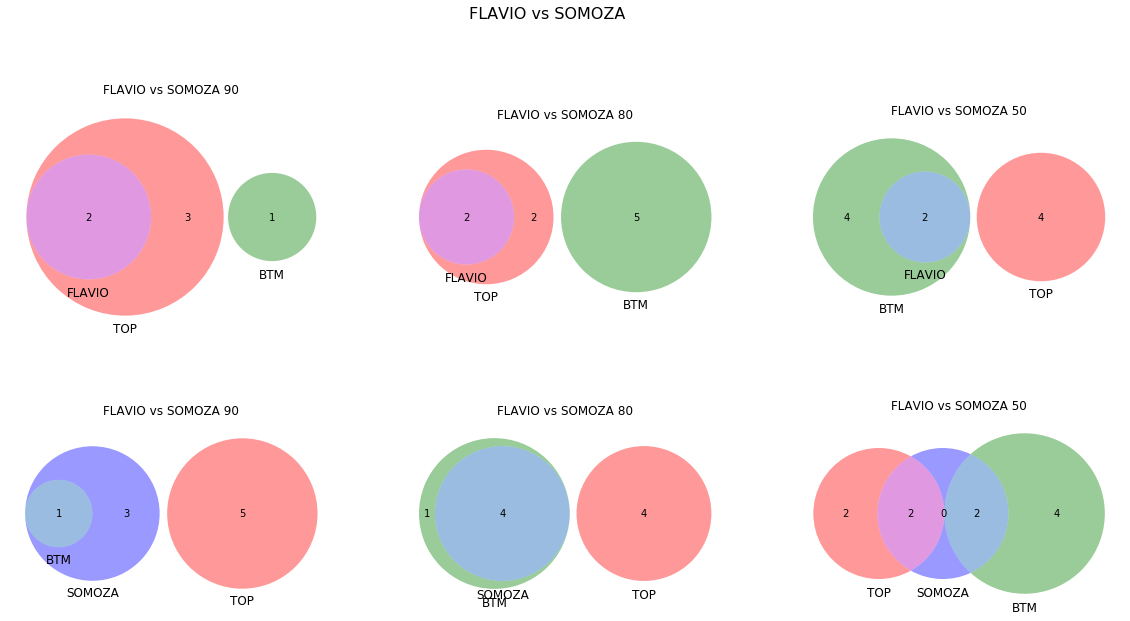

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 2)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.subplot(2, 3, 3)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), F_exclusive], 
            set_labels = ('TOP', 'BTM', 'FLAVIO'))

plt.suptitle('FLAVIO vs SOMOZA', fontsize=16, verticalalignment='bottom')


plt.subplot(2, 3, 4)
plt.title("FLAVIO vs SOMOZA 90")
v3 = venn3([set(dict_t_b['P3_90'][0]), set(dict_t_b['P3_90'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 5)
plt.title("FLAVIO vs SOMOZA 80")
v3 = venn3([set(dict_t_b['P3_80'][0]), set(dict_t_b['P3_80'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

plt.subplot(2, 3, 6)
plt.title("FLAVIO vs SOMOZA 50")
v3 = venn3([set(dict_t_b['P3_50'][0]), set(dict_t_b['P3_50'][1]), S_exclusive], 
            set_labels = ('TOP', 'BTM', 'SOMOZA'))

#plt.savefig(os.path.join('img', 'SOMOZA_ALL.svg'), format="svg")

plt.show()

# Start K-means clustering

### Thanks to: http://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/

In [26]:
dict_dff['P1_50'].describe()

POS          QUAL           AC           af           AN  \
count  1.142000e+03   1142.000000  1142.000000  1142.000000  1142.000000   
mean   2.192770e+06  30100.015193     1.447461     0.723730     1.996497   
std    1.323996e+06  15787.796924     0.497450     0.249604     0.069340   
min    1.977000e+03    382.740000     1.000000     0.000000     0.500000   
25%    1.059282e+06  18001.935000     1.000000     0.500000     2.000000   
50%    2.156018e+06  26318.140000     1.000000     0.500000     2.000000   
75%    3.313967e+06  42991.270000     2.000000     1.000000     2.000000   
max    4.408156e+06  76972.270000     2.000000     1.000000     2.000000   

       BaseQRankSum           DP    ExcessHet           FS           MQ  \
count    765.000000  1142.000000  1142.000000  1142.000000  1142.000000   
mean       0.149152    63.677758     1.399975     2.003785    59.764164   
std        1.835350    17.307028     1.492125     4.149545     2.906691   
min       -4.556000     6.000000    -0.431000     0.000000     0.000000   
25%       -1.427000    52.000000     0.011100     0.000000    60.000000   
50%        0.246000    62.000000     0.195400     0.000000    60.000000   
75%        1.700000    76.000000     3.010300     2.275500    60.000000   
max        5.300000   130.000000    10.548300    45.000000    60.000000   

        MQRankSum           QD  ReadPosRankSum          SOR           GQ  \
count  765.000000  1142.000000      763.000000  1142.000000  1142.000000   
mean     0.015442    30.027277        0.179401     0.791675    98.521891   
std      0.469362     3.636034        0.999847     1.156433     4.834958   
min     -7.441000    16.820000       -2.697000     0.000000    12.000000   
25%      0.000000    27.592500       -0.564000     0.531250    99.000000   
50%      0.000000    30.305000        0.128000     0.738500    99.000000   
75%      0.000000    32.767500        0.922000     0.917750    99.000000   
max      7.750000    60.000000        2.660000    29.540000    99.000000   

            len_AD       REF_AD       ALT_AD           dp           aF  \
count  1142.000000  1142.000000  1142.000000  1142.000000  1142.000000   
mean      2.002627    17.456217    46.183012    63.639229     0.274279   
std       0.051209    17.544917    21.104571    17.380400     0.257119   
min       2.000000     0.000000     3.000000     6.000000     0.000000   
25%       2.000000     0.000000    29.000000    52.000000     0.000000   
50%       2.000000    19.000000    42.000000    62.000000     0.376930   
75%       2.000000    32.000000    61.000000    76.000000     0.509711   
max       3.000000    66.000000   130.000000   130.000000     0.812500   

                AF  snp_left_distance  snp_right_distance  
count  1142.000000        1142.000000         1142.000000  
mean      0.725721        3433.135727         3403.275832  
std       0.257119        3592.912667         3447.191755  
min       0.187500          16.000000           16.000000  
25%       0.490289         939.000000          939.000000  
50%       0.623070        2231.000000         2289.500000  
75%       1.000000        4783.500000         4811.250000  
max       1.000000       31347.000000        21698.000000

/home/laura/env36/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


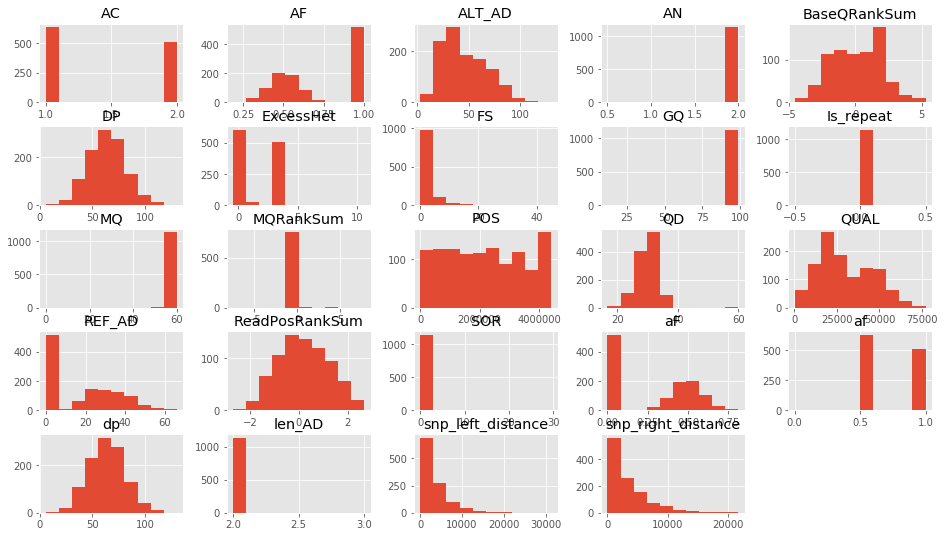

In [27]:
dict_dff['P1_50'].hist()
plt.show()

In [58]:
def assign_group_P1(row):
    if row.POS in B_exclusive:
        return 1
    elif row.POS in P_exclusive:
        return 2
    else:
        return 3


In [59]:
Ktest5 = dict_dff['P1_50']
Ktest8 = dict_dff['P1_80']
Ktest9 = dict_dff['P1_90']

In [60]:
Ktest5['category'] = Ktest5.apply(assign_group_P1, axis=1)
Ktest8['category'] = Ktest8.apply(assign_group_P1, axis=1)
Ktest9['category'] = Ktest9.apply(assign_group_P1, axis=1)

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [61]:
Ktest8.head()

#CHROM   POS ID REF ALT      QUAL FILTER  \
0  MTB_anc  1977  .   G   A  19963.51   PASS   
1  MTB_anc  2532  .   C   T  16595.27   PASS   
2  MTB_anc  6140  .   G   T  22403.11   PASS   
3  MTB_anc  7585  .   C   G  31938.04   PASS   
4  MTB_anc  9143  .   C   T  56818.27   PASS   

                                                INFO          FORMAT  \
0  AC=1;AF=0.500;AN=2;BaseQRankSum=0.720;DP=42;Ex...  GT:AD:DP:GQ:PL   
1  AC=2;AF=1.00;AN=2;DP=13;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   
2  AC=1;AF=0.500;AN=2;BaseQRankSum=1.43;DP=52;Exc...  GT:AD:DP:GQ:PL   
3  AC=1;AF=0.500;AN=2;BaseQRankSum=1.27;DP=72;Exc...  GT:AD:DP:GQ:PL   
4  AC=2;AF=1.00;AN=2;DP=73;ExcessHet=3.0103;FS=0....  GT:AD:DP:GQ:PL   

                       sample   AC   af   AN  BaseQRankSum    DP  ExcessHet  \
0  0/1:10,32:42:99:1042,0,200  1.0  0.5  2.0          0.72  42.0     0.0442   
1     1/1:0,13:13:39:394,39,0  2.0  1.0  2.0           NaN  13.0     3.0103   
2   0/1:43,9:52:99:213,0,1214  1.0  0.5  2.0          1.43  52.0     0.0069   
3  0/1:22,50:72:99:1565,0,484  1.0  0.5  2.0          1.27  72.0     0.0111   
4   1/1:0,73:73:99:2536,218,0  2.0  1.0  2.0           NaN  73.0     3.0103   

      FS InbreedingCoeff    MQ  MQRankSum     QD  ReadPosRankSum    SOR   GT  \
0  1.003          0.5558  60.0        0.0  30.57           0.655  0.434  0/1   
1  0.000         -0.0000  60.0        NaN  31.55             NaN  0.883  1/1   
2  0.919          0.7203  60.0        0.0  29.67          -0.273  0.827  0/1   
3  0.994          0.6656  60.0        0.0  32.33          -0.405  0.573  0/1   
4  0.000          0.0000  60.0        NaN  34.27             NaN  1.010  1/1   

      AD    GQ          PL  PGT  PID   PS  len_AD  REF_AD  ALT_AD    dp  \
0  10,32  99.0  1042,0,200  NaN  NaN  NaN       2    10.0    32.0  42.0   
1   0,13  39.0    394,39,0  NaN  NaN  NaN       2     0.0    13.0  13.0   
2   43,9  99.0  213,0,1214  NaN  NaN  NaN       2    43.0     9.0  52.0   
3  22,50  99.0  1565,0,484  NaN  NaN  NaN       2    22.0    50.0  72.0   
4   0,73  99.0  2536,218,0  NaN  NaN  NaN       2     0.0    73.0  73.0   

         aF        AF  Is_repeat  snp_left_distance  snp_right_distance  \
0  0.238095  0.761905      False             1977.0               555.0   
1  0.000000  1.000000      False              555.0              3608.0   
2  0.826923  0.173077      False             3608.0              1445.0   
3  0.305556  0.694444      False             1445.0              1558.0   
4  0.000000  1.000000      False             1558.0               161.0   

   category  
0         1  
1         3  
2         2  
3         1  
4         3

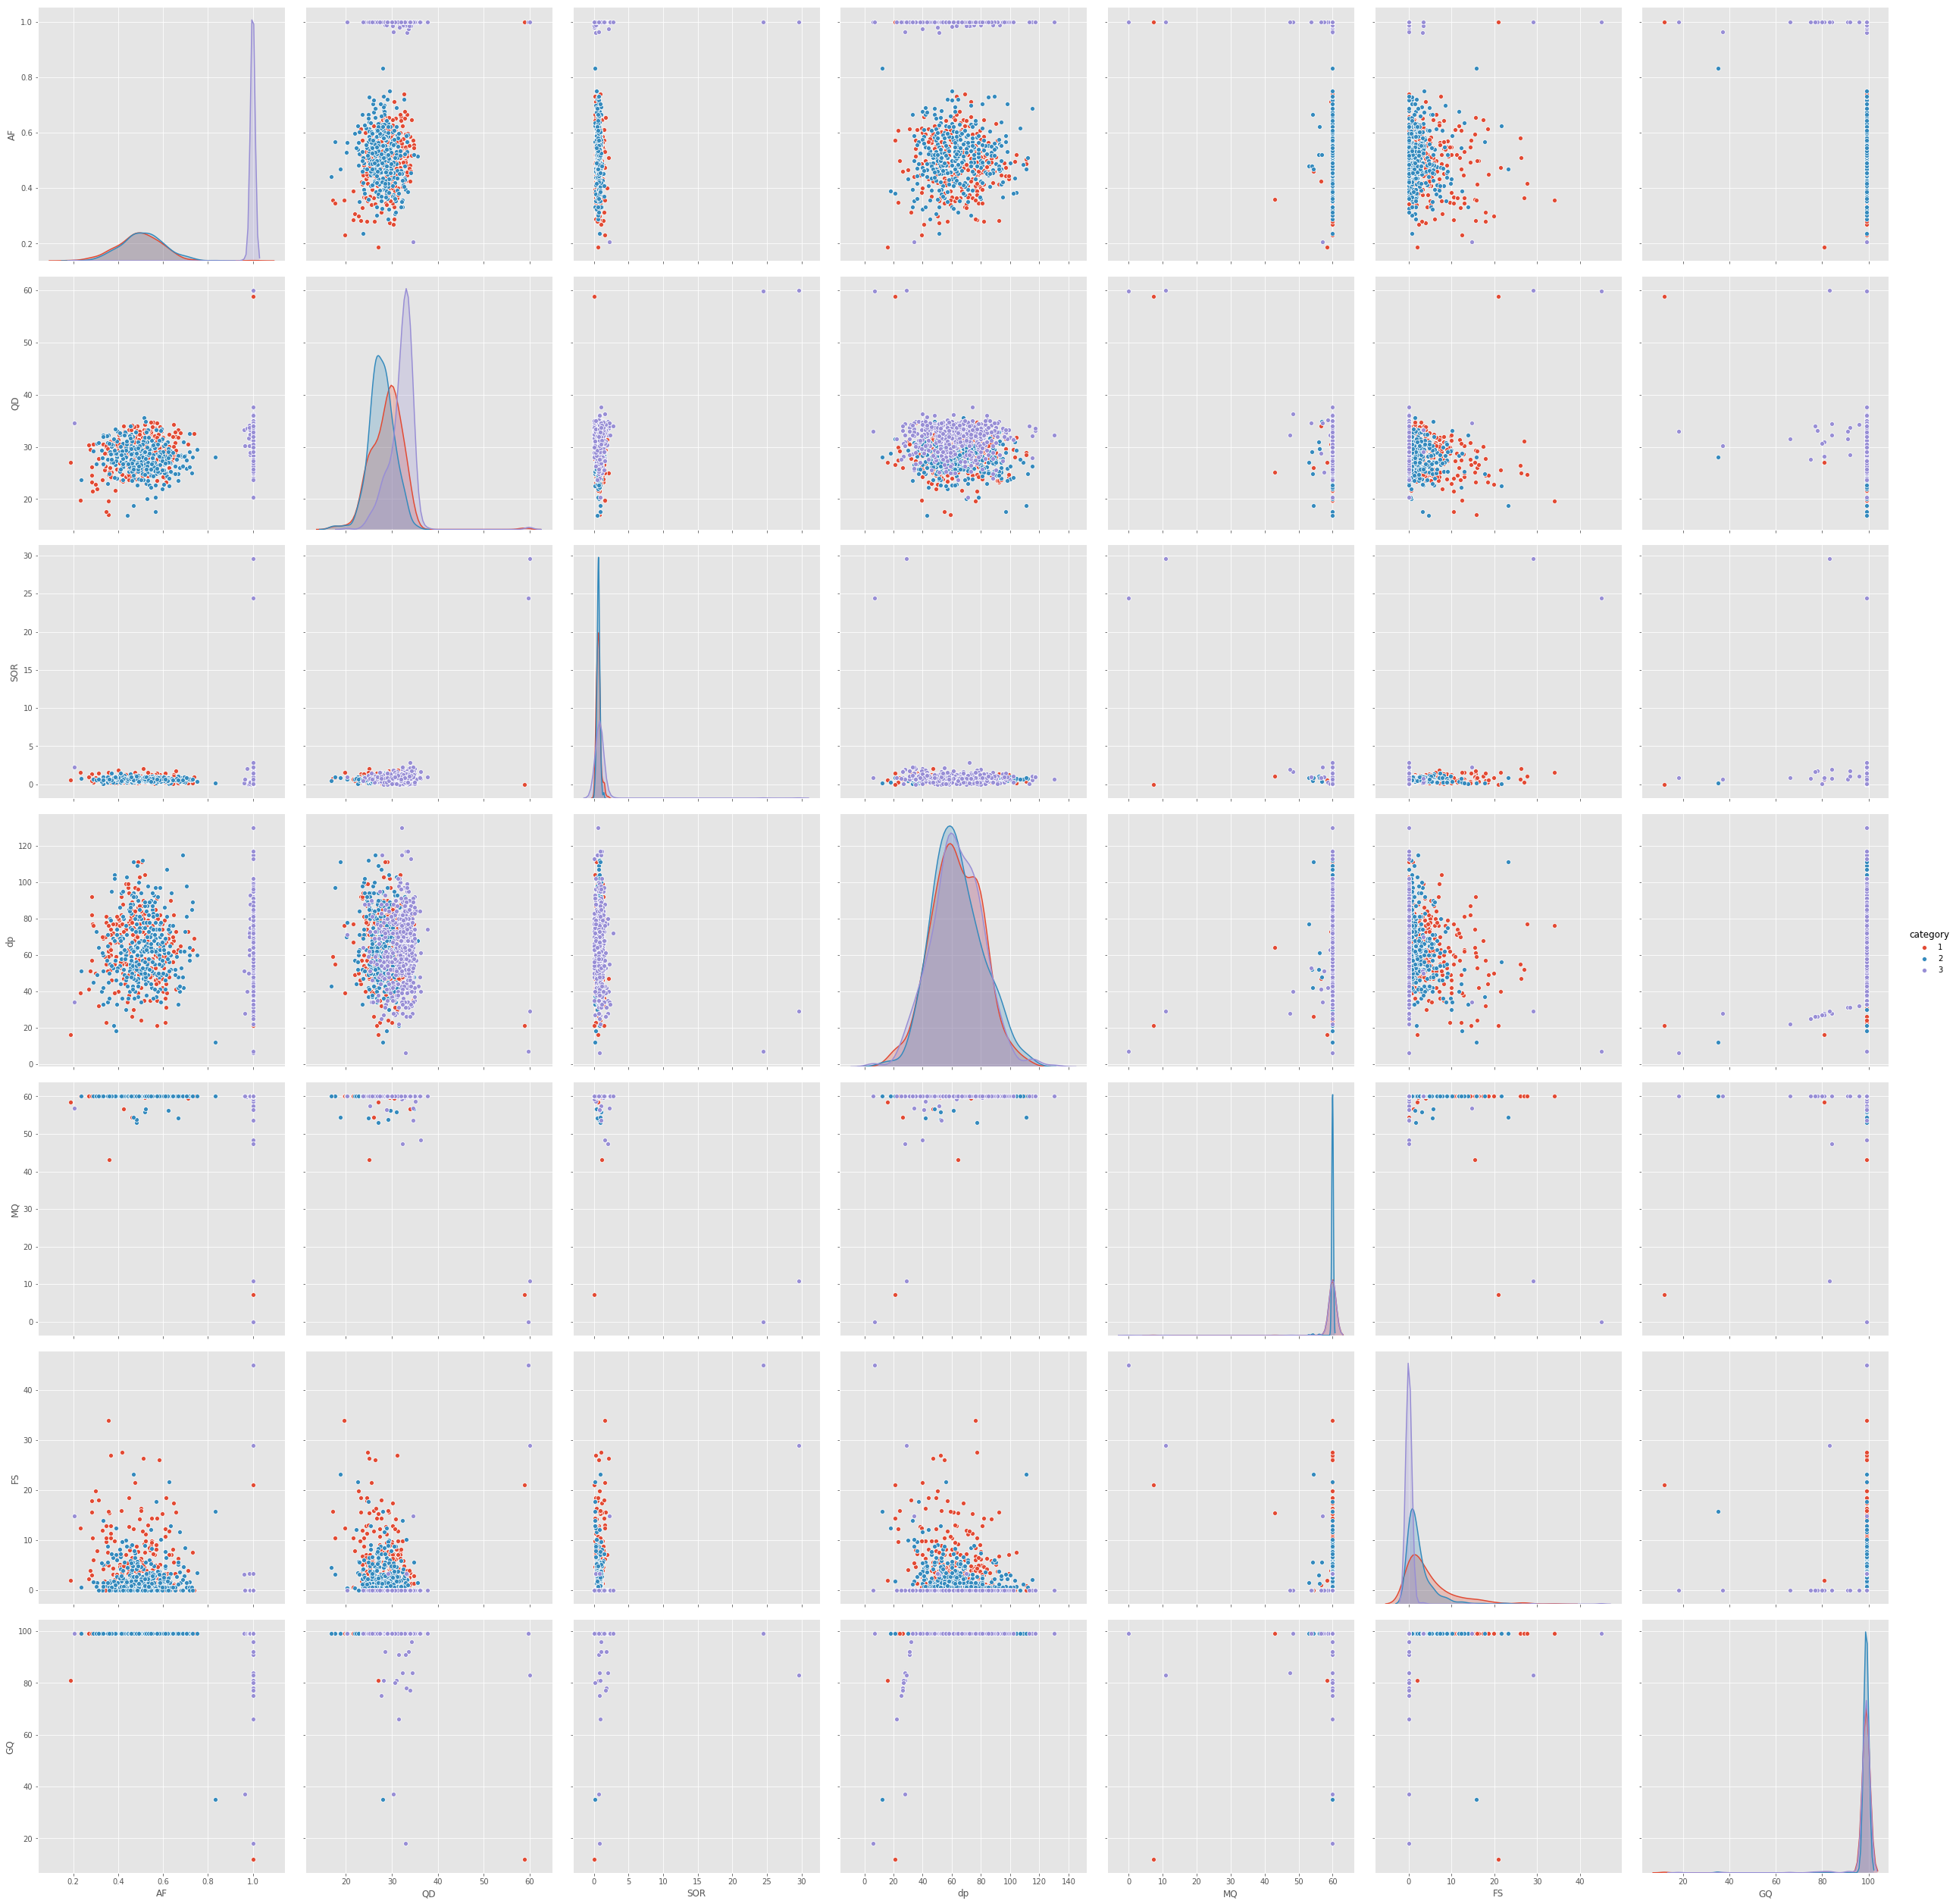

In [63]:
sns.pairplot(Ktest5, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

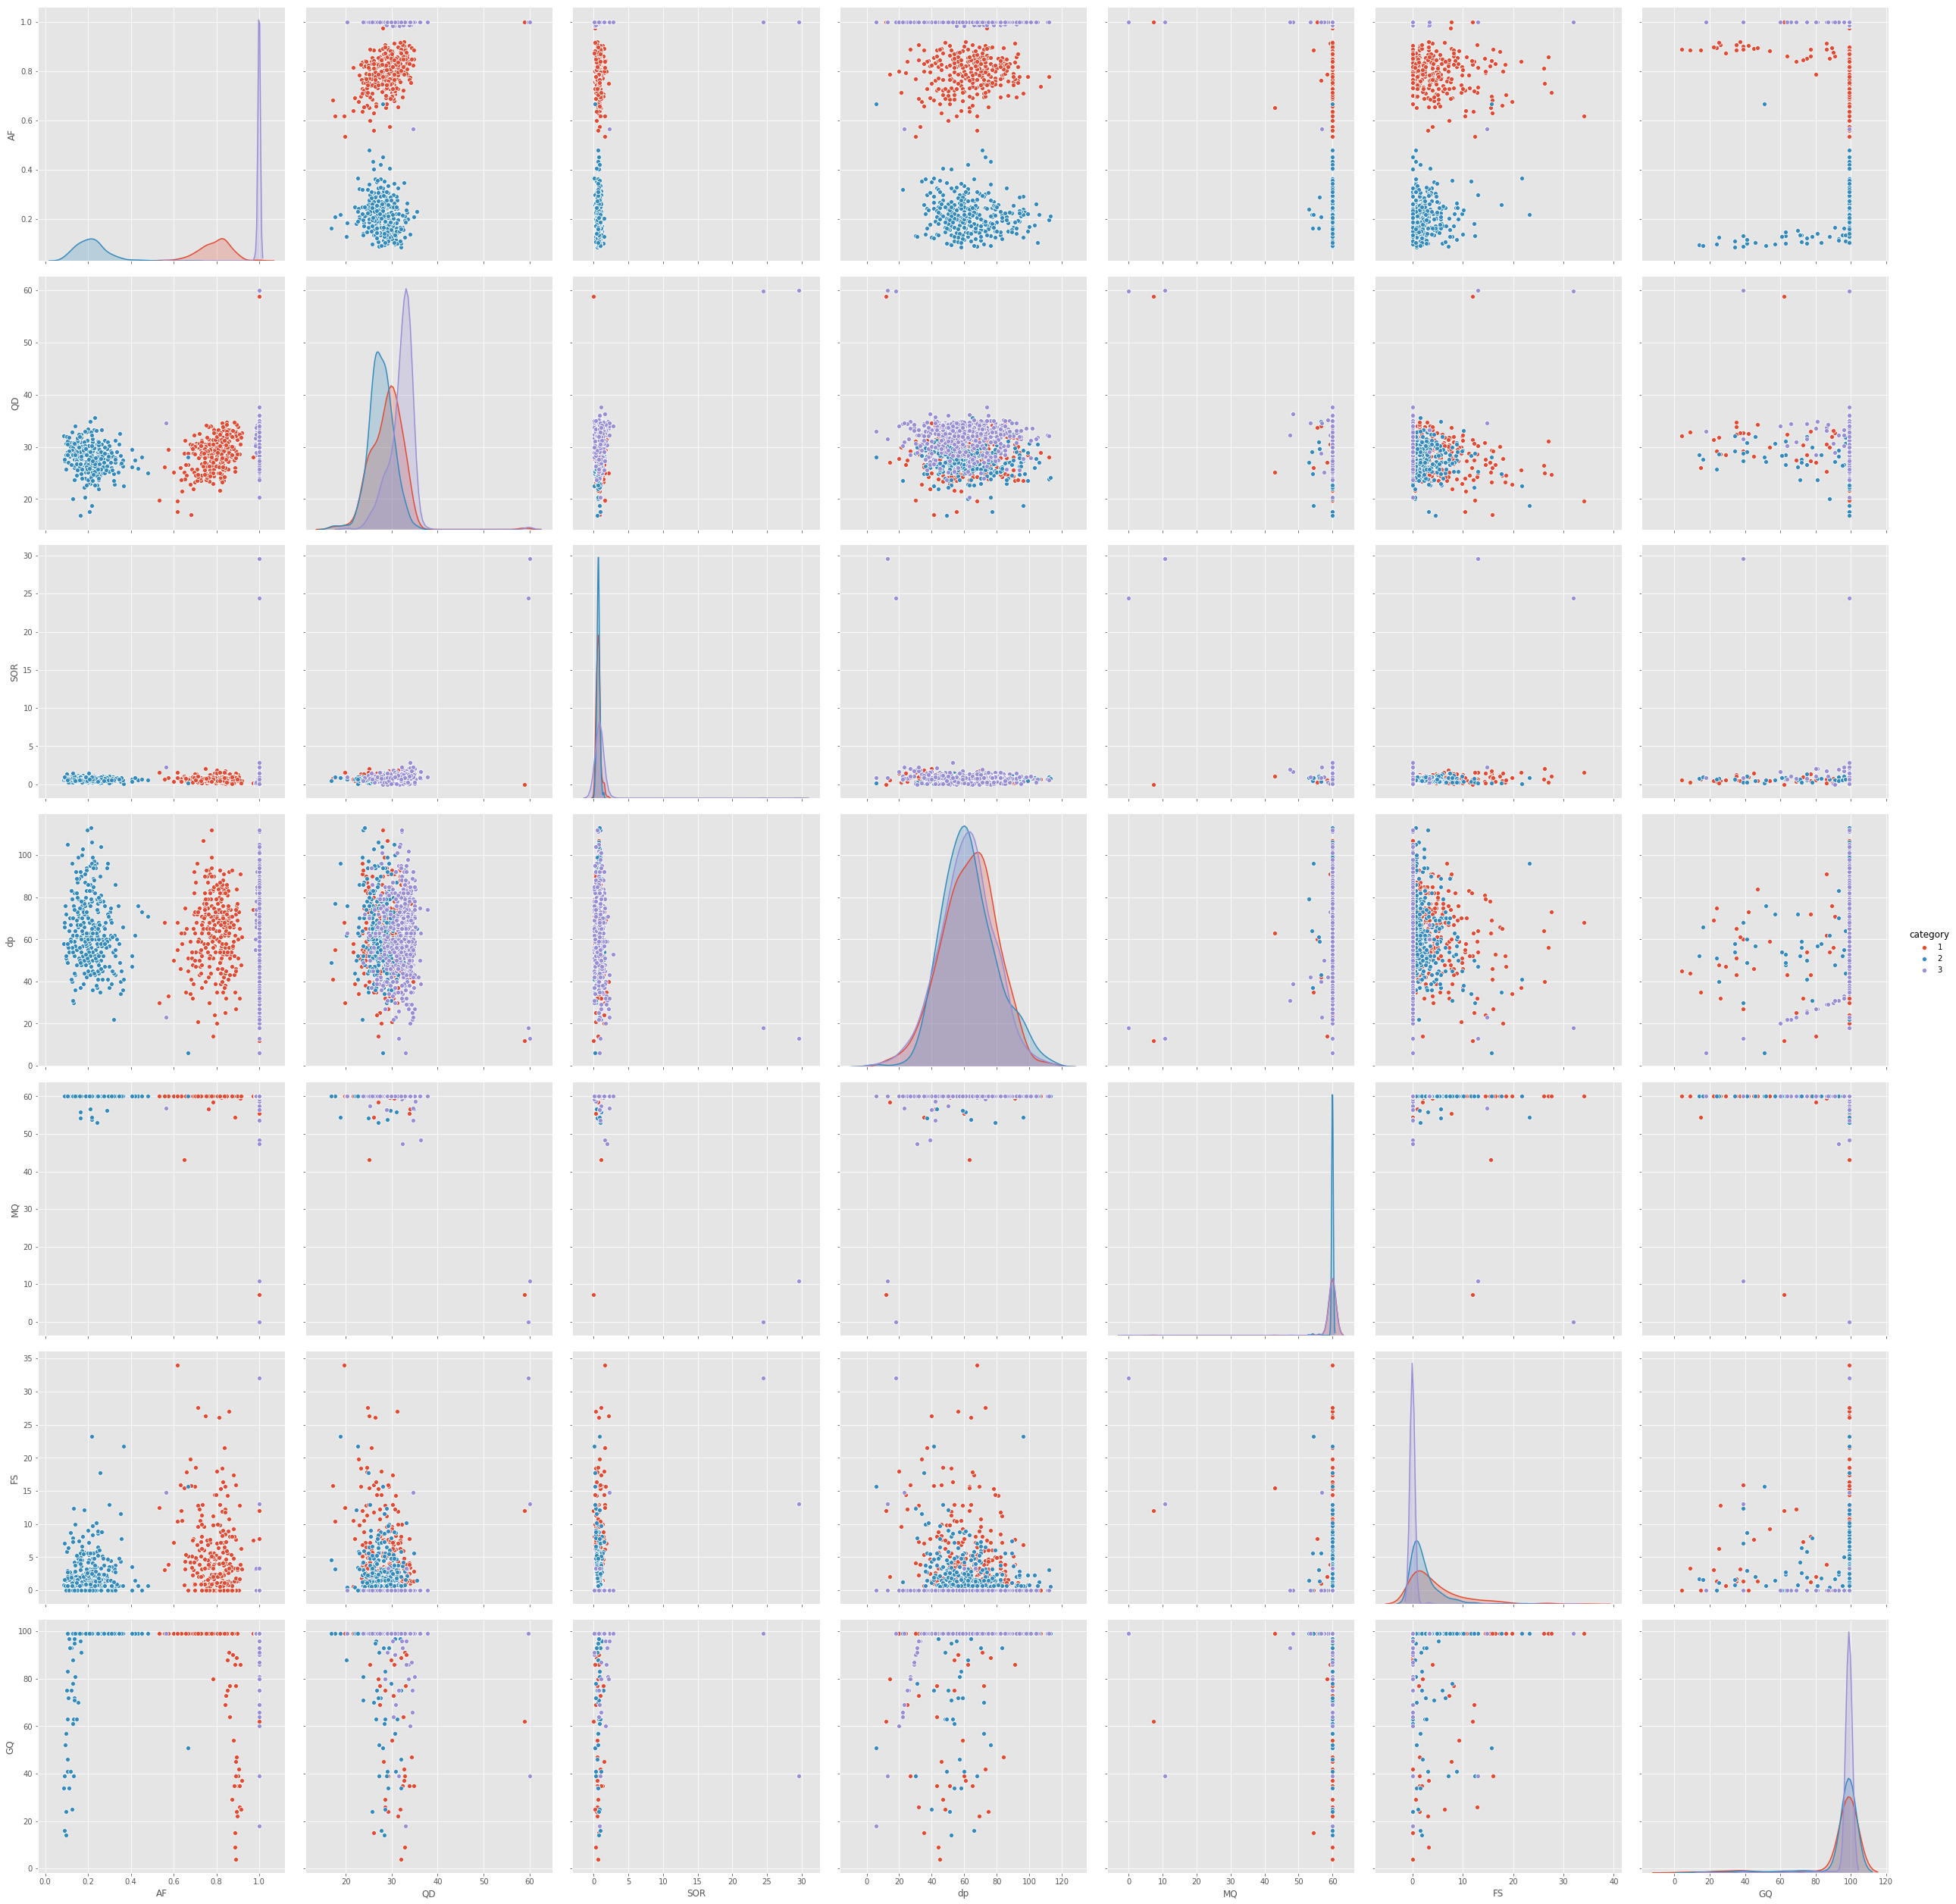

In [64]:
sns.pairplot(Ktest8, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

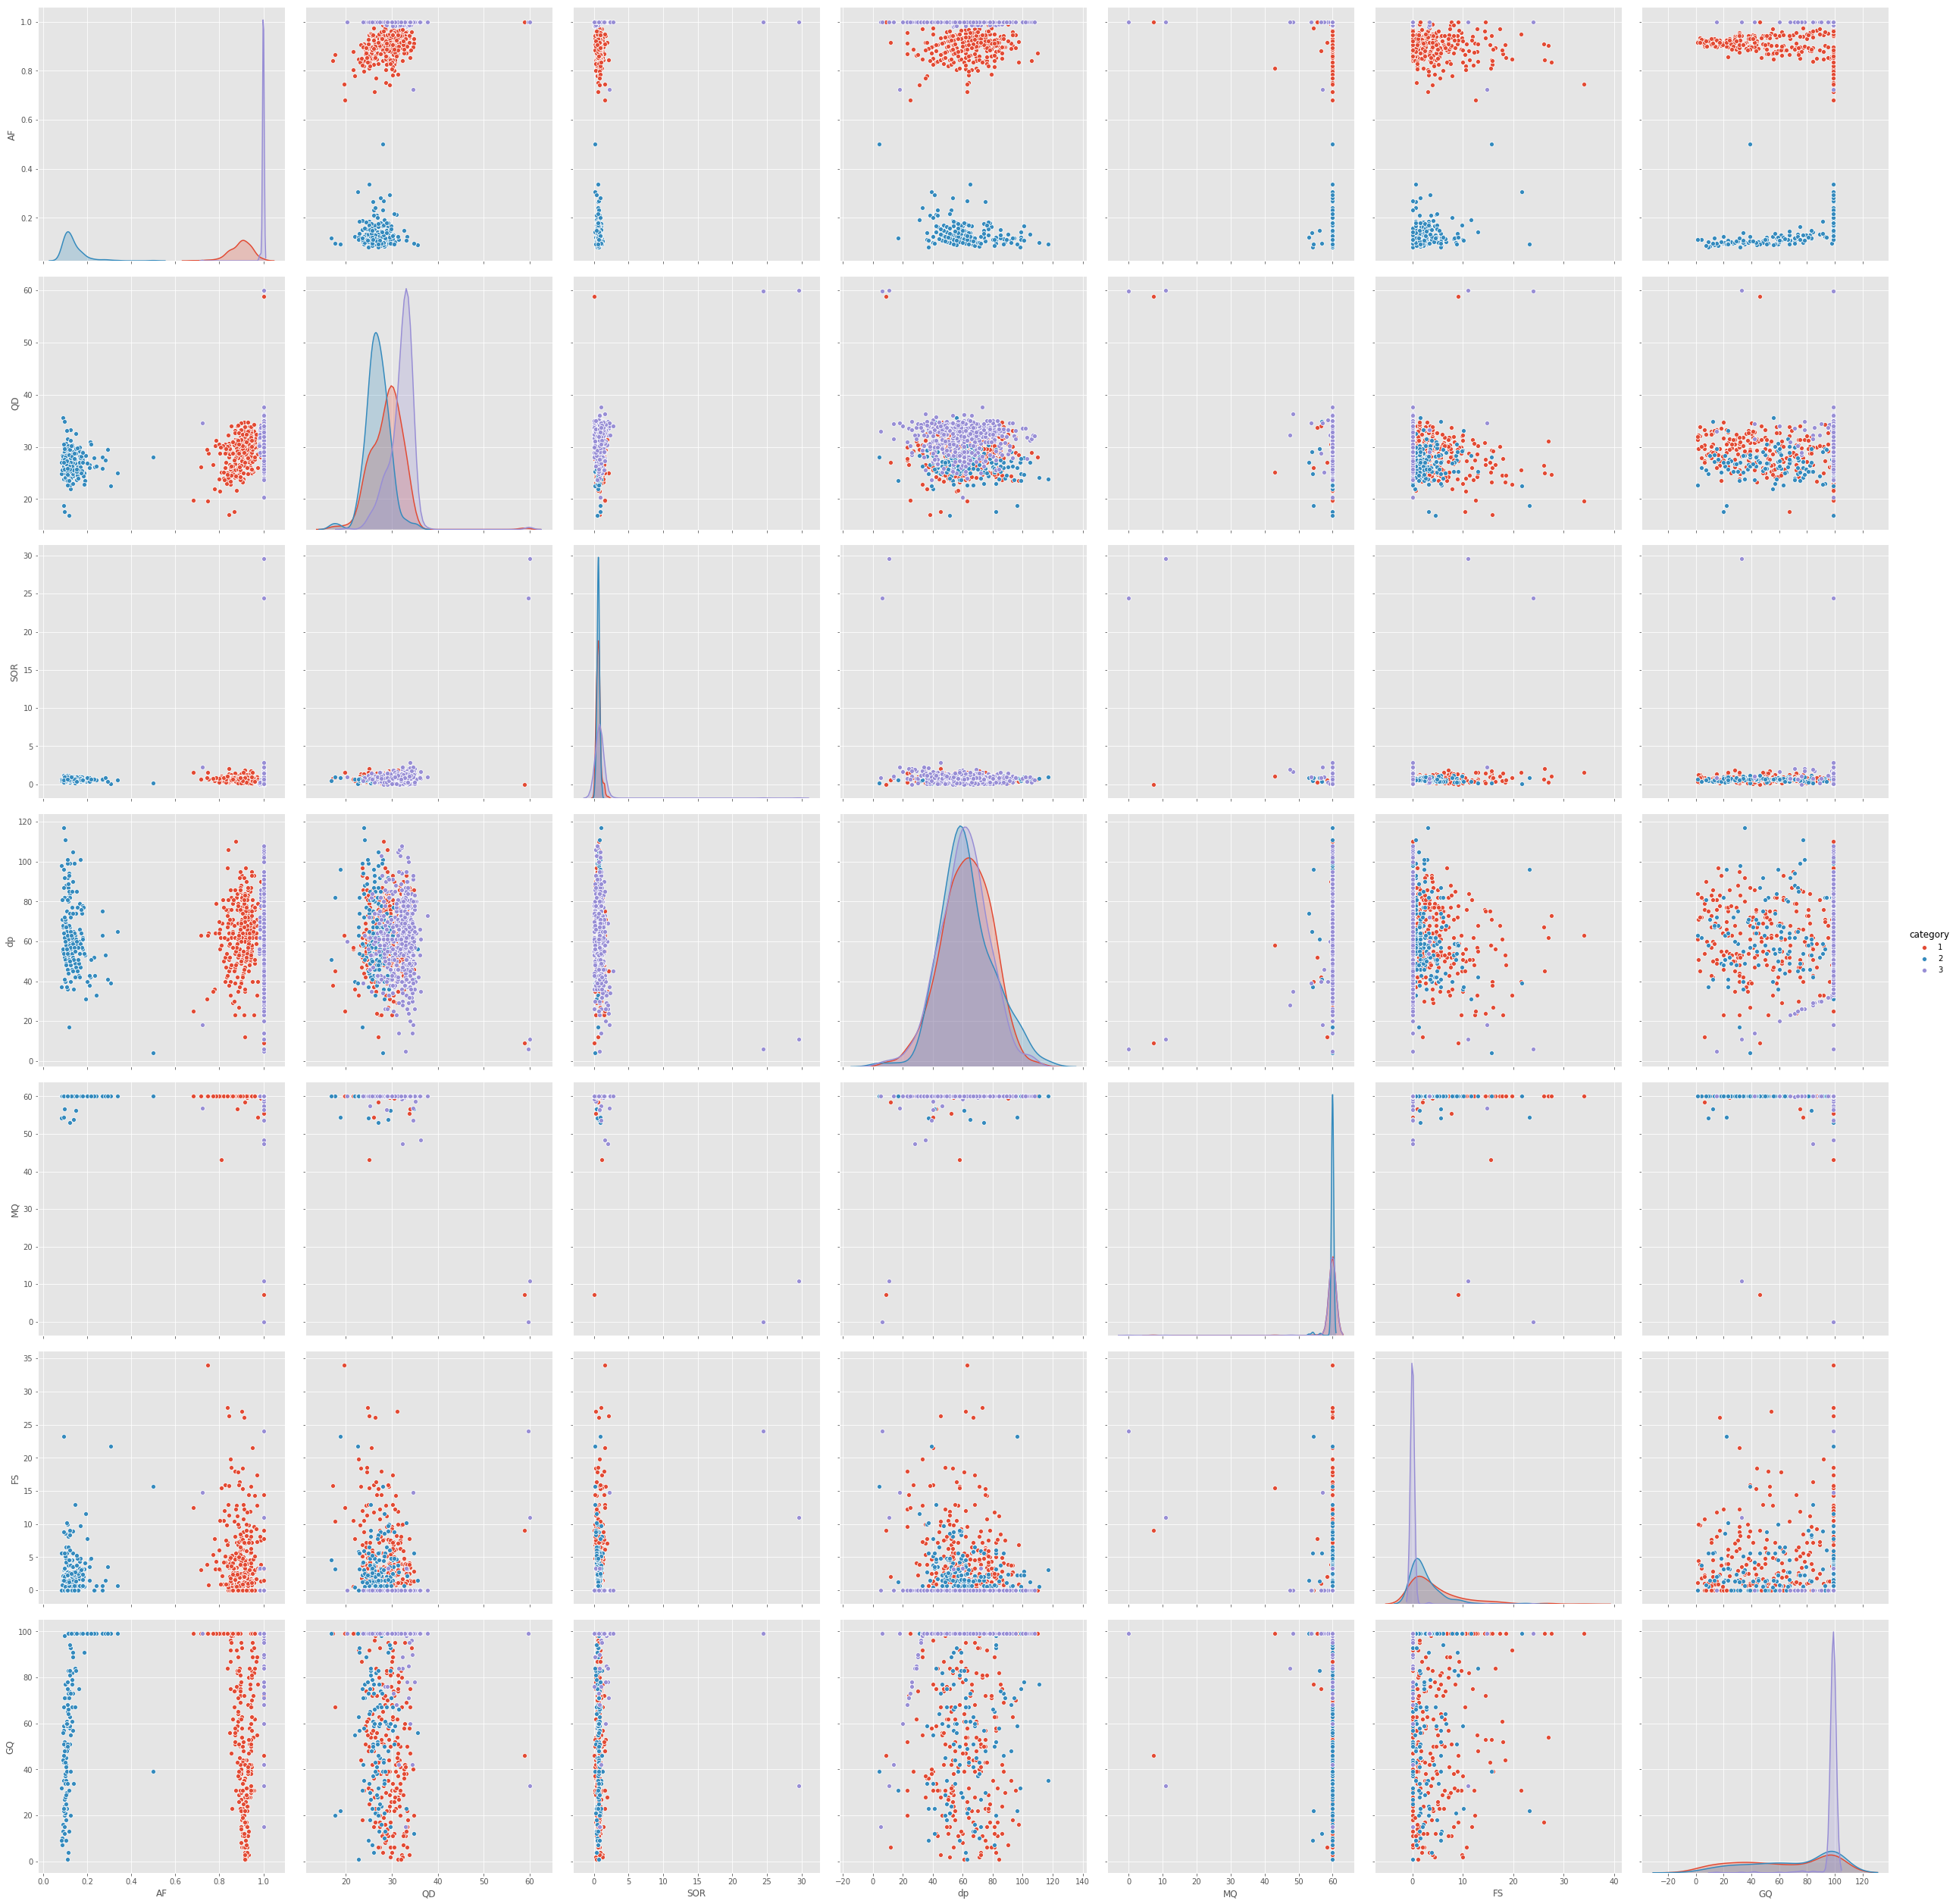

In [65]:
sns.pairplot(Ktest9, hue='category',size=5,vars=["AF","QD","SOR","dp", "MQ", "FS","GQ"],kind='scatter')

In [118]:
X = np.array(Ktest5[["AF","QD","FS"]])
y = np.array(Ktest5['category'])
X.shape

(1142, 3)

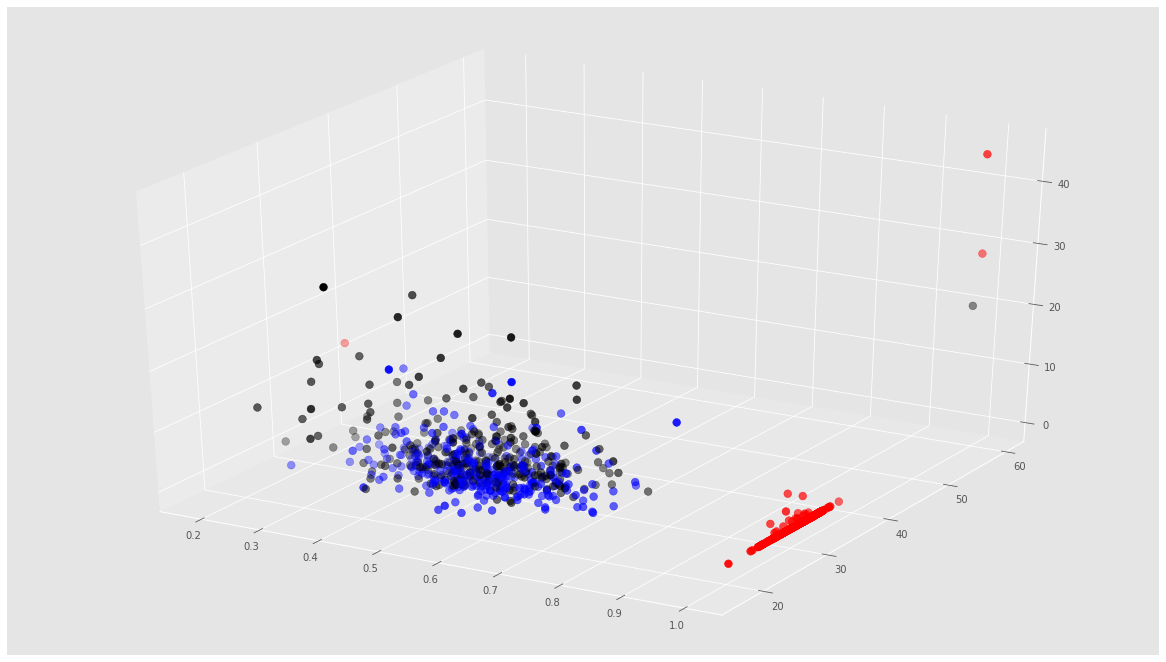

In [119]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y:
    assign.append(colors[row - 1])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)

In [120]:
X8 = np.array(Ktest8[["AF","QD","FS"]])
y8 = np.array(Ktest8['category'])
X8.shape

(1133, 3)

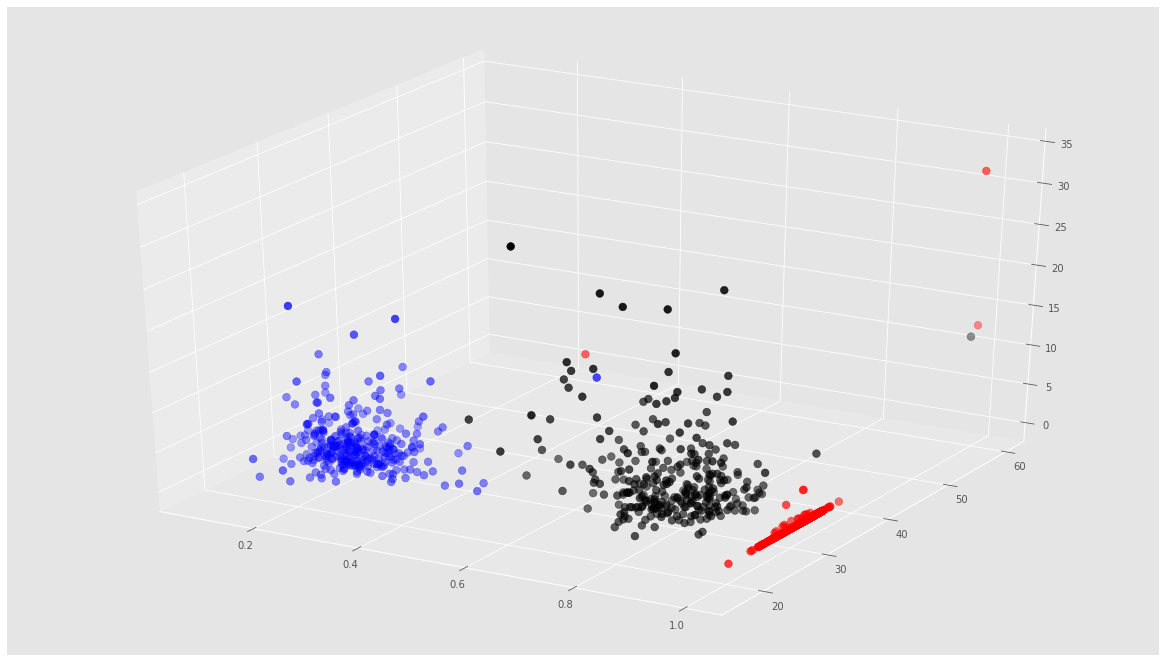

In [121]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y8:
    assign.append(colors[row - 1])
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)

In [122]:
X9 = np.array(Ktest9[["AF","QD","FS"]])
y9 = np.array(Ktest9['category'])
X9.shape

(999, 3)

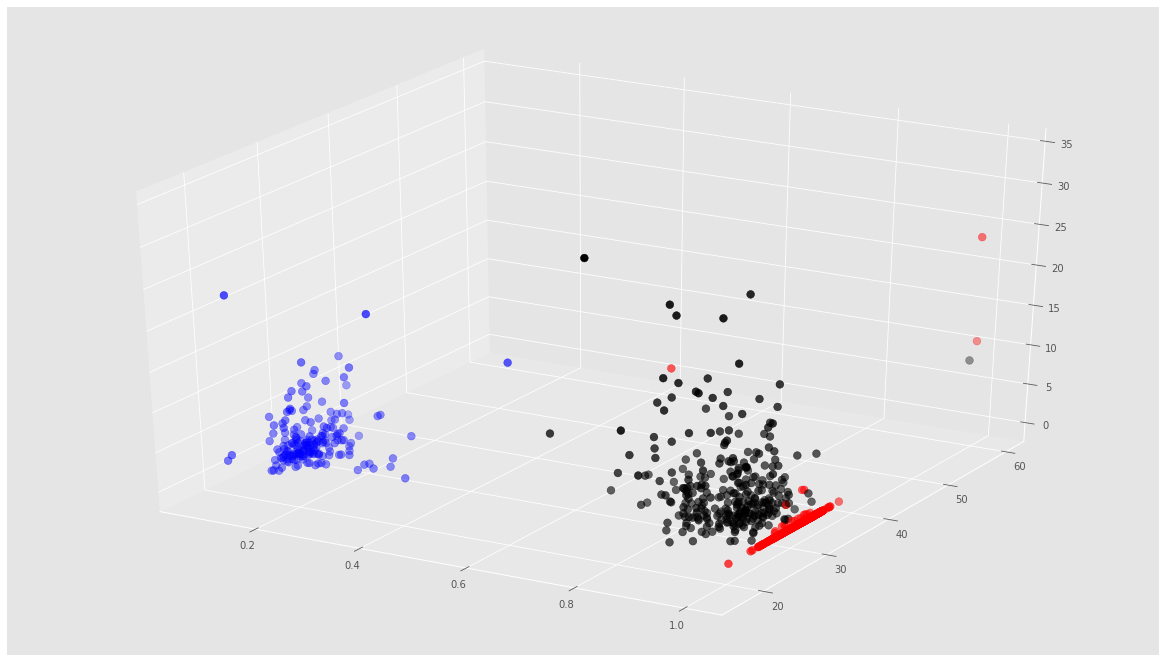

In [123]:
fig = plt.figure()
ax = Axes3D(fig)
colors=['black','blue','red','purple']
assign=[]
for row in y9:
    assign.append(colors[row - 1])
ax.scatter(X9[:, 0], X9[:, 1], X9[:, 2], c=assign,s=60)

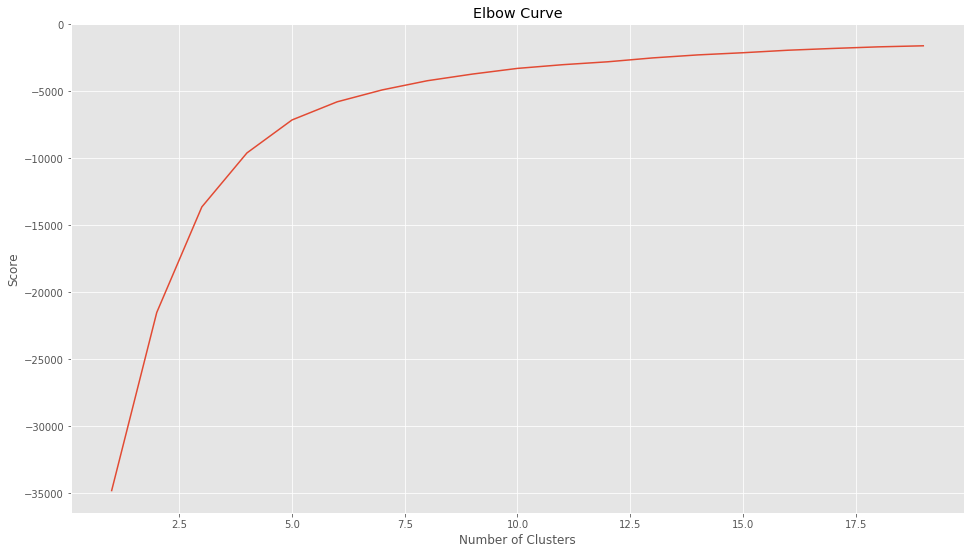

In [124]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [125]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.86472356 32.55681973  0.42405952]
 [ 0.49925621 28.26459459 14.66097297]
 [ 0.590356   27.20033333  1.98763333]]


In [126]:
kmeans8 = KMeans(n_clusters=3, max_iter=1000).fit(X8)
centroids8 = kmeans8.cluster_centers_
print(centroids8)

[[ 0.52185187 27.2292389   1.85401268]
 [ 0.63863113 27.28950617 13.43118519]
 [ 0.89682992 32.68020725  0.46510363]]


In [116]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

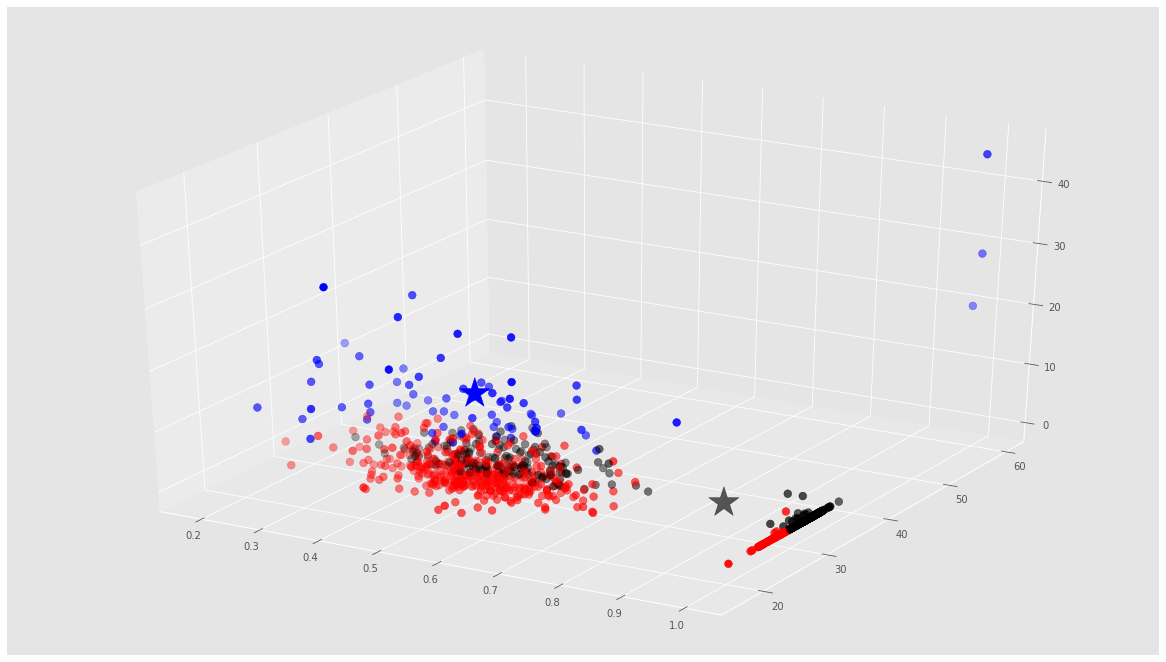

In [127]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=assign,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colors, s=1000)

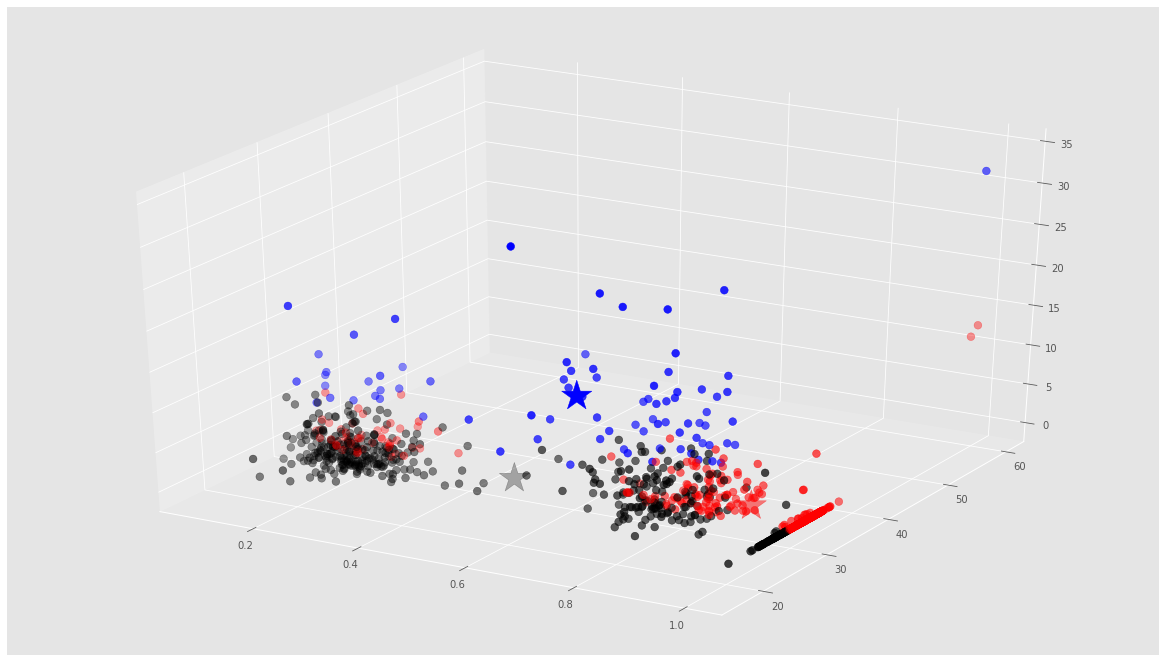

In [128]:
# Predicting the clusters
labels8 = kmeans8.predict(X8)
# Getting the cluster centers
C8 = kmeans8.cluster_centers_
colors=['black','blue','red']
assign=[]
for row in labels8:
    assign.append(colors[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X8[:, 0], X8[:, 1], X8[:, 2], c=assign,s=60)
ax.scatter(C8[:, 0], C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)

In [101]:
print(labels)

[0 0 2 ... 0 2 2]


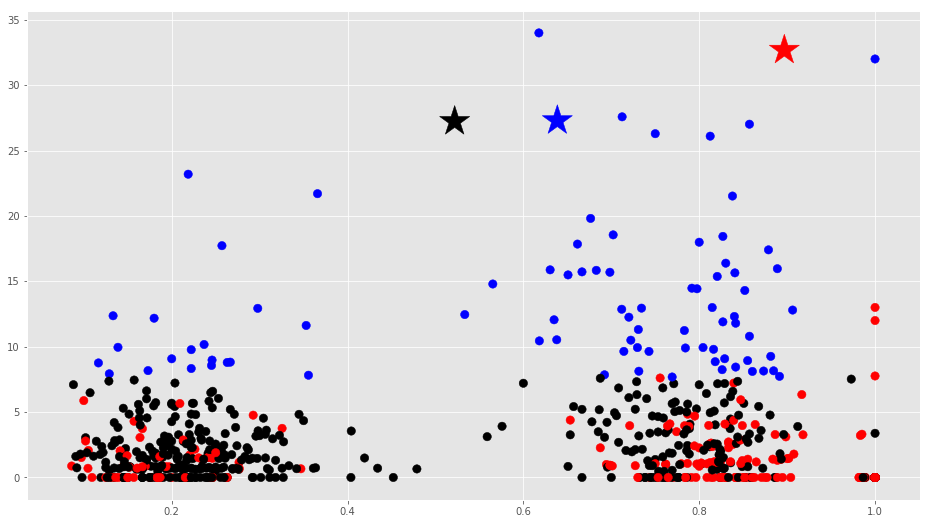

In [134]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 0], C8[:, 1], marker='*', c=colors, s=1000)
plt.show()

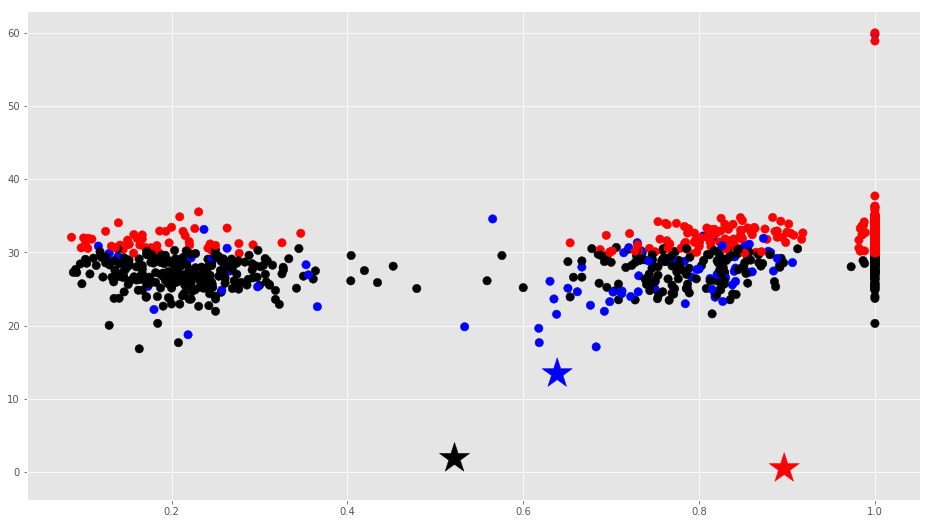

In [133]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['QD'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 0], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

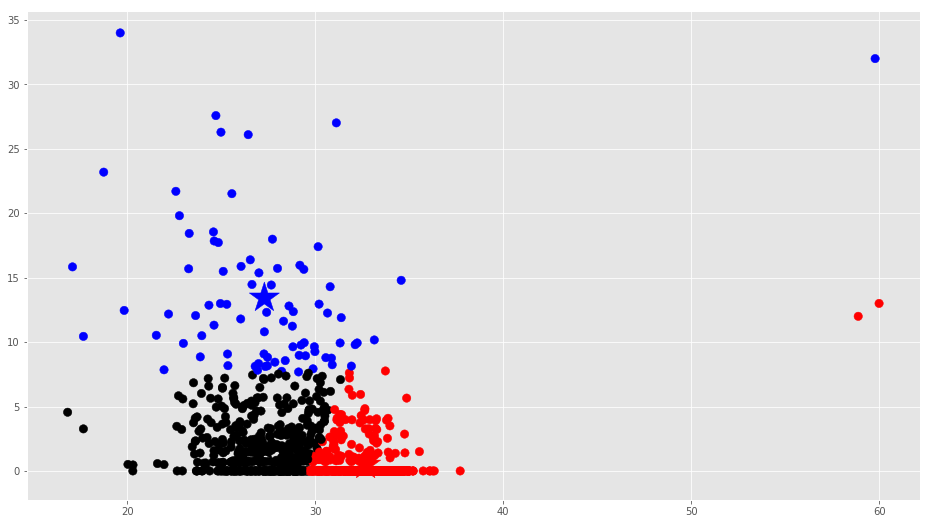

In [132]:
# Getting the values and plotting it
f1 = Ktest8['QD'].values
f2 = Ktest8['FS'].values

plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(C8[:, 1], C8[:, 2], marker='*', c=colors, s=1000)
plt.show()

In [150]:
copy =  pd.DataFrame()
copy['POS']=Ktest8['POS'].values
copy['AF']=Ktest8['AF'].values
copy['category']=Ktest8['category'].values
copy['label'] = labels8;
Ngrouped =  pd.DataFrame()
Ngrouped['colors']=colors
Ngrouped['N']=copy.groupby('label').size()
Ngrouped

colors    N
0  black  473
1   blue   81
2    red  579

In [151]:
copy.head()

POS        AF  category  label
0  1977  0.761905         1      2
1  2532  1.000000         3      2
2  6140  0.173077         2      0
3  7585  0.694444         1      2
4  9143  1.000000         3      2

# Use more labels

In [229]:
W = np.array(Ktest8[["AF","QD","FS","MQ","SOR", "DP", "dp"]])
W

array([[ 0.76190476, 30.57      ,  1.003     , ...,  0.434     ,
        42.        , 42.        ],
       [ 1.        , 31.55      ,  0.        , ...,  0.883     ,
        13.        , 13.        ],
       [ 0.17307692, 29.67      ,  0.919     , ...,  0.827     ,
        52.        , 52.        ],
       ...,
       [ 1.        , 31.95      ,  0.        , ...,  0.707     ,
        59.        , 59.        ],
       [ 0.20481928, 25.89      ,  0.        , ...,  0.686     ,
        83.        , 83.        ],
       [ 0.34482759, 30.52      ,  4.826     , ...,  0.643     ,
        58.        , 58.        ]])

In [230]:
kmeansw = KMeans(n_clusters=3, max_iter=1000, verbose=0).fit(W)
centroidsw = kmeansw.cluster_centers_
print(kmeansw)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [231]:
print(centroidsw)

[[ 0.72691859 30.13407801  2.95849645 59.20643617  0.98778369 41.65957447
  41.59929078]
 [ 0.72326104 30.16136937  1.71053153 59.93524324  0.73963604 61.96216216
  61.95315315]
 [ 0.714286   29.64307432  1.52205405 59.95243243  0.70502703 83.13175676
  83.11486486]]


In [232]:
labelsw = kmeansw.predict(W)


In [233]:
w =  pd.DataFrame()
w['POS']=Ktest8['POS'].values
w['AF']=Ktest8['AF'].values
w['category']=Ktest8['category'].values
w['label'] = labelsw;

In [234]:
labelsw

array([0, 0, 1, ..., 1, 2, 1], dtype=int32)

In [235]:
w.describe()

POS           AF     category        label
count  1.133000e+03  1133.000000  1133.000000  1133.000000
mean   2.188230e+06     0.721827     2.189762     1.012357
std    1.322093e+06     0.334785     0.824857     0.714456
min    1.977000e+03     0.086207     1.000000     0.000000
25%    1.057788e+06     0.292683     1.000000     1.000000
50%    2.154724e+06     0.851852     2.000000     1.000000
75%    3.311119e+06     1.000000     3.000000     2.000000
max    4.408156e+06     1.000000     3.000000     2.000000

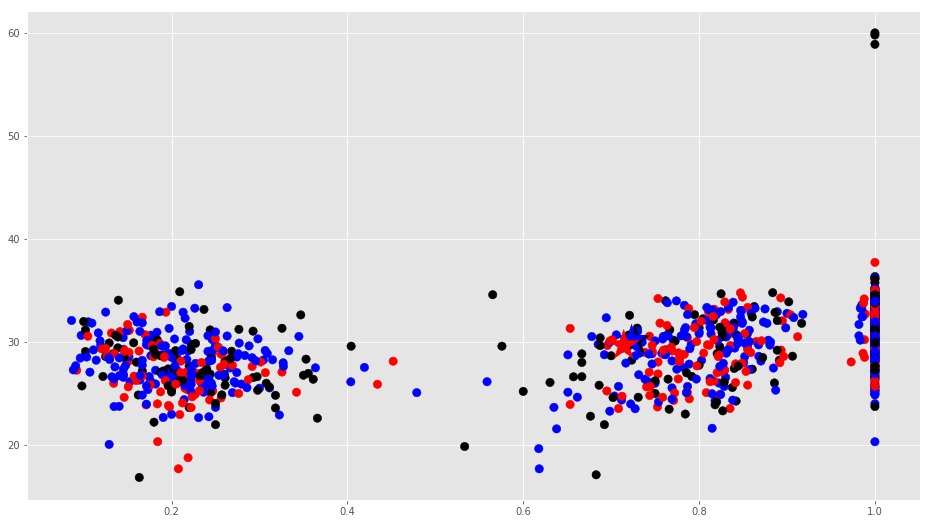

In [236]:
# Getting the values and plotting it
f1 = Ktest8['AF'].values
f2 = Ktest8['QD'].values


colors=['black','blue','red']
assign=[]
for row in labelsw:
    assign.append(colors[row])


plt.scatter(f1, f2, c=assign, s=70)
plt.scatter(centroidsw[:, 0], centroidsw[:, 1], marker='*', c=colors, s=1000)
plt.show()

In [ ]:
 metrics.adjusted_rand_score(labels_true, labels_pred)